In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# 패키지 로드

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 데이터 백업

In [10]:
sw_data = pd.read_csv('c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv')
sw_data = sw_data[['TA_YMD', 'HOUR', 'DAY', 'DONG', 'CNT', 'UNIT', 'TEMP', 'RAIN', 'AMT']]
sw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101513 entries, 0 to 101512
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TA_YMD  101513 non-null  int64  
 1   HOUR    101513 non-null  int64  
 2   DAY     101513 non-null  int64  
 3   DONG    101513 non-null  object 
 4   CNT     101513 non-null  int64  
 5   UNIT    101513 non-null  int64  
 6   TEMP    101513 non-null  float64
 7   RAIN    101513 non-null  float64
 8   AMT     101513 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 7.0+ MB


# 상관관계 분석

## 기본

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"  # 한글 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("data/SUWON_S_DATA_TABLE_GENDER_SUM.csv")

# DAY, HOUR → 범주형으로 처리
df["DAY"] = df["DAY"].astype(str)
df["HOUR"] = df["HOUR"].astype(str)

df_encoded = pd.get_dummies(
    df,
    columns=["DAY", "HOUR"],
    prefix=["DAY", "HOUR"],
    drop_first=False
)

num_df = df_encoded.select_dtypes(include=[np.number])

corr = num_df.corr()

In [19]:
mask = np.triu(np.ones_like(corr, dtype=bool))

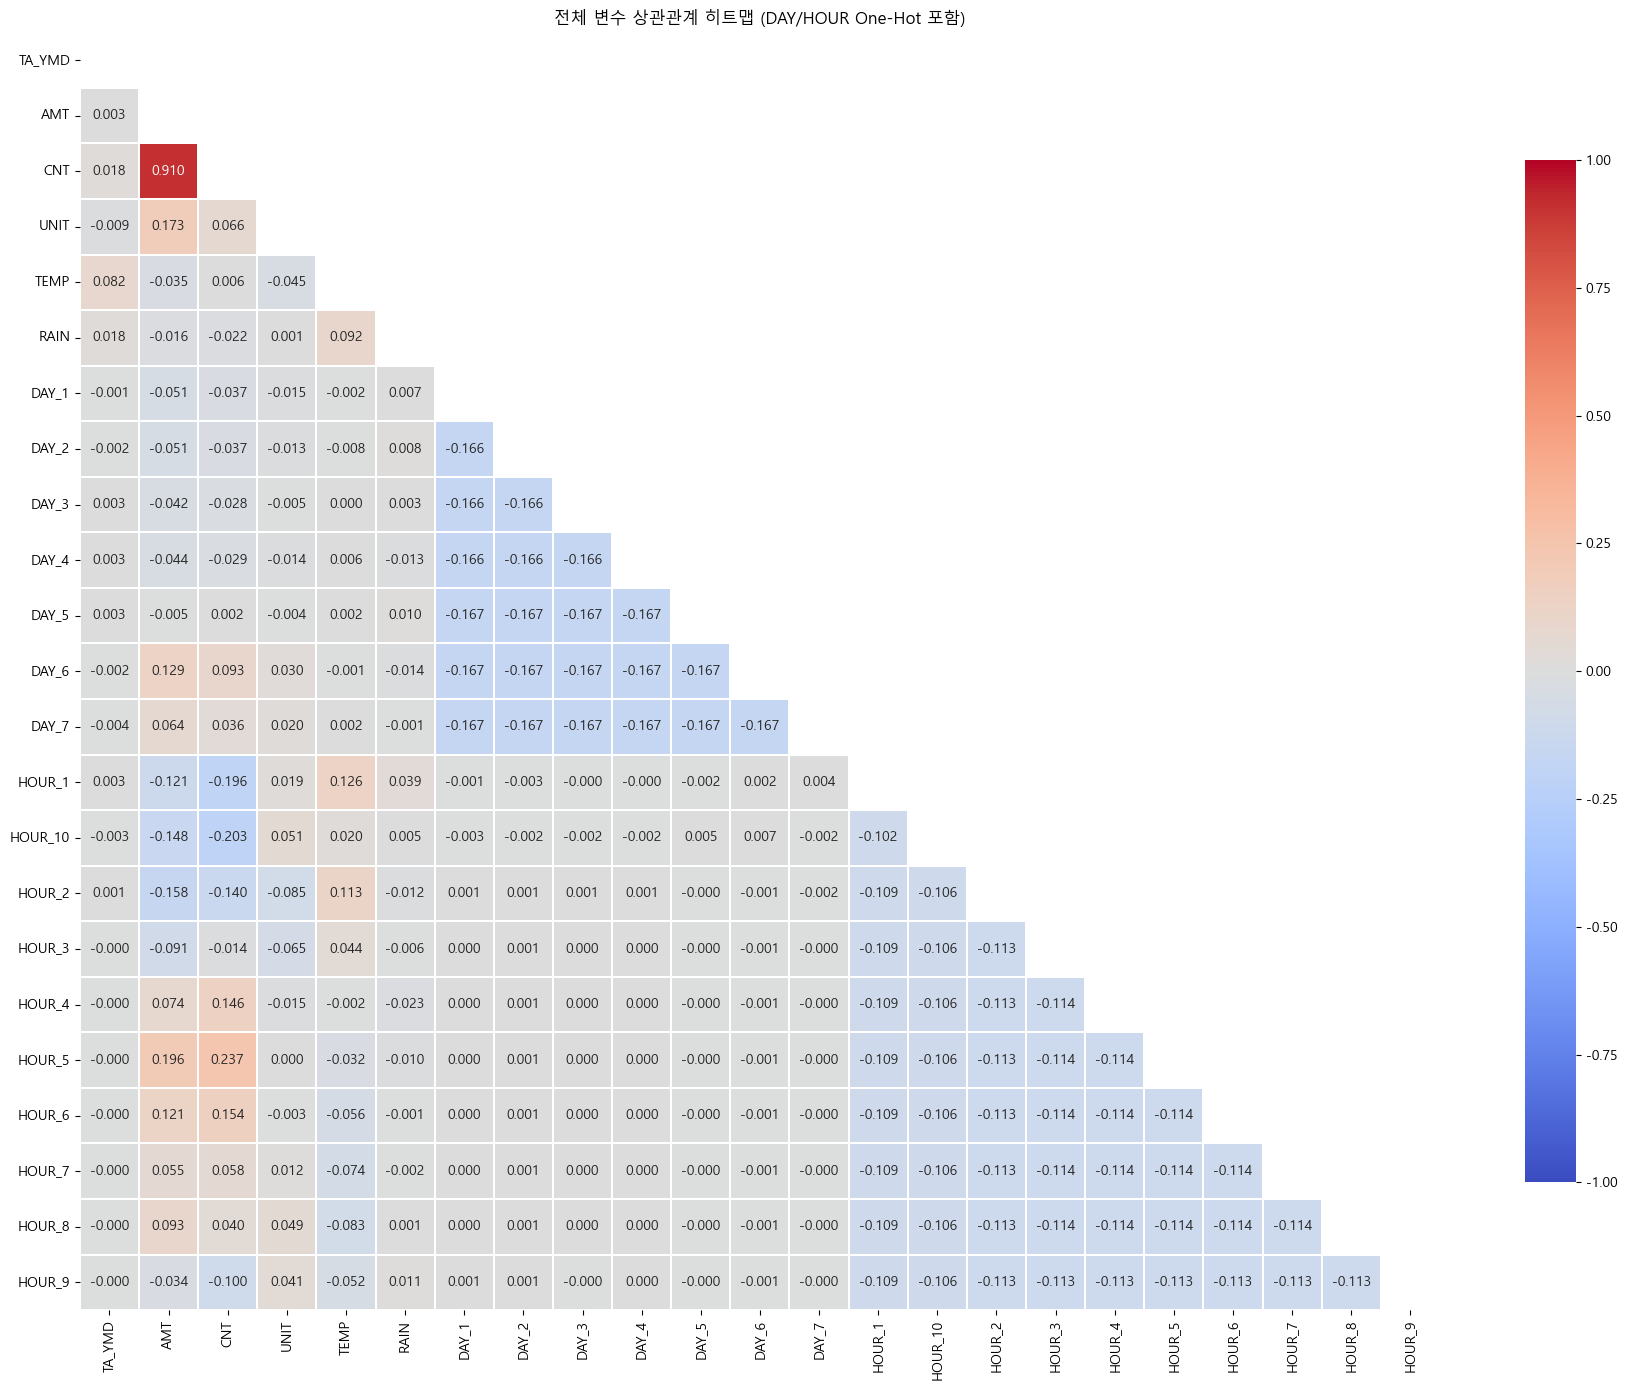

In [14]:
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    annot=True,
    fmt='.3f',
    mask=mask,
    vmax=1,
    vmin=-1
)
plt.title("전체 변수 상관관계 히트맵 (DAY/HOUR One-Hot 포함)")
plt.tight_layout()
plt.show()


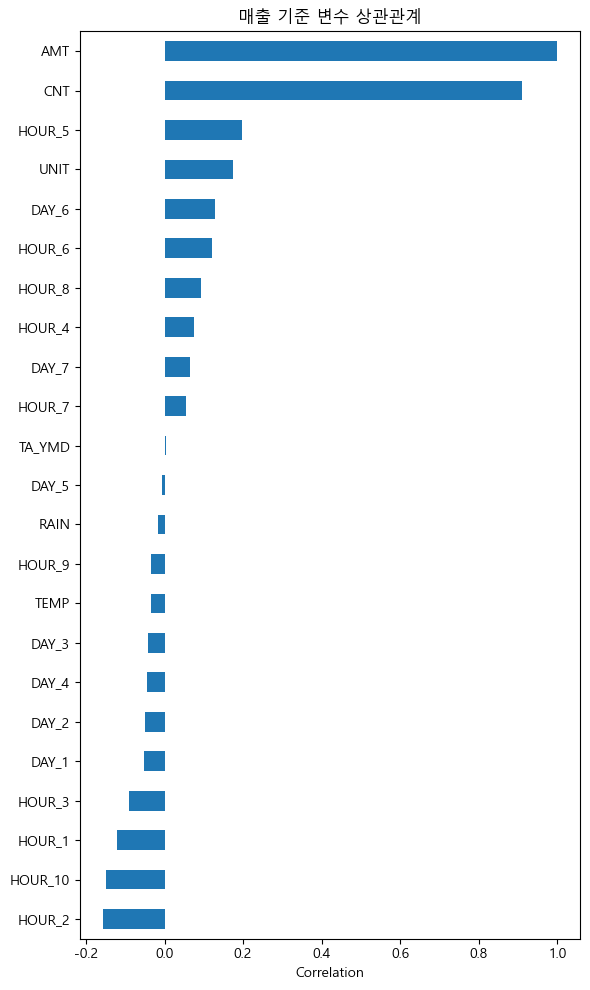

In [11]:
TARGET = "AMT"   

sales_corr = corr[TARGET].sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sales_corr.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("매출 기준 변수 상관관계")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


## 배달

In [15]:
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("data/수원시 팔달구 카페_배달 데이터.csv")

df.head()

,TA_YMD,HOUR,DAY,DONG,AMT,CNT,UNIT,TEMP,RAIN,AMT_D,CNT_D,UNIT_D
0,20230101,1,7,고등동,65063,7,9295,2.10,0.0,0,0,0
1,20230101,2,7,고등동,14878,4,3720,-0.20,0.0,0,0,0
2,20230101,3,7,고등동,77671,20,3884,-2.25,0.0,0,0,0
3,20230101,4,7,고등동,452897,52,8710,-3.20,0.0,0,0,0
4,20230101,5,7,고등동,972179,92,10567,-4.10,0.0,0,0,0


In [24]:
RAIN_COL = "RAIN"       
DELIVERY_COL = "AMT_D"  
OFFLINE_COL = "AMT"  
TEMP_COL = 'TEMP'

corr_df = df[[RAIN_COL, DELIVERY_COL, OFFLINE_COL, TEMP_COL]].corr()
corr_df

,RAIN,AMT_D,AMT,TEMP
RAIN,1.000000,0.005713,-0.016487,0.091750
AMT_D,0.005713,1.000000,0.322754,-0.007277
AMT,-0.016487,0.322754,1.000000,-0.035172
TEMP,0.091750,-0.007277,-0.035172,1.000000


In [25]:
mask = np.triu(np.ones_like(corr_df, dtype=bool))

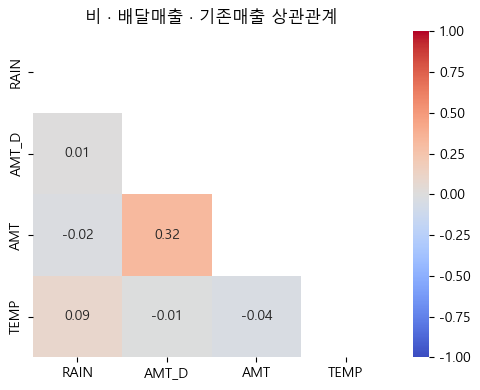

In [26]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    mask=mask,
    vmax=1,
    vmin=-1
)
plt.title("비 · 기온 · 배달매출 · 기존매출 상관관계")
plt.tight_layout()
plt.show()

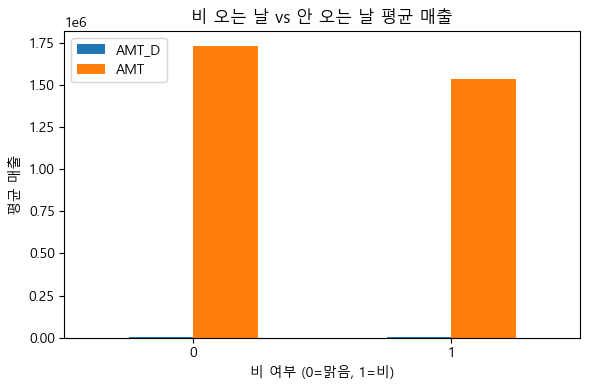

In [27]:
df["is_rain"] = (df[RAIN_COL] > 0).astype(int)

rain_compare = df.groupby("is_rain")[
    [DELIVERY_COL, OFFLINE_COL]
].mean()

rain_compare

rain_compare.plot(
    kind="bar",
    figsize=(6, 4)
)
plt.title("비 오는 날 vs 안 오는 날 평균 매출")
plt.xlabel("비 여부 (0=맑음, 1=비)")
plt.ylabel("평균 매출")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 배달 매출 있는날만 비교

In [28]:
df['has_delivery'] = (df['AMT_D'] > 0).astype(int)

df[["RAIN", "has_delivery"]].corr()


,RAIN,has_delivery
RAIN,1.000000,0.002933
has_delivery,0.002933,1.000000


In [29]:
df_delivery = df[df['AMT_D'] > 0]

df_delivery[['RAIN', 'AMT_D']].corr()


,RAIN,AMT_D
RAIN,1.000000,0.016827
AMT_D,0.016827,1.000000


## 음식 전체 상관관계

In [42]:
df = pd.read_csv("data/SUWON_FOOD_DATA_TABLE.csv")

df["DAY"] = df["DAY"].astype(str)
df["HOUR"] = df["HOUR"].astype(str)

df_encoded = pd.get_dummies(
    df,
    columns=["DAY", "HOUR"],
    prefix=["DAY", "HOUR"],
    drop_first=False
)

SALES_COL = "UNIT"     
RAIN_COL  = "RAIN"      
TEMP_COL  = "TEMP"      
TYPE_COL  = "TYPE"

type_corr = (df.groupby(TYPE_COL)[[RAIN_COL, TEMP_COL, SALES_COL]].corr().unstack().loc[:, (slice(None), SALES_COL)])

type_corr

,RAIN,TEMP,UNIT
,UNIT,UNIT,UNIT
TYPE,,,
간이주점,0.011171,-0.022413,1.0
고기요리,0.001212,-0.041354,1.0
닭/오리요리,0.005003,-0.010530,1.0
별식/퓨전요리,0.004244,-0.031059,1.0
부페,-0.002199,-0.013912,1.0
분식,0.000042,-0.013062,1.0
양식,-0.000289,-0.013237,1.0
유흥주점,0.001153,0.016124,1.0


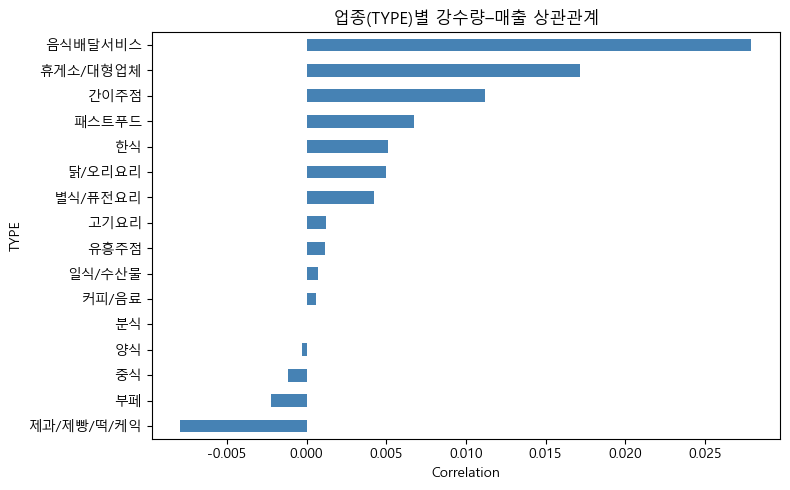

In [40]:
plt.figure(figsize=(8, 5))
type_corr[(RAIN_COL, SALES_COL)].sort_values().plot(
    kind="barh",
    color="steelblue"
)
plt.title("업종(TYPE)별 강수량–매출 상관관계")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

In [44]:
corr = df.corr()
corr

C:\Users\Admin\AppData\Local\Temp\ipykernel_13596\2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,TA_YMD,AMT,CNT,UNIT,TEMP,RAIN
TA_YMD,1.000000,-0.000889,0.013029,-0.001653,0.082817,0.017717
AMT,-0.000889,1.000000,0.824454,0.107276,-0.015337,-0.003241
CNT,0.013029,0.824454,1.000000,-0.004662,-0.005105,-0.007245
UNIT,-0.001653,0.107276,-0.004662,1.000000,-0.017594,0.000986
TEMP,0.082817,-0.015337,-0.005105,-0.017594,1.000000,0.094332
RAIN,0.017717,-0.003241,-0.007245,0.000986,0.094332,1.000000


## 수원시 배달 매출 기온 상관관계

=== AMT 상관 Top 15 (|Pearson| 기준) ===
                    pearson  spearman
UNIT               0.733826  0.895323
CNT                0.514544  0.540597
DONG_수원시 영통구 매탄3동  0.292057  0.263028
DONG_수원시 영통구 광교1동  0.209128  0.296245
HOUR_8             0.204126  0.177481
DONG_수원시 영통구 망포1동 -0.162155 -0.293592
DONG_수원시 팔달구 인계동  -0.133131 -0.111247
DONG_수원시 권선구 구운동  -0.123070 -0.217436
HOUR_9             0.122788  0.201223
HOUR_6            -0.110497 -0.186452
HOUR_4            -0.091749 -0.136547
DONG_수원시 권선구 세류3동 -0.087982 -0.069363
HOUR_7            -0.084901 -0.076751
HOUR_5            -0.080869 -0.111917
HOUR_3            -0.067458 -0.146741


C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:86: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.tight_layout()
C:\

C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from curr

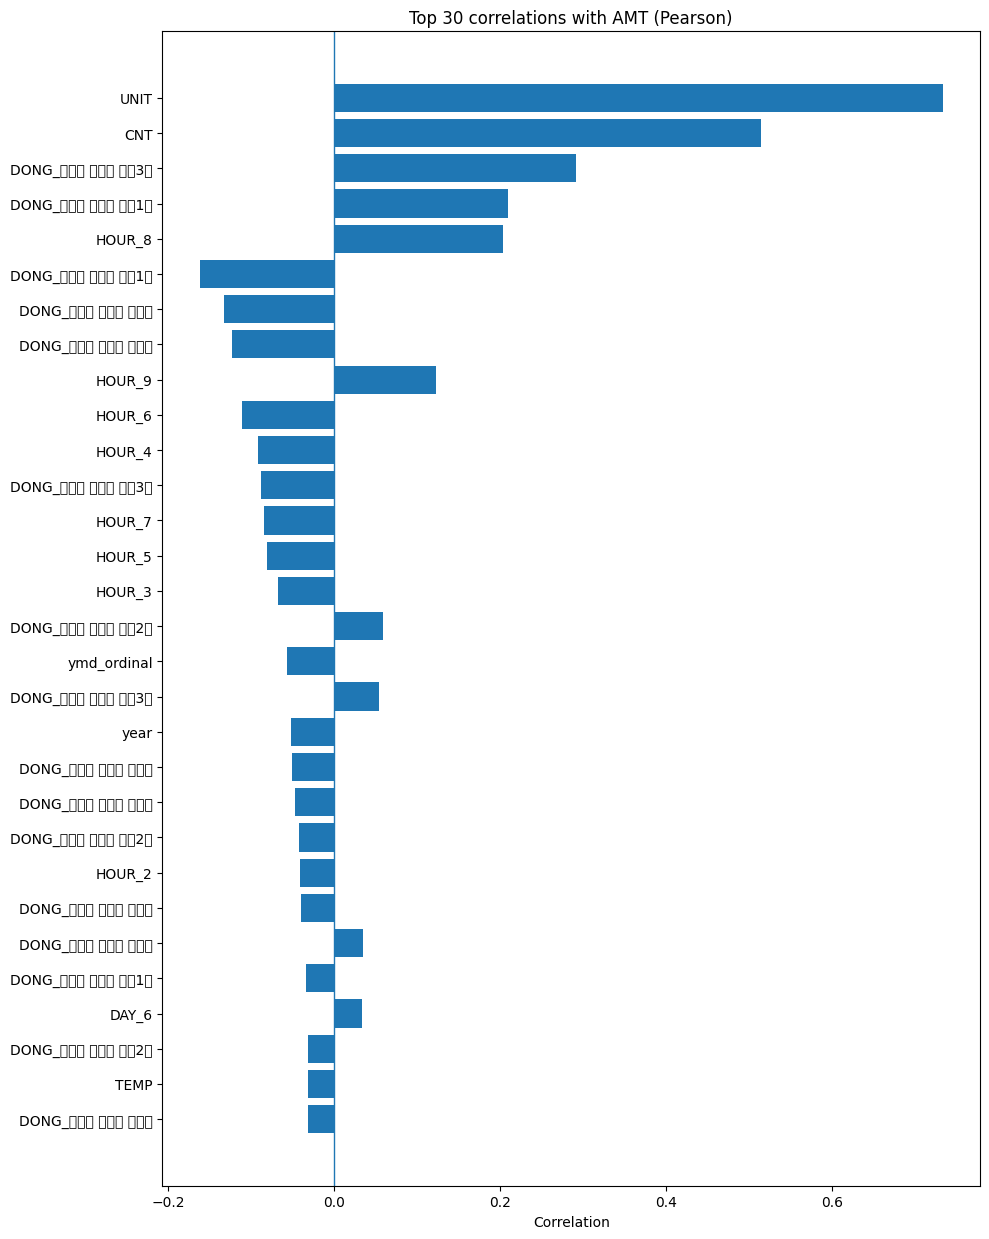

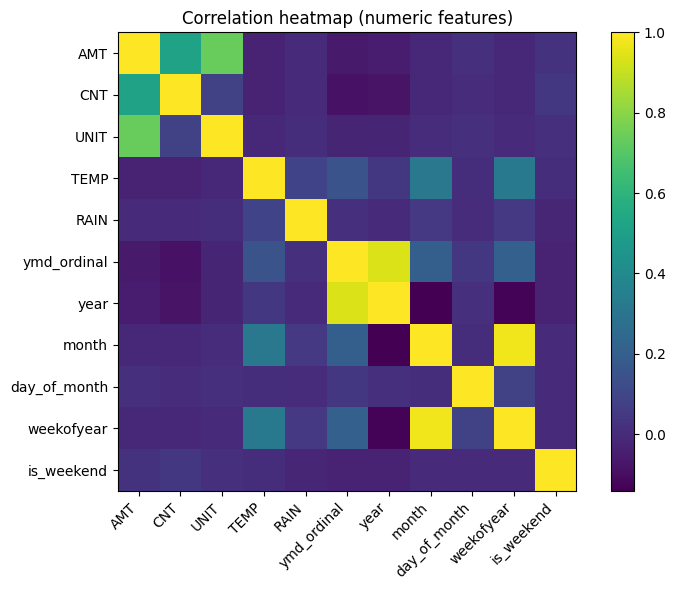

C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  plt.tight_layout()
C:\Users\rlagy\AppData\Local\Temp\ipykernel_9624\3303646930.py:121: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.tight_layout

C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlagy\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from curr

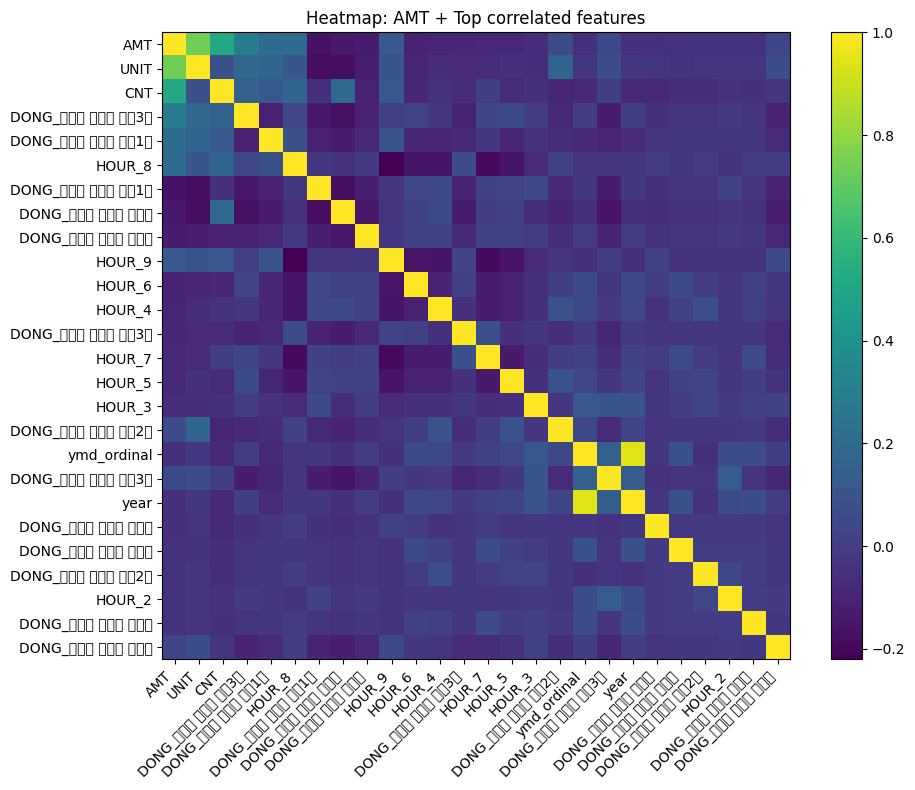


Saved:
- corr_with_amt.csv
- corr_top_bar.png
- corr_numeric_heatmap.png
- corr_top_heatmap.png


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 설정
# =========================
CSV_PATH = "data/수원시 배달 데이터백업.csv"   
TARGET = "AMT"

# 원핫인코딩할 범주형 컬럼(당신 데이터 기준)
CAT_COLS = ["DONG", "DAY", "HOUR", "R_GRADE"]

# =========================
# 1) 로드 & 기본 정리
# =========================
df = pd.read_csv(CSV_PATH)

# 날짜 파싱 (TA_YMD: yyyymmdd 정수/문자 형태 가정)
if "TA_YMD" in df.columns:
    df["TA_YMD"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")

# 타겟 존재 확인
assert TARGET in df.columns, f"TARGET={TARGET} 컬럼이 CSV에 없습니다."

# =========================
# 2) 날짜 파생 피처 (선택이지만 추천)
# =========================
if "TA_YMD" in df.columns:
    df["ymd_ordinal"] = df["TA_YMD"].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    df["year"] = df["TA_YMD"].dt.year
    df["month"] = df["TA_YMD"].dt.month
    df["day_of_month"] = df["TA_YMD"].dt.day
    # 주차(ISO week) - pandas 버전에 따라 dtype 처리
    df["weekofyear"] = df["TA_YMD"].dt.isocalendar().week.astype("Int64")

# 주말 여부 (DAY: 1~7 가정, 토=6 일=7)
if "DAY" in df.columns:
    df["is_weekend"] = df["DAY"].isin([6, 7]).astype(int)

# =========================
# 3) 원핫인코딩 + 상관 계산용 테이블 생성
# =========================
# TA_YMD는 datetime이라 그대로 두면 corr에서 제외되니, 원본은 제거(파생피처로 대체)
drop_cols = []
if "TA_YMD" in df.columns:
    drop_cols.append("TA_YMD")

base = df.drop(columns=drop_cols)

# get_dummies: CAT_COLS는 원핫, 나머지는 수치형 그대로
X = pd.get_dummies(base, columns=[c for c in CAT_COLS if c in base.columns], drop_first=False, dtype=float)

# 결측 처리(상관계수 계산은 pairwise로 되지만, 여기선 간단히 그대로 둠)
# 필요하면 아래 중 하나 선택:
# X = X.fillna(0)
# X = X.dropna()

# =========================
# 4) AMT와의 상관계수 (Pearson / Spearman)
# =========================
pearson = X.corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(key=lambda s: s.abs(), ascending=False)
spearman = X.corr(method="spearman", numeric_only=True)[TARGET].drop(TARGET).sort_values(key=lambda s: s.abs(), ascending=False)

# 결과 저장(선택)
out_corr = pd.DataFrame({
    "pearson": pearson,
    "spearman": spearman.reindex(pearson.index)  # 같은 순서로 맞춤
})
out_corr.to_csv("corr_with_amt.csv", encoding="utf-8-sig")

print("=== AMT 상관 Top 15 (|Pearson| 기준) ===")
print(out_corr.head(15))

# =========================
# 5) 시각화 1: AMT 상관 Top-N 막대그래프
# =========================
TOPN = 30
top = pearson.head(TOPN)[::-1]  # barh용 뒤집기

plt.figure(figsize=(10, 0.35*TOPN + 2))
plt.barh(top.index, top.values)
plt.axvline(0, linewidth=1)
plt.title(f"Top {TOPN} correlations with {TARGET} (Pearson)")
plt.xlabel("Correlation")
plt.tight_layout()
plt.savefig("corr_top_bar.png", dpi=200)
plt.show()

# =========================
# 6) 시각화 2: 수치형 컬럼들 히트맵(원핫 제외) - 전체 구조 파악용
# =========================
numeric_cols = [c for c in X.columns if not any(c.startswith(f"{cat}_") for cat in CAT_COLS if cat in base.columns)]
# 그래도 TARGET 포함해서 같이 봄
keep = [TARGET] + [c for c in numeric_cols if c != TARGET]
num_corr = X[keep].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(num_corr.values)
plt.xticks(range(len(num_corr.columns)), num_corr.columns, rotation=45, ha="right")
plt.yticks(range(len(num_corr.index)), num_corr.index)
plt.title("Correlation heatmap (numeric features)")
plt.colorbar()
plt.tight_layout()
plt.savefig("corr_numeric_heatmap.png", dpi=200)
plt.show()

# =========================
# 7) 시각화 3: AMT 상관 Top-N 피처들끼리 히트맵 (원핫 포함)
# =========================
top_features = list(pearson.head(25).index)  # 원핫 포함 Top 25
cols = [TARGET] + top_features
sub_corr = X[cols].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(sub_corr.values)
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title(f"Heatmap: {TARGET} + Top correlated features")
plt.colorbar()
plt.tight_layout()
plt.savefig("corr_top_heatmap.png", dpi=200)
plt.show()

print("\nSaved:")
print("- corr_with_amt.csv")
print("- corr_top_bar.png")
print("- corr_numeric_heatmap.png")
print("- corr_top_heatmap.png")


데이터 크기: (443523, 10)


,TA_YMD,DONG,HOUR,DAY,AMT,CNT,UNIT,TEMP,RAIN,R_GRADE
0,20230101,수원시 장안구 파장동,1,7,987830,17,58108,2.10,0.0,0.0
1,20230101,수원시 장안구 파장동,2,7,516279,20,25814,-0.20,0.0,0.0
2,20230101,수원시 장안구 파장동,3,7,2220711,76,29220,-2.25,0.0,0.0
3,20230101,수원시 장안구 파장동,4,7,9419194,230,40953,-3.20,0.0,0.0
4,20230101,수원시 장안구 파장동,5,7,17829061,364,48981,-4.10,0.0,0.0


수치형 컬럼 개수: 9
['TA_YMD', 'HOUR', 'DAY', 'AMT', 'CNT', 'UNIT', 'TEMP', 'RAIN', 'R_GRADE']


AMT        1.000000
CNT        0.873709
UNIT       0.187749
HOUR       0.095105
DAY        0.077364
TA_YMD     0.018862
R_GRADE   -0.004409
RAIN      -0.005054
TEMP      -0.037694
Name: AMT, dtype: float64

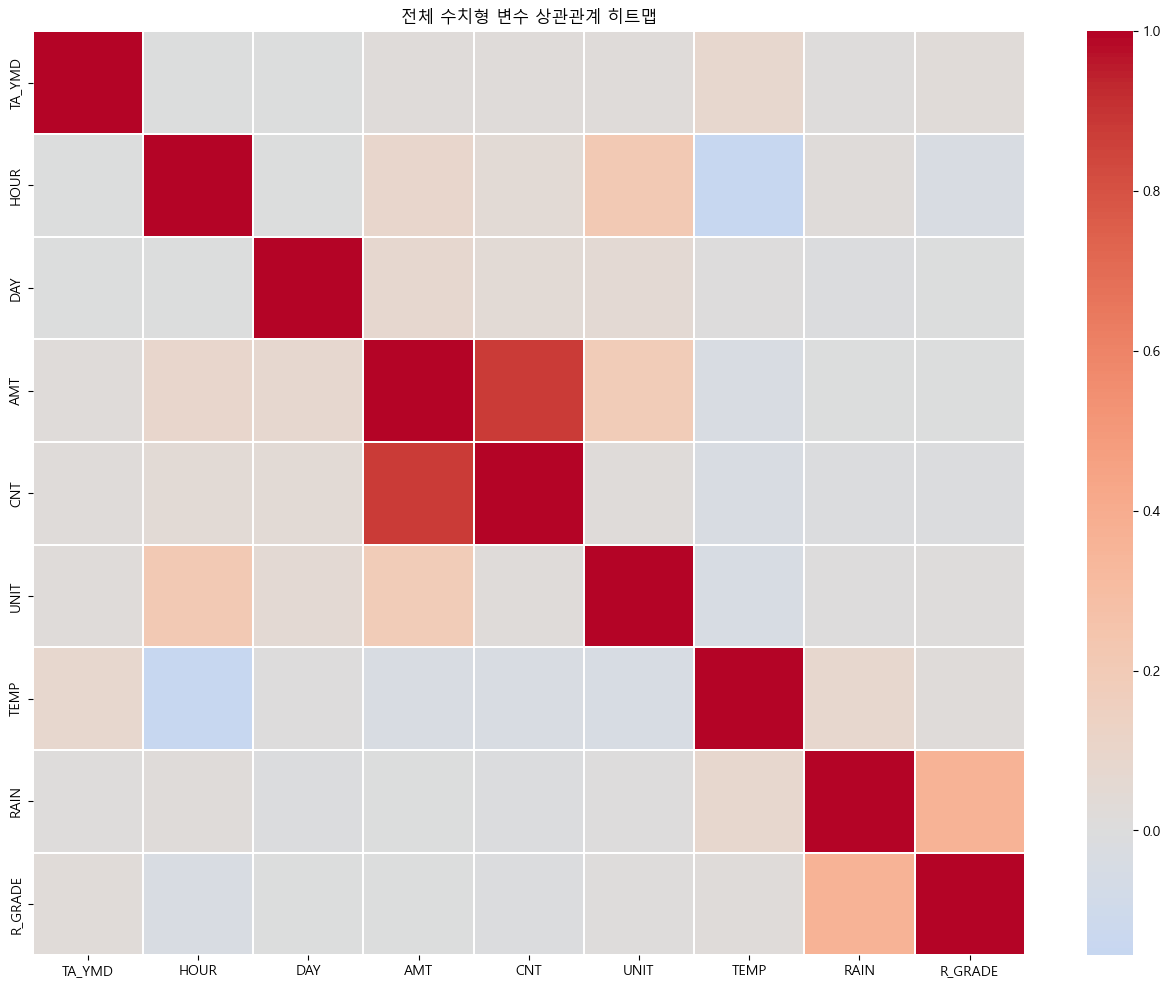

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 깨짐 방지 (Windows)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# =========================
# 1. 데이터 로드
# =========================
df = pd.read_csv(r"data/수원시 한식 데이터백업.csv")

print("데이터 크기:", df.shape)
display(df.head())

# =========================
# 2. 수치형 컬럼만 선택
# =========================
num_df = df.select_dtypes(include=[np.number])

print("수치형 컬럼 개수:", num_df.shape[1])
print(num_df.columns.tolist())

# =========================
# 3. 상관관계 계산
# =========================
corr = num_df.corr()


# =========================
# 4. AMT 기준 상관관계 정렬
# =========================
amt_corr = corr["AMT"].sort_values(ascending=False)

display(amt_corr)

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)
plt.title("전체 수치형 변수 상관관계 히트맵")
plt.show()


In [3]:
# =========================
# 5. 높은 상관 변수 쌍 찾기
# =========================
threshold = 0.8

high_corr_pairs = (
    corr.abs()
        .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
)

high_corr_pairs.columns = ["변수1", "변수2", "상관계수"]

high_corr_pairs = high_corr_pairs[
    high_corr_pairs["상관계수"] >= threshold
].sort_values("상관계수", ascending=False)

display(high_corr_pairs)


,변수1,변수2,상관계수
21,AMT,CNT,0.873709


## 수원시 한식 데이터

### 동과 매출간 상관관계

총 동 개수: 44개


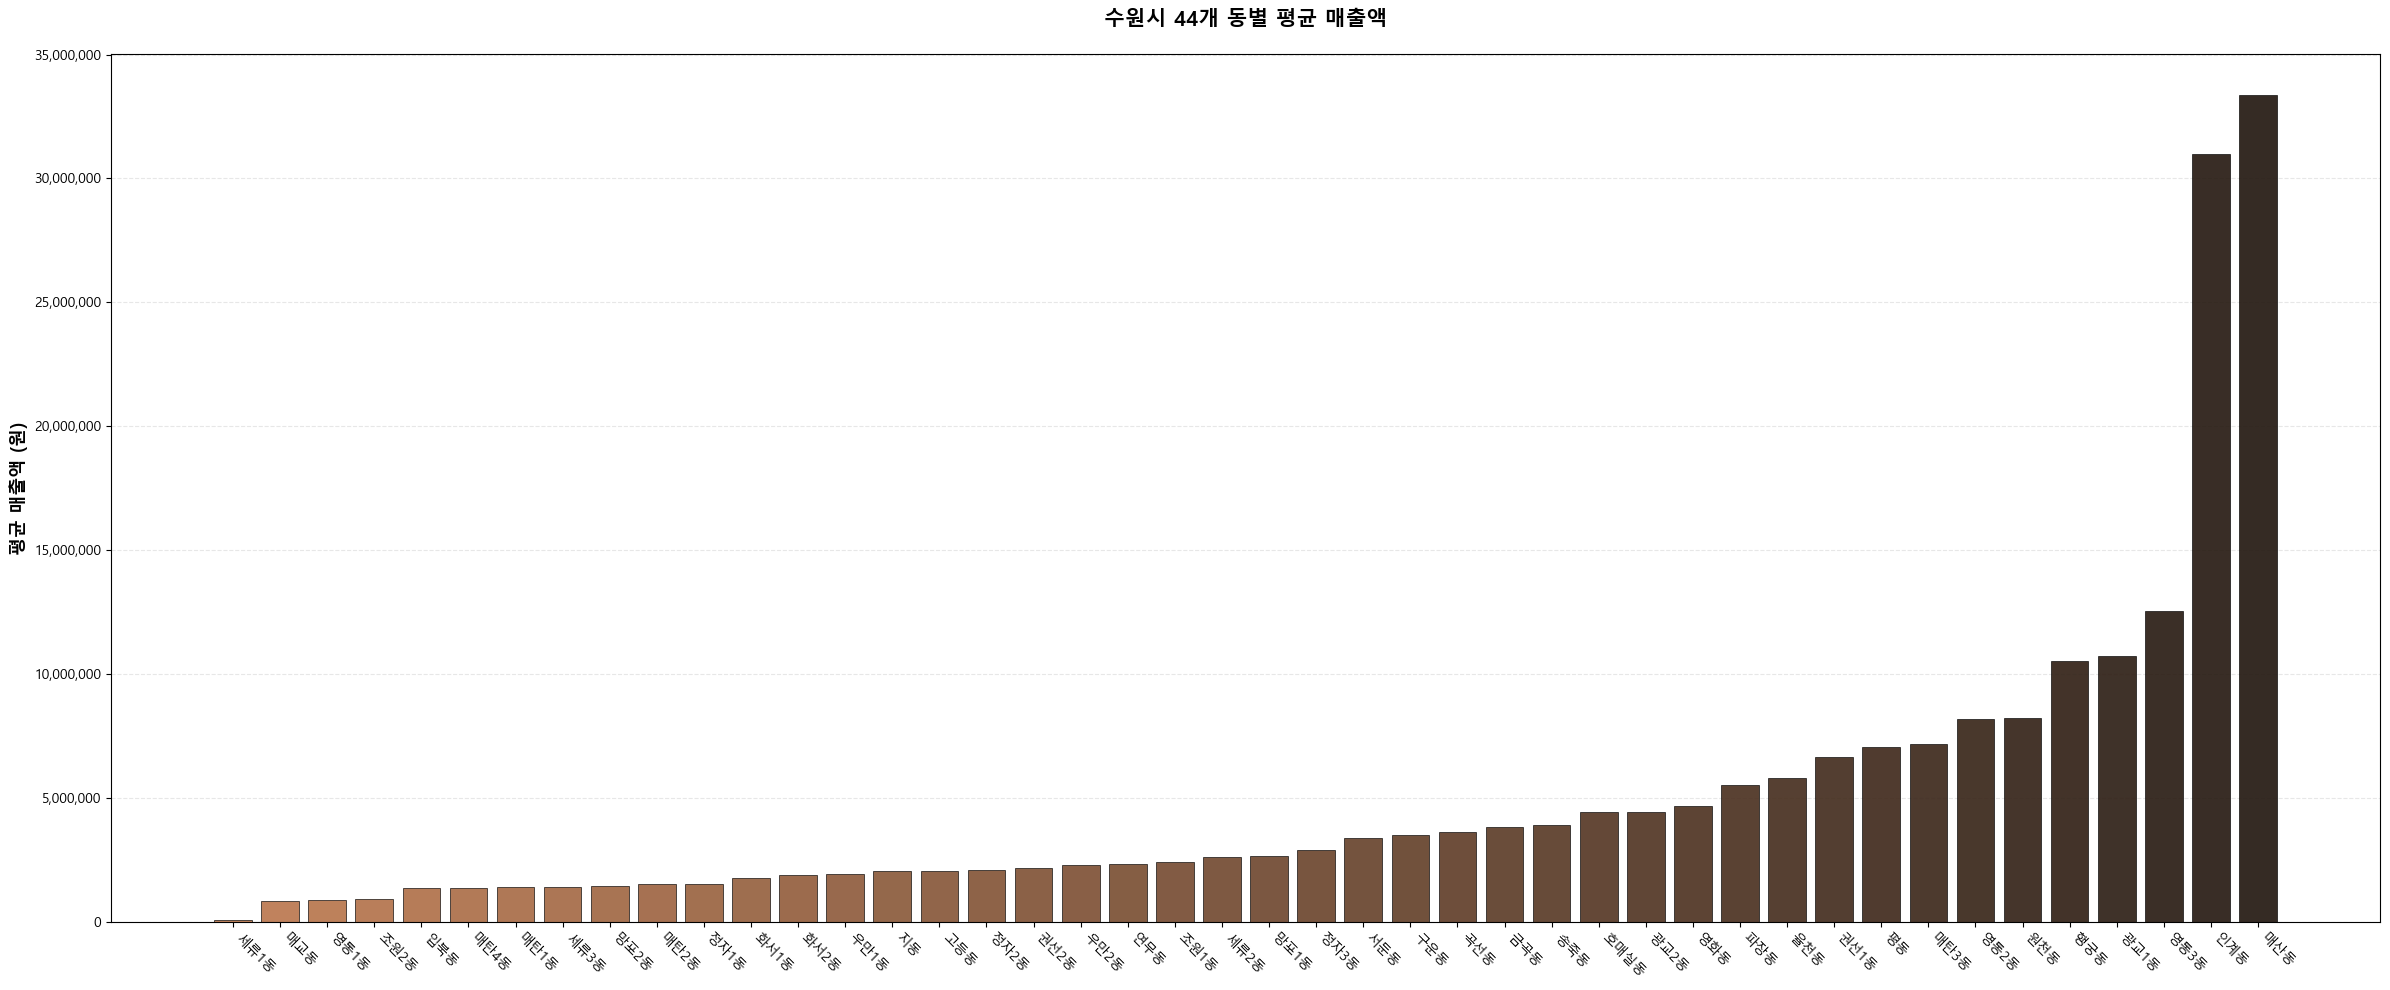

그래프 저장 완료!


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ===== 한글 폰트 설정 =====
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('data/수원시 한식 동별 데이터백업.csv')

# 동별 평균 매출액 계산 (오름차순 정렬)
dong_stats = df.groupby('DONG')['AMT'].mean().sort_values(ascending=True)

print(f"총 동 개수: {len(dong_stats)}개")

# 그래프 생성 (44개 동 전체) - 가로로 길게
fig, ax = plt.subplots(figsize=(24, 10))

# 색상 그라데이션
colors = plt.cm.copper_r(np.linspace(0.4, 0.9, len(dong_stats)))

# 세로 막대 그래프 
bars = ax.bar(range(len(dong_stats)), dong_stats.values, 
              color=colors, alpha=0.9, edgecolor='black', linewidth=0.5)

# x축 레이블 (동 이름)
ax.set_xticks(range(len(dong_stats)))
ax.set_xticklabels(dong_stats.index, fontsize=10, rotation=315, ha='left')

# y축 레이블
ax.set_ylabel('평균 매출액 (원)', fontsize=13, fontweight='bold')
ax.set_title('수원시 44개 동별 평균 매출액', fontsize=15, fontweight='bold', pad=20)

# 격자 추가
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# 각 막대 위에 값 표시
# for i, (dong, value) in enumerate(dong_stats.items()):
#     ax.text(i, value, f'{value:,.0f}', 
#             ha='center', va='bottom', fontsize=8, rotation=90)

# y축 포맷 (천 단위 구분)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# 레이아웃 조정
plt.tight_layout()

# 저장 및 표시
plt.savefig('dong_avg_amt_all_44.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장 완료!")

# 모델 학습

In [8]:
sw_X = sw_data.iloc[:,:-1]
sw_y = sw_data.iloc[:,-1]
sw_X.shape, sw_y.shape

((101513, 8), (101513,))

In [12]:
le = LabelEncoder()

sw_X['DONG_code'] = le.fit_transform(sw_X['DONG'])   # 새 숫자 컬럼
sw_X = sw_X.drop(columns=['DONG'])  

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

for train, test in tscv.split(sw_X):
    X_train, X_test = sw_X.iloc[train], sw_X.iloc[test]
    y_train, y_test = sw_y.iloc[train], sw_y.iloc[test]

    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, pred))

MAE: 61969.80921891931
MAE: 52584.15421381469
MAE: 41544.993122032734
MAE: 43963.04344594928
MAE: 42599.578318370295


## 가게매출 데이터 생성

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# 더미 가게 매출 데이터 생성
# ---------------------------
np.random.seed(42)

# 최근 60일 (사장님이 입력했다고 가정)
dates = pd.date_range("2025-08-01", "2025-12-24", freq="D")

# 가게 일매출 (임의 생성, 현실적인 범위)
# 평일 낮고 / 주말 조금 높게
sales = []
for d in dates:
    base = 120_000
    if d.weekday() >= 5:  # 주말
        base *= 1.2
    noise = np.random.normal(0, 20_000)
    sales.append(max(20_000, base + noise))

store_df = pd.DataFrame({
    "ta_ymd": dates.strftime("%Y%m%d").astype(int),
    "store_amt": sales
})

# 저장 경로 
out_path = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"
store_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"store_sales.csv 생성 완료 -> {out_path}")
print(store_df.head())


## 가게매출 데이터 생성2

In [9]:
"""
가게 매출 더미 데이터 생성 스크립트
- 최근 60일 데이터 생성
- 주말/평일 패턴 반영
- 공휴일 반영 (선택)
- 결과값 int 형식
"""

import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


def generate_store_sales(
    start_date: str = "2024-10-26",
    end_date: str = "2024-12-24", 
    base_weekday: int = 120_000,
    base_weekend: int = 144_000,
    noise_std: int = 20_000,
    holiday_multiplier: float = 1.3,
    min_sales: int = 20_000,
    seed: int = 42,
    output_path: str = None
):
    """
    가게 매출 더미 데이터 생성
    
    Parameters:
    - start_date: 시작일 (YYYY-MM-DD)
    - end_date: 종료일 (YYYY-MM-DD)
    - base_weekday: 평일 기본 매출
    - base_weekend: 주말 기본 매출 (기본값: 평일 * 1.2)
    - noise_std: 랜덤 노이즈 표준편차
    - holiday_multiplier: 공휴일 배율
    - min_sales: 최소 매출액
    - seed: 랜덤 시드
    - output_path: 저장 경로 (None이면 현재 디렉토리)
    
    Returns:
    - DataFrame
    """
    
    np.random.seed(seed)
    
    # 날짜 범위 생성
    dates = pd.date_range(start_date, end_date, freq="D")
    n_days = len(dates)
    
    print(f"\n{'='*70}")
    print(f"📊 가게 매출 더미 데이터 생성")
    print(f"{'='*70}")
    print(f"기간: {start_date} ~ {end_date} ({n_days}일)")
    print(f"평일 기본 매출: {base_weekday:,}원")
    print(f"주말 기본 매출: {base_weekend:,}원")
    print(f"노이즈 표준편차: ±{noise_std:,}원")
    
    # 공휴일 정의 (2024년 10월~12월)
    holidays = {
        "2024-10-03": "개천절",
        "2024-10-09": "한글날",
        "2024-12-25": "크리스마스",
    }
    
    sales = []
    is_holiday_list = []
    dow_list = []
    
    for date in dates:
        date_str = date.strftime("%Y-%m-%d")
        dow = date.dayofweek  # 0=월, 6=일
        
        # 기본 매출 결정
        if dow >= 5:  # 토, 일
            base = base_weekend
            day_type = "주말"
        else:
            base = base_weekday
            day_type = "평일"
        
        # 공휴일 체크
        is_holiday = date_str in holidays
        if is_holiday:
            base = int(base * holiday_multiplier)
            day_type = f"공휴일({holidays[date_str]})"
        
        # 랜덤 노이즈 추가
        noise = np.random.normal(0, noise_std)
        
        # 요일별 미세 조정 (월요일 낮음, 금요일 높음)
        if dow == 0:  # 월요일
            base *= 0.9
        elif dow == 4:  # 금요일
            base *= 1.05
        
        # 월말 효과 (25일 이후 약간 증가)
        if date.day >= 25:
            base *= 1.08
        
        # 최종 매출 계산
        daily_sales = int(max(min_sales, base + noise))
        
        sales.append(daily_sales)
        is_holiday_list.append(1 if is_holiday else 0)
        dow_list.append(dow)
    
    # DataFrame 생성
    df = pd.DataFrame({
        "date": dates,
        "ta_ymd": dates.strftime("%Y%m%d").astype(int),
        "dow": dow_list,
        "is_weekend": [1 if d >= 5 else 0 for d in dow_list],
        "is_holiday": is_holiday_list,
        "store_amt": sales
    })
    
    # 통계 출력
    print(f"\n{'='*70}")
    print("📈 생성된 데이터 통계")
    print(f"{'='*70}")
    print(f"총 일수: {len(df):,}일")
    print(f"평균 매출: {df['store_amt'].mean():,.0f}원")
    print(f"중앙값: {df['store_amt'].median():,.0f}원")
    print(f"표준편차: {df['store_amt'].std():,.0f}원")
    print(f"최소값: {df['store_amt'].min():,.0f}원")
    print(f"최대값: {df['store_amt'].max():,.0f}원")
    print(f"총 매출: {df['store_amt'].sum():,.0f}원")
    print(f"\n평일 평균: {df[df['is_weekend']==0]['store_amt'].mean():,.0f}원")
    print(f"주말 평균: {df[df['is_weekend']==1]['store_amt'].mean():,.0f}원")
    if df['is_holiday'].sum() > 0:
        print(f"공휴일 평균: {df[df['is_holiday']==1]['store_amt'].mean():,.0f}원")
    
    # 저장
    if output_path is None:
        output_path = "store_sales.csv"
    
    # 디렉토리 생성
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    # 기본 버전 (ta_ymd, store_amt만)
    df_simple = df[["ta_ymd", "store_amt"]].copy()
    df_simple.to_csv(output_path, index=False, encoding="utf-8-sig")
    
    # 상세 버전 (모든 컬럼 포함)
    detail_path = output_path.replace(".csv", "_detail.csv")
    df.to_csv(detail_path, index=False, encoding="utf-8-sig")
    
    print(f"\n{'='*70}")
    print("✅ 파일 저장 완료")
    print(f"{'='*70}")
    print(f"기본 버전: {output_path}")
    print(f"상세 버전: {detail_path}")
    
    # 샘플 데이터 출력
    print(f"\n{'='*70}")
    print("📋 데이터 샘플 (최근 10일)")
    print(f"{'='*70}")
    print(df.tail(10).to_string(index=False))
    
    return df


def main():
    """메인 실행 함수"""
    
    # 설정
    config = {
        "start_date": "2024-10-26",      # 시작일
        "end_date": "2024-12-24",        # 종료일
        "base_weekday": 120_000,         # 평일 기본 매출
        "base_weekend": 144_000,         # 주말 기본 매출 (평일의 1.2배)
        "noise_std": 20_000,             # 노이즈 표준편차
        "holiday_multiplier": 1.3,       # 공휴일 배율
        "min_sales": 20_000,             # 최소 매출
        "seed": 42,                      # 재현성을 위한 시드
        "output_path": "data/store_sales.csv"  # 저장 경로
    }
    
    # 데이터 생성
    df = generate_store_sales(**config)
    
    print(f"\n{'='*70}")
    print("🎉 완료!")
    print(f"{'='*70}\n")
    
    return df


if __name__ == "__main__":
    df = main()


📊 가게 매출 더미 데이터 생성
기간: 2024-10-26 ~ 2024-12-24 (60일)
평일 기본 매출: 120,000원
주말 기본 매출: 144,000원
노이즈 표준편차: ±20,000원

📈 생성된 데이터 통계
총 일수: 60일
평균 매출: 125,098원
중앙값: 129,378원
표준편차: 22,814원
최소값: 68,806원
최대값: 166,645원
총 매출: 7,505,905원

평일 평균: 119,364원
주말 평균: 138,478원

✅ 파일 저장 완료
기본 버전: data/store_sales.csv
상세 버전: data/store_sales_detail.csv

📋 데이터 샘플 (최근 10일)
      date   ta_ymd  dow  is_weekend  is_holiday  store_amt
2024-12-15 20241215    6           1           0     150481
2024-12-16 20241216    0           0           0     100298
2024-12-17 20241217    1           0           0     106461
2024-12-18 20241218    2           0           0     132233
2024-12-19 20241219    3           0           0     140619
2024-12-20 20241220    4           0           0     144625
2024-12-21 20241221    5           1           0     127215
2024-12-22 20241222    6           1           0     137815
2024-12-23 20241223    0           0           0     114625
2024-12-24 20241224    1           0           0   

In [11]:
df = generate_store_sales(
    start_date="2025-10-26",
    end_date="2025-12-24",
    base_weekday=150_000,      # 평일 15만원
    base_weekend=180_000,      # 주말 18만원
    noise_std=25_000,          # 노이즈 ±2.5만원
    holiday_multiplier=1.4,    # 공휴일 1.4배
    output_path="data/my_store.csv"
)


📊 가게 매출 더미 데이터 생성
기간: 2025-10-26 ~ 2025-12-24 (60일)
평일 기본 매출: 150,000원
주말 기본 매출: 180,000원
노이즈 표준편차: ±25,000원

📈 생성된 데이터 통계
총 일수: 60일
평균 매출: 155,903원
중앙값: 153,847원
표준편차: 29,488원
최소값: 101,008원
최대값: 219,480원
총 매출: 9,354,189원

평일 평균: 146,215원
주말 평균: 180,409원

✅ 파일 저장 완료
기본 버전: data/my_store.csv
상세 버전: data/my_store_detail.csv

📋 데이터 샘플 (최근 10일)
      date   ta_ymd  dow  is_weekend  is_holiday  store_amt
2025-12-15 20251215    0           0           0     143102
2025-12-16 20251216    1           0           0     140372
2025-12-17 20251217    2           0           0     133076
2025-12-18 20251218    3           0           0     165291
2025-12-19 20251219    4           0           0     183274
2025-12-20 20251220    5           1           0     203282
2025-12-21 20251221    6           1           0     159019
2025-12-22 20251222    0           0           0     127269
2025-12-23 20251223    1           0           0     158281
2025-12-24 20251224    2           0           0     174

## GPT1-1

In [22]:
# -*- coding: utf-8 -*-
"""
Option 2 (추천)
- 모델 피처: temp + rain_mean + rain_max + 파생(temp_clip, log) + calendar + holiday + lag/rolling
- 고객 출력: rain_max(피크) 중심으로 안내
- A 검증: 데이터 범위 내(<= daily_max_ymd)면 데이터에서 날씨 사용
- B 운영 준비: 데이터 범위 밖이면 getVilageFcst로 temp/rain_mean/rain_max 생성(준비만)
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_daily_amt_meanmax.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 7, 14, 28)
    rolling_windows: tuple = (7, 14, 28)

    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    # simple adjustment
    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    # KMA key env name
    service_key_env: str = "RAIN_ID"

CFG = Config()

# (예보용) nx, ny 매핑 (일단 동일)
DONG_TO_GRID = {k: (61, 121) for k in ["고등동","인계동","행궁동","매산동","매교동","우만1동","우만2동","지동","화서1동","화서2동"]}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# Holidays (2023-01-01 ~ 2025-10-31)
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()


# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    # 0~6 체계로 고정 (중복/혼선 방지)
    dow = int(date.dayofweek)  # 0=Mon ... 6=Sun
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    """원본 temp/rain_mean/rain_max는 daily에 이미 있으므로 여기서는 '파생'만 만든다."""
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)


# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    - amt: 일합
    - cnt: 일합
    - temp: 일평균
    - rain: 시간대 평균 강수량(네 정의) -> 일평균(rain_mean), 일최대(rain_max)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 2) lag/rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    return daily


# =========================
# 3) dataset build (✅ 중복 컬럼 완전 방지)
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)

    # ✅ 중복 컬럼 검사 (문제 있으면 여기서 바로 알림)
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp",
        "rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
    ]
    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"cnt_lag_{lag}", f"unit_lag_{lag}"]
    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std"]

    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    return data, feature_cols


# =========================
# 4) train (LightGBM)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.02,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("[Model] LightGBM (rain_mean + rain_max)")
    print(f"[Test] MAE   : {mae:,.0f}")
    print(f"[Test] WMAPE : {w:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"Saved -> {out_path}")

    return out_path


# =========================
# 5) (B 준비) forecast weather (VilageFcst)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다. .env에 {cfg.service_key_env}=... 넣어주세요.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')} (code={header.get('resultCode')})")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd} base={base_date}{base_time}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max


# =========================
# 6) store share + inference + customer demo
# =========================
def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    end_date = ymd_int_to_ts(target_ymd) - pd.Timedelta(days=1)
    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"]==dong) & (daily["date"]>=start_date) & (daily["date"]<=end_date)][["date","amt"]]
    store_hist = store[(store["date"]>=start_date) & (store["date"]<=end_date)][["date","store_amt"]]
    merged = dong_hist.merge(store_hist, on="date", how="inner")

    if len(merged) < cfg.min_overlap_days:
        return 0.0

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    # dong별 과거
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": np.nan,
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    last = tmp.iloc[[-1]].copy()
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v

    # final duplicate check
    dup = last.columns[last.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns in inference row: {dup}")

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, model_pack_path: str, cfg: Config):
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # A 검증: 데이터 날씨 사용 / B 운영 준비: 예보 사용
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment (가능하면)
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지 (rain_max 중심)
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm  ← 고객에게 보여줄 핵심")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv가 없거나 형식 오류 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }


# =========================
# MAIN: train + customer demo
# =========================
def main():
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # ===== 고객 입력 시나리오 =====
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())  # 예: 20251031 (A 검증)

    result = predict_customer_sales(customer_dong, customer_date, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5664
[LightGBM] [Info] Number of data points in the train set: 5624, number of used features: 40
[LightGBM] [Info] Start training from score 16.047767
[Model] LightGBM (rain_mean + rain_max)
[Test] MAE   : 2,157,716
[Test] WMAPE : 12.73%
Saved -> c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_daily_amt_meanmax.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.50 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 3,082,178 원
🏪가게 점유율(최근 56일): 4.605%
🏪보정계수(adj): 0.930
🏪예상 가게 일매출: 131,986 원

[RAW RESULT]
{'dong': '고등동', 'date': 20251031, 'temp': 13.6, 'rain_mean': 0.19, 'rain_max': 1.5, 'dong_pred': 3082177, 'share_pct': 4.605, 'store_pred': 131986, 'customer_message': '📍지역(동): 고등동\n📅날짜: 20251031\n🌦️날씨(출처): D

### 예측

In [26]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# 고객 입력 
result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251224,
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자

📍지역(동): 행궁동
📅날짜: 20251224
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): 0.7°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 59,040,949 원
🏪가게 점유율(최근 56일): 0.000%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 0 원
0


## GPT1-2

In [27]:
"""
Option 2 (추천)
- 모델 피처: temp + rain_mean + rain_max + 파생(temp_clip, log) + calendar + holiday + lag/rolling
- 고객 출력: rain_max(피크) 중심으로 안내
- A 검증: 데이터 범위 내(<= daily_max_ymd)면 데이터에서 날씨 사용
- B 운영 준비: 데이터 범위 밖이면 getVilageFcst로 temp/rain_mean/rain_max 생성(준비만)
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_daily_amt_meanmax.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 7, 14, 28)
    rolling_windows: tuple = (7, 14, 28)

    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    # simple adjustment
    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    # KMA key env name
    service_key_env: str = "RAIN_ID"

CFG = Config()

# (예보용) nx, ny 매핑 (일단 동일)
DONG_TO_GRID = {k: (61, 121) for k in ["고등동","인계동","행궁동","매산동","매교동","우만1동","우만2동","지동","화서1동","화서2동"]}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# Holidays (2023-01-01 ~ 2025-10-31)
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()


# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    # 0~6 체계로 고정 (중복/혼선 방지)
    dow = int(date.dayofweek)  # 0=Mon ... 6=Sun
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    """원본 temp/rain_mean/rain_max는 daily에 이미 있으므로 여기서는 '파생'만 만든다."""
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)


# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    - amt: 일합
    - cnt: 일합
    - temp: 일평균
    - rain: 시간대 평균 강수량(네 정의) -> 일평균(rain_mean), 일최대(rain_max)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 2) lag/rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    return daily


# =========================
# 3) dataset build (✅ 중복 컬럼 완전 방지)
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)

    # ✅ 중복 컬럼 검사 (문제 있으면 여기서 바로 알림)
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp",
        "rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
    ]
    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"cnt_lag_{lag}", f"unit_lag_{lag}"]
    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std"]

    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    return data, feature_cols


# =========================
# 4) train (LightGBM)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.02,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("[Model] LightGBM (rain_mean + rain_max)")
    print(f"[Test] MAE   : {mae:,.0f}")
    print(f"[Test] WMAPE : {w:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"Saved -> {out_path}")

    return out_path


# =========================
# 5) (B 준비) forecast weather (VilageFcst)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다. .env에 {cfg.service_key_env}=... 넣어주세요.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')} (code={header.get('resultCode')})")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd} base={base_date}{base_time}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max


# =========================
# 6) store share + inference + customer demo
# =========================
def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    """
    기존 문제:
    - target_ymd가 daily_max(예: 20251031)로 잡히면 end_date가 20251030 고정
    - store_sales가 최근 2개월(10~12월)만 있으면 겹치는 날짜가 부족 -> 0% 리턴

    개선:
    - end_date를 (target-1, daily_max, store_max) 중 가장 이른 날로 맞춰서 "겹치는 구간" 확보
    - 겹치는 날짜가 부족하면, 가능한 범위에서라도 계산 (0% 방지)
    """
    target_date = ymd_int_to_ts(target_ymd)

    # series max dates
    daily_max = daily["date"].max()
    store_max = store["date"].max()

    # ✅ end_date를 겹치는 범위로 자동 조정
    end_date = min(target_date - pd.Timedelta(days=1), daily_max, store_max)

    # 만약 end_date가 너무 과거/미래면 방어
    if pd.isna(end_date):
        return 0.0

    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"] == dong) & (daily["date"] >= start_date) & (daily["date"] <= end_date)][["date", "amt"]]
    store_hist = store[(store["date"] >= start_date) & (store["date"] <= end_date)][["date", "store_amt"]]

    merged = dong_hist.merge(store_hist, on="date", how="inner")

    # ✅ 디버그 (필요하면 print)
    # print(f"[share] target={target_date.date()} end={end_date.date()} start={start_date.date()} merged_days={len(merged)}")

    # 겹치는 날짜가 너무 없으면: 그래도 가능한 만큼으로 계산하되 최소 조건을 완화
    if len(merged) < cfg.min_overlap_days:
        # 가능한 기간 전체로라도 시도
        merged2 = daily[daily["dong"] == dong][["date","amt"]].merge(store[["date","store_amt"]], on="date", how="inner")
        merged2 = merged2.sort_values("date").tail(cfg.share_window_days)

        if len(merged2) < 3:  # 너무 없으면 진짜 0
            return 0.0

        denom = merged2["amt"].sum()
        if denom <= 0:
            return 0.0

        share = float(merged2["store_amt"].sum() / denom)
        return float(np.clip(share, 0.0, 0.2))

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    # dong별 과거
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": np.nan,
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    last = tmp.iloc[[-1]].copy()
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v

    # final duplicate check
    dup = last.columns[last.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns in inference row: {dup}")

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, model_pack_path: str, cfg: Config):
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # A 검증: 데이터 날씨 사용 / B 운영 준비: 예보 사용
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment (가능하면)
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지 (rain_max 중심)
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm  ← 고객에게 보여줄 핵심")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv가 없거나 형식 오류 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }


# =========================
# MAIN: train + customer demo
# =========================
def main():
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # ===== 고객 입력 시나리오 =====
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())  # 예: 20251031 (A 검증)

    result = predict_customer_sales(customer_dong, customer_date, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5664
[LightGBM] [Info] Number of data points in the train set: 5624, number of used features: 40
[LightGBM] [Info] Start training from score 16.047767
[Model] LightGBM (rain_mean + rain_max)
[Test] MAE   : 2,157,716
[Test] WMAPE : 12.73%
Saved -> c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_daily_amt_meanmax.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.50 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 3,082,178 원
🏪가게 점유율(최근 56일): 4.605%
🏪보정계수(adj): 0.930
🏪예상 가게 일매출: 131,986 원

[RAW RESULT]
{'dong': '고등동', 'date': 20251031, 'temp': 13.6, 'rain_mean': 0.19, 'rain_max': 1.5, 'dong_pred': 3082177, 'share_pct': 4.605, 'store_pred': 131986, 'customer_message': '📍지역(동): 고등동\n📅날짜: 20251031\n🌦️날씨(출처): D

### 예측

In [29]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# 고객 입력 
result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251225,
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자

📍지역(동): 행궁동
📅날짜: 20251225
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -3.8°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 59,509,103 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 174,583 원
174582


## GPT2

In [21]:
# suwon_paldal_hourly_sum_and_peak_v2_csv.py
# - history를 parquet 대신 CSV로 저장 (pyarrow/fastparquet 불필요)
# - MAE 개선: Tweedie objective + daily-sum MAE 기반 early stopping + lag/rolling 강화 + 파생피처

import os, re, json
import numpy as np
import pandas as pd
import requests
import lightgbm as lgb
import joblib
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Paths
# =========================
DATA_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_amt_lgbm_holiday_api_v2.pkl"
HIST_PATH  = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_history_v2.csv"  

# =========================
# KMA API 
# =========================
service_key_env: str = "RAIN_ID"
url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

# ✅ 수원시 팔달구 대표 격자
PALDAL_NX, PALDAL_NY = 61, 121

# =========================
# Time-bucket map (PDF 정의)
# 01: 00~06:59 / 02: 07~08:59 / ... / 10: 23~23:59
# =========================
BUCKETS = {
    1: list(range(0, 7)),
    2: [7, 8],
    3: [9, 10],
    4: [11, 12],
    5: [13, 14],
    6: [15, 16],
    7: [17, 18],
    8: [19, 20],
    9: [21, 22],
    10:[23],
}
BUCKET_LABEL = {
    1:"00:00~06:59", 2:"07:00~08:59", 3:"09:00~10:59", 4:"11:00~12:59", 5:"13:00~14:59",
    6:"15:00~16:59", 7:"17:00~18:59", 8:"19:00~20:59", 9:"21:00~22:59", 10:"23:00~23:59"
}

# =========================
# Holidays (Korea)
# =========================
def get_kr_holidays(years):
    """
    holidays 패키지 있으면 한국 공휴일 자동 생성.
    없으면 공휴일 없이 진행(주말은 is_weekend로 별도 처리).
    """
    try:
        import holidays  # pip install holidays
        kr = holidays.KR(years=years)
        return set(pd.to_datetime(list(kr.keys())))
    except Exception:
        return set()

def add_holiday_features(df: pd.DataFrame) -> pd.DataFrame:
    years = sorted(df["date"].dt.year.unique().tolist())
    hols = get_kr_holidays(years)

    d0 = df["date"].dt.normalize()
    df["is_holiday"] = d0.isin(hols).astype(int)
    df["is_holiday_prev"] = (d0 - pd.Timedelta(days=1)).isin(hols).astype(int)
    df["is_holiday_eve"]  = (d0 + pd.Timedelta(days=1)).isin(hols).astype(int)
    df["is_holiday_window3"] = ((df["is_holiday"]==1) | (df["is_holiday_prev"]==1) | (df["is_holiday_eve"]==1)).astype(int)
    return df

# =========================
# Feature engineering (hour-bucket level)
# =========================
def prepare_hourly_data(raw: pd.DataFrame) -> pd.DataFrame:
    raw = raw.copy()
    raw["date"] = pd.to_datetime(raw["TA_YMD"].astype(str), format="%Y%m%d")

    df = raw.copy()

    # calendar
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["dom"] = df["date"].dt.day
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    df = add_holiday_features(df)

    # 날씨 파생 (MAE 개선에 자주 도움)
    df["is_rain"] = (df["RAIN"] > 0).astype(int)
    df["rain_log1p"] = np.log1p(df["RAIN"].clip(lower=0))
    # temp bin (너무 세분화하지 않게 5도 단위)
    df["temp_bin"] = (np.floor(df["TEMP"] / 5) * 5).astype(int)
    df["temp_x_rain"] = df["TEMP"] * df["is_rain"]

    # lag/rolling by (DONG, HOUR)
    df = df.sort_values(["DONG", "HOUR", "date"])
    g = df.groupby(["DONG","HOUR"], sort=False)

    # ✅ lag 강화
    for lag in [1, 3, 7, 14, 28]:
        df[f"amt_lag{lag}"] = g["AMT"].shift(lag)
        df[f"cnt_lag{lag}"] = g["CNT"].shift(lag)
        df[f"temp_lag{lag}"] = g["TEMP"].shift(lag)
        df[f"rain_lag{lag}"] = g["RAIN"].shift(lag)

    # ✅ rolling 강화 (shift(1) 기반)
    def _roll_mean(s, w):
        return s.shift(1).rolling(w, min_periods=1).mean()

    for w in [7, 14, 28]:
        df[f"amt_roll{w}"] = g["AMT"].transform(lambda s, w=w: _roll_mean(s, w))
        df[f"cnt_roll{w}"] = g["CNT"].transform(lambda s, w=w: _roll_mean(s, w))

    # ✅ 같은 요일(dow) 최근 8주 평균 (동×시간×요일 패턴 강화)
    df["dow_key"] = df["dow"].astype(int)
    g2 = df.groupby(["DONG","HOUR","dow_key"], sort=False)
    df["amt_dow_mean8w"] = g2["AMT"].shift(1).transform(lambda s: s.rolling(8, min_periods=1).mean())
    df["cnt_dow_mean8w"] = g2["CNT"].shift(1).transform(lambda s: s.rolling(8, min_periods=1).mean())

    # (2) Interaction features (날씨×캘린더)
    df["temp_x_weekend"] = df["TEMP"] * df["is_weekend"]
    df["rain_x_weekend"] = df["RAIN"] * df["is_weekend"]
    df["temp_x_holiday"] = df["TEMP"] * df["is_holiday_window3"]
    df["rain_x_holiday"] = df["RAIN"] * df["is_holiday_window3"]

    # target (log1p)
    df["y"] = np.log1p(df["AMT"])

    # drop early rows: 최소 lag1 존재해야 예측 안정
    df = df.dropna(subset=["amt_lag1","cnt_lag1"]).copy()

    # UNIT 결측 처리(학습용): 동×시간대의 최근/평균으로 채움
    if "UNIT" in df.columns:
        df["UNIT"] = df["UNIT"].astype(float)
        df["UNIT"] = g["UNIT"].transform(lambda s: s.fillna(method="ffill").fillna(s.mean()).fillna(0.0))

    return df

# =========================
# Feature columns
# =========================
FEATURE_COLS = [
    "DONG","HOUR",
    "TEMP","RAIN","UNIT",
    "dow","month","dom","week","is_weekend",
    "is_holiday","is_holiday_prev","is_holiday_eve","is_holiday_window3",
    "is_rain","rain_log1p","temp_bin","temp_x_rain",
    "temp_x_weekend","rain_x_weekend","temp_x_holiday","rain_x_holiday",
    "amt_dow_mean8w","cnt_dow_mean8w",
    # lags
    "amt_lag1","amt_lag3","amt_lag7","amt_lag14","amt_lag28",
    "cnt_lag1","cnt_lag3","cnt_lag7","cnt_lag14","cnt_lag28",
    "temp_lag1","temp_lag7","rain_lag1","rain_lag7",
    # rolls
    "amt_roll7","amt_roll14","amt_roll28",
    "cnt_roll7","cnt_roll14","cnt_roll28",
]

# =========================
# Daily-sum MAE eval (중요)
# =========================
def daily_sum_mae(te_df: pd.DataFrame, pred_amt_hour: np.ndarray) -> float:
    tmp = te_df[["DONG","date","AMT"]].copy()
    tmp["pred"] = pred_amt_hour
    true_daily = tmp.groupby(["DONG","date"], as_index=False)["AMT"].sum()["AMT"].values
    pred_daily = tmp.groupby(["DONG","date"], as_index=False)["pred"].sum()["pred"].values
    return mean_absolute_error(true_daily, pred_daily)

# =========================
# Train & Evaluate
# - Holdout: last N days
# - 출력: (A) 시간대 MAE, (B) 일합계 MAE
# - 저장: 모델 + history(csv)
# =========================
def train_and_eval(test_days=30):
    raw = pd.read_csv(DATA_PATH)
    df = prepare_hourly_data(raw)

    max_date = df["date"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)

    tr = df[df["date"] <= cutoff].copy()
    te = df[df["date"] > cutoff].copy()

    X_tr, y_tr = tr[FEATURE_COLS].copy(), tr["y"].copy()
    X_te, y_te = te[FEATURE_COLS].copy(), te["y"].copy()

    for c in ["DONG","HOUR"]:
        X_tr[c] = X_tr[c].astype("category")
        X_te[c] = X_te[c].astype("category")

    # ✅ Tweedie: 매출(양수/0 + heavy tail)에 자주 유리
    model = lgb.LGBMRegressor(
        objective="tweedie",
        tweedie_variance_power=1.2,  # 1.1~1.4 사이에서 성능차 날 수 있음
        metric="mae",
        n_estimators=8000,
        learning_rate=0.02,
        num_leaves=255,
        min_data_in_leaf=30,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.85,
        reg_alpha=0.2,
        reg_lambda=0.2,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_te, y_te)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(300, verbose=False)]
    )

    pred_amt_hour = np.expm1(model.predict(X_te))
    true_amt_hour = te["AMT"].values
    mae_hour = mean_absolute_error(true_amt_hour, pred_amt_hour)
    mae_daily = daily_sum_mae(te, pred_amt_hour)

    print(f"[HOLDOUT last {test_days} days] MAE(시간대 AMT): {mae_hour:,.0f}")
    print(f"[HOLDOUT last {test_days} days] MAE(일합계 AMT): {mae_daily:,.0f}")
    print("Best iteration:", getattr(model, "best_iteration_", None))

    joblib.dump({"model": model, "feature_cols": FEATURE_COLS}, MODEL_PATH)

    # ✅ parquet 대신 CSV 저장 (엔진 불필요)
    df.to_csv(HIST_PATH, index=False, encoding="utf-8-sig")

    print("Saved:", MODEL_PATH)
    print("Saved history (csv):", HIST_PATH)

# =========================
# Weather API helpers
# =========================
def _pick_base_datetime(target_date: datetime) -> tuple[str, str]:
    base_dt = target_date - timedelta(days=1)
    return base_dt.strftime("%Y%m%d"), "2300"

def _pcp_to_float(v) -> float:
    if v is None:
        return 0.0
    s = str(v).strip()
    if s in ["강수없음","없음","-","0","0mm"]:
        return 0.0
    if "미만" in s:
        return 0.5
    m = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if not m:
        return 0.0
    return float(m[0])

def fetch_hourly_weather_from_api(date_str: str, nx=PALDAL_NX, ny=PALDAL_NY) -> pd.DataFrame:
    sk = os.getenv(service_key_env)
    if not sk:
        raise RuntimeError(f"환경변수 {service_key_env} 에 serviceKey를 넣어주세요. 예) setx {service_key_env} \"...\"")

    target_date = datetime.strptime(date_str, "%Y-%m-%d")
    base_date, base_time = _pick_base_datetime(target_date)

    # 요청하신 형태 포함
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "serviceKey": sk,
        "pageNo": 1,
        "numOfRows": 3000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()

    items = js["response"]["body"]["items"]["item"]
    target_ymd = target_date.strftime("%Y%m%d")

    rows = []
    for it in items:
        if it.get("fcstDate") != target_ymd:
            continue
        cat = it.get("category")
        if cat not in ["TMP","PCP"]:
            continue
        rows.append({
            "fcstTime": int(it["fcstTime"]) // 100,  # 0~23
            "category": cat,
            "value": it["fcstValue"]
        })

    if not rows:
        raise RuntimeError("해당 날짜 예보를 못 가져왔습니다. base_time/nx/ny 또는 API 응답을 확인하세요.")

    df = pd.DataFrame(rows)
    tmp = df[df["category"]=="TMP"][["fcstTime","value"]].rename(columns={"value":"TMP"})
    pcp = df[df["category"]=="PCP"][["fcstTime","value"]].rename(columns={"value":"PCP"})

    out = tmp.merge(pcp, on="fcstTime", how="left")
    out["TMP"] = out["TMP"].astype(float)
    out["PCP"] = out["PCP"].apply(_pcp_to_float).fillna(0.0)
    return out.sort_values("fcstTime").reset_index(drop=True)

def aggregate_to_buckets(hourly_weather: pd.DataFrame):
    overall_rain_mean = float(hourly_weather["PCP"].mean())
    overall_rain_max  = float(hourly_weather["PCP"].max())

    bucket_weather = {}
    for h, hours in BUCKETS.items():
        sub = hourly_weather[hourly_weather["fcstTime"].isin(hours)]
        if len(sub) == 0:
            bucket_weather[h] = {"TEMP": float(hourly_weather["TMP"].mean()),
                                 "RAIN": 0.0,
                                 "RAIN_MEAN": 0.0,
                                 "RAIN_MAX": 0.0}
        else:
            bucket_weather[h] = {
                "TEMP": float(sub["TMP"].mean()),
                "RAIN": float(sub["PCP"].sum()),
                "RAIN_MEAN": float(sub["PCP"].mean()),
                "RAIN_MAX": float(sub["PCP"].max()),
            }

    return bucket_weather, overall_rain_mean, overall_rain_max

# =========================
# Build features for one (dong, date, hour_bucket)
# =========================
def load_history_csv():
    hist = pd.read_csv(HIST_PATH)
    # 저장된 date는 문자열일 수 있음
    hist["date"] = pd.to_datetime(hist["date"])
    return hist

def build_features_for_one(dong: str, date: pd.Timestamp, hour_bucket: int,
                           hist: pd.DataFrame, w: dict) -> pd.DataFrame:
    row = pd.DataFrame([{
        "DONG": dong,
        "HOUR": hour_bucket,
        "date": date,
        "TEMP": w["TEMP"],
        "RAIN": w["RAIN"],
        "UNIT": np.nan,
    }])

    # calendar + holiday
    row["dow"] = row["date"].dt.dayofweek
    row["month"] = row["date"].dt.month
    row["dom"] = row["date"].dt.day
    row["week"] = row["date"].dt.isocalendar().week.astype(int)
    row["is_weekend"] = (row["dow"] >= 5).astype(int)
    row = add_holiday_features(row)

    # weather derived
    row["is_rain"] = (row["RAIN"] > 0).astype(int)
    row["rain_log1p"] = np.log1p(row["RAIN"].clip(lower=0))
    row["temp_bin"] = (np.floor(row["TEMP"] / 5) * 5).astype(int)
    row["temp_x_rain"] = row["TEMP"] * row["is_rain"]

    # interactions
    row["temp_x_weekend"] = row["TEMP"] * row["is_weekend"]
    row["rain_x_weekend"] = row["RAIN"] * row["is_weekend"]
    row["temp_x_holiday"] = row["TEMP"] * row["is_holiday_window3"]
    row["rain_x_holiday"] = row["RAIN"] * row["is_holiday_window3"]

    # history for same (DONG,HOUR)
    h = hist[(hist["DONG"]==dong) & (hist["HOUR"]==hour_bucket)].sort_values("date")
    h = h[h["date"] < date].copy()

    def lag(col, n):
        if len(h) < n:
            return np.nan
        return float(h.iloc[-n][col])

    # lags
    row["amt_lag1"]  = lag("AMT", 1)
    row["amt_lag3"]  = lag("AMT", 3)
    row["amt_lag7"]  = lag("AMT", 7)
    row["amt_lag14"] = lag("AMT", 14)
    row["amt_lag28"] = lag("AMT", 28)

    row["cnt_lag1"]  = lag("CNT", 1)
    row["cnt_lag3"]  = lag("CNT", 3)
    row["cnt_lag7"]  = lag("CNT", 7)
    row["cnt_lag14"] = lag("CNT", 14)
    row["cnt_lag28"] = lag("CNT", 28)

    row["temp_lag1"] = lag("TEMP", 1)
    row["temp_lag7"] = float(h["TEMP"].tail(7).mean()) if len(h) >= 7 else np.nan
    row["rain_lag1"] = lag("RAIN", 1)
    row["rain_lag7"] = float(h["RAIN"].tail(7).mean()) if len(h) >= 7 else np.nan

    # rolls
    row["amt_roll7"]  = float(h["AMT"].tail(7).mean()) if len(h)>=1 else np.nan
    row["amt_roll14"] = float(h["AMT"].tail(14).mean()) if len(h)>=1 else np.nan
    row["amt_roll28"] = float(h["AMT"].tail(28).mean()) if len(h)>=1 else np.nan

    row["cnt_roll7"]  = float(h["CNT"].tail(7).mean()) if len(h)>=1 else np.nan
    row["cnt_roll14"] = float(h["CNT"].tail(14).mean()) if len(h)>=1 else np.nan
    row["cnt_roll28"] = float(h["CNT"].tail(28).mean()) if len(h)>=1 else np.nan

    # same weekday mean (최근 8주)
    if len(h) >= 1:
        h2 = h.copy()
        h2["dow_key"] = h2["date"].dt.dayofweek.astype(int)
        sub = h2[h2["dow_key"] == int(row["dow"].iloc[0])]
        row["amt_dow_mean8w"] = float(sub["AMT"].tail(8).mean()) if len(sub) >= 1 else row["amt_roll28"].iloc[0]
        row["cnt_dow_mean8w"] = float(sub["CNT"].tail(8).mean()) if len(sub) >= 1 else row["cnt_roll28"].iloc[0]
    else:
        row["amt_dow_mean8w"] = np.nan
        row["cnt_dow_mean8w"] = np.nan

    # UNIT 결측 대체(동/시간 최근30 평균)
    if row["UNIT"].isna().any():
        if "UNIT" in h.columns and h["UNIT"].notna().any():
            row["UNIT"] = float(h["UNIT"].dropna().tail(30).mean())
        else:
            row["UNIT"] = 0.0

    # categorical
    row["DONG"] = row["DONG"].astype("category")
    row["HOUR"] = row["HOUR"].astype("category")

    # 최소 조건
    if row[["amt_lag1","cnt_lag1"]].isna().any().any():
        raise RuntimeError(f"{dong} / HOUR={hour_bucket} 의 과거 이력이 부족해서 예측이 어렵습니다(최소 전일 필요).")

    return row

# =========================
# Predict: input = DONG + date
# output = bucket preds + daily sum + peak bucket + rain stats
# =========================
def predict_sum_and_peak(dong: str, date_str: str, nx=PALDAL_NX, ny=PALDAL_NY):
    bundle = joblib.load(MODEL_PATH)
    model = bundle["model"]
    feature_cols = bundle["feature_cols"]
    hist = load_history_csv()

    # 1) API 날씨(시간별) -> 버킷으로 집계
    hourly_weather = fetch_hourly_weather_from_api(date_str, nx=nx, ny=ny)
    bucket_weather, rain_mean, rain_max = aggregate_to_buckets(hourly_weather)

    # 2) 10개 시간대 예측
    date = pd.to_datetime(date_str)
    preds = []
    for hb in range(1, 11):
        w = bucket_weather[hb]
        row = build_features_for_one(dong, date, hb, hist, w)
        X = row[feature_cols]
        pred_amt = float(np.expm1(model.predict(X)[0]))
        preds.append((hb, pred_amt, w))

    # 3) 합계/피크
    total = sum(p for _, p, _ in preds)
    peak_hb, peak_amt, _ = max(preds, key=lambda x: x[1])

    return total, (peak_hb, peak_amt), preds, (rain_mean, rain_max)

# =========================
# Run
# =========================
if __name__ == "__main__":
    # 0) 학습 + 오차 확인
    train_and_eval(test_days=30)

    # 1) 사용자 입력: 동/날짜만
    dong = input("동(DONG)을 입력하세요: ").strip()
    date_str = input("날짜(YYYY-MM-DD)를 입력하세요: ").strip()

    total, (peak_hb, peak_amt), preds, (rain_mean, rain_max) = predict_sum_and_peak(
        dong, date_str, nx=PALDAL_NX, ny=PALDAL_NY
    )

    print("\n=== 팔달구 격자(nx,ny) ===")
    print(f"nx={PALDAL_NX}, ny={PALDAL_NY}")

    print("\n=== 강수(PCP) 통계 (API 기반, 시간별 예보) ===")
    print(f"RAIN mean: {rain_mean:.2f} mm, RAIN max: {rain_max:.2f} mm")

    print("\n=== 시간대별 예측(AMT) ===")
    for hb, amt, w in preds:
        print(f"HOUR {hb:02d} ({BUCKET_LABEL[hb]}): {amt:,.0f} | TEMP≈{w['TEMP']:.1f}°C, RAIN(sum)={w['RAIN']:.1f}mm")

    print("\n=== 최종 결과 ===")
    print(f"[일매출 합계 예측] {total:,.0f}")
    print(f"[피크 시간대] HOUR {peak_hb:02d} ({BUCKET_LABEL[peak_hb]}) / {peak_amt:,.0f}")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 7081
[LightGBM] [Info] Number of data points in the train set: 98467, number of used features: 44
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Start training from score 2.577303
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[HOLDOUT last 30 days] MAE(시간대 AMT): 318,804
[HOLDOUT last 30 days] MAE(일합계 AMT): 2,325,130
Best iteration: 2772
Saved: c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_amt_lgbm_holiday_api_v2.pkl
Saved history (csv): c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_history_v2.csv
동(DONG)을 입력하세요: 행궁동
날짜(YYYY-

## Claude


               Random Forest Regressor
          수원시 팔달구 매출 예측 모델
데이터 로드 중...

✓ 데이터 크기: (101513, 7)
✓ 총 레코드 수: 101,513개

컬럼 정보:
['기준년월일', '행정동명', '시간대', '요일', '매출금액', '매출건수', '객단가']

✓ 행정동 수: 10개
✓ 행정동 목록: 고등동, 매교동, 매산동, 우만1동, 우만2동, 인계동, 지동, 행궁동, 화서1동, 화서2동

피처 준비 중...

✓ 피처 개수: 8개
✓ 피처 목록: ['행정동_코드', '시간대', '요일', '년', '월', '일', '매출건수', '객단가']
✓ 타겟 변수: 매출금액

데이터 분할 중...

✓ 학습 데이터: 81,210개 (80.0%)
✓ 테스트 데이터: 20,303개 (20.0%)

Random Forest 모델 학습 중...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



✓ 모델 학습 완료!

모델 평가 중...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



[학습 데이터 성능]
  RMSE  :      134,446.32 원
  MAE   :       31,194.21 원
  R²    :        0.997741 (99.7741%)

[테스트 데이터 성능]
  RMSE  :      261,594.31 원
  MAE   :       72,509.60 원
  R²    :        0.991373 (99.1373%)

[과적합 검사]
  ✓ 과적합 없음 (학습/테스트 성능 차이 < 5%)

5-Fold 교차 검증 수행 중...

교차 검증 R² 점수:
  Fold 1: 0.980429
  Fold 2: 0.986454
  Fold 3: 0.989445
  Fold 4: 0.984334
  Fold 5: 0.972178

평균 R²: 0.982568 (± 0.005967)

특성 중요도 분석


    특성      중요도
  매출건수 0.619437
   객단가 0.192256
   시간대 0.073071
행정동_코드 0.072356
    요일 0.024788
     일 0.007433
     월 0.007128
     년 0.003532

시각화 생성 중...

✓ 시각화 저장 완료: random_forest_visualization.png

모델 저장 중...

✓ 모델 저장 완료: rf_sales_model.pkl

예측 예시

입력 조건:
  - 행정동: 인계동
  - 시간대: 5시
  - 요일: 금요일
  - 날짜: 2025년 12월 24일
  - 매출건수: 100건
  - 객단가: 8,000원

예측 매출금액: 1,146,480원

✓ 모든 작업 완료!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


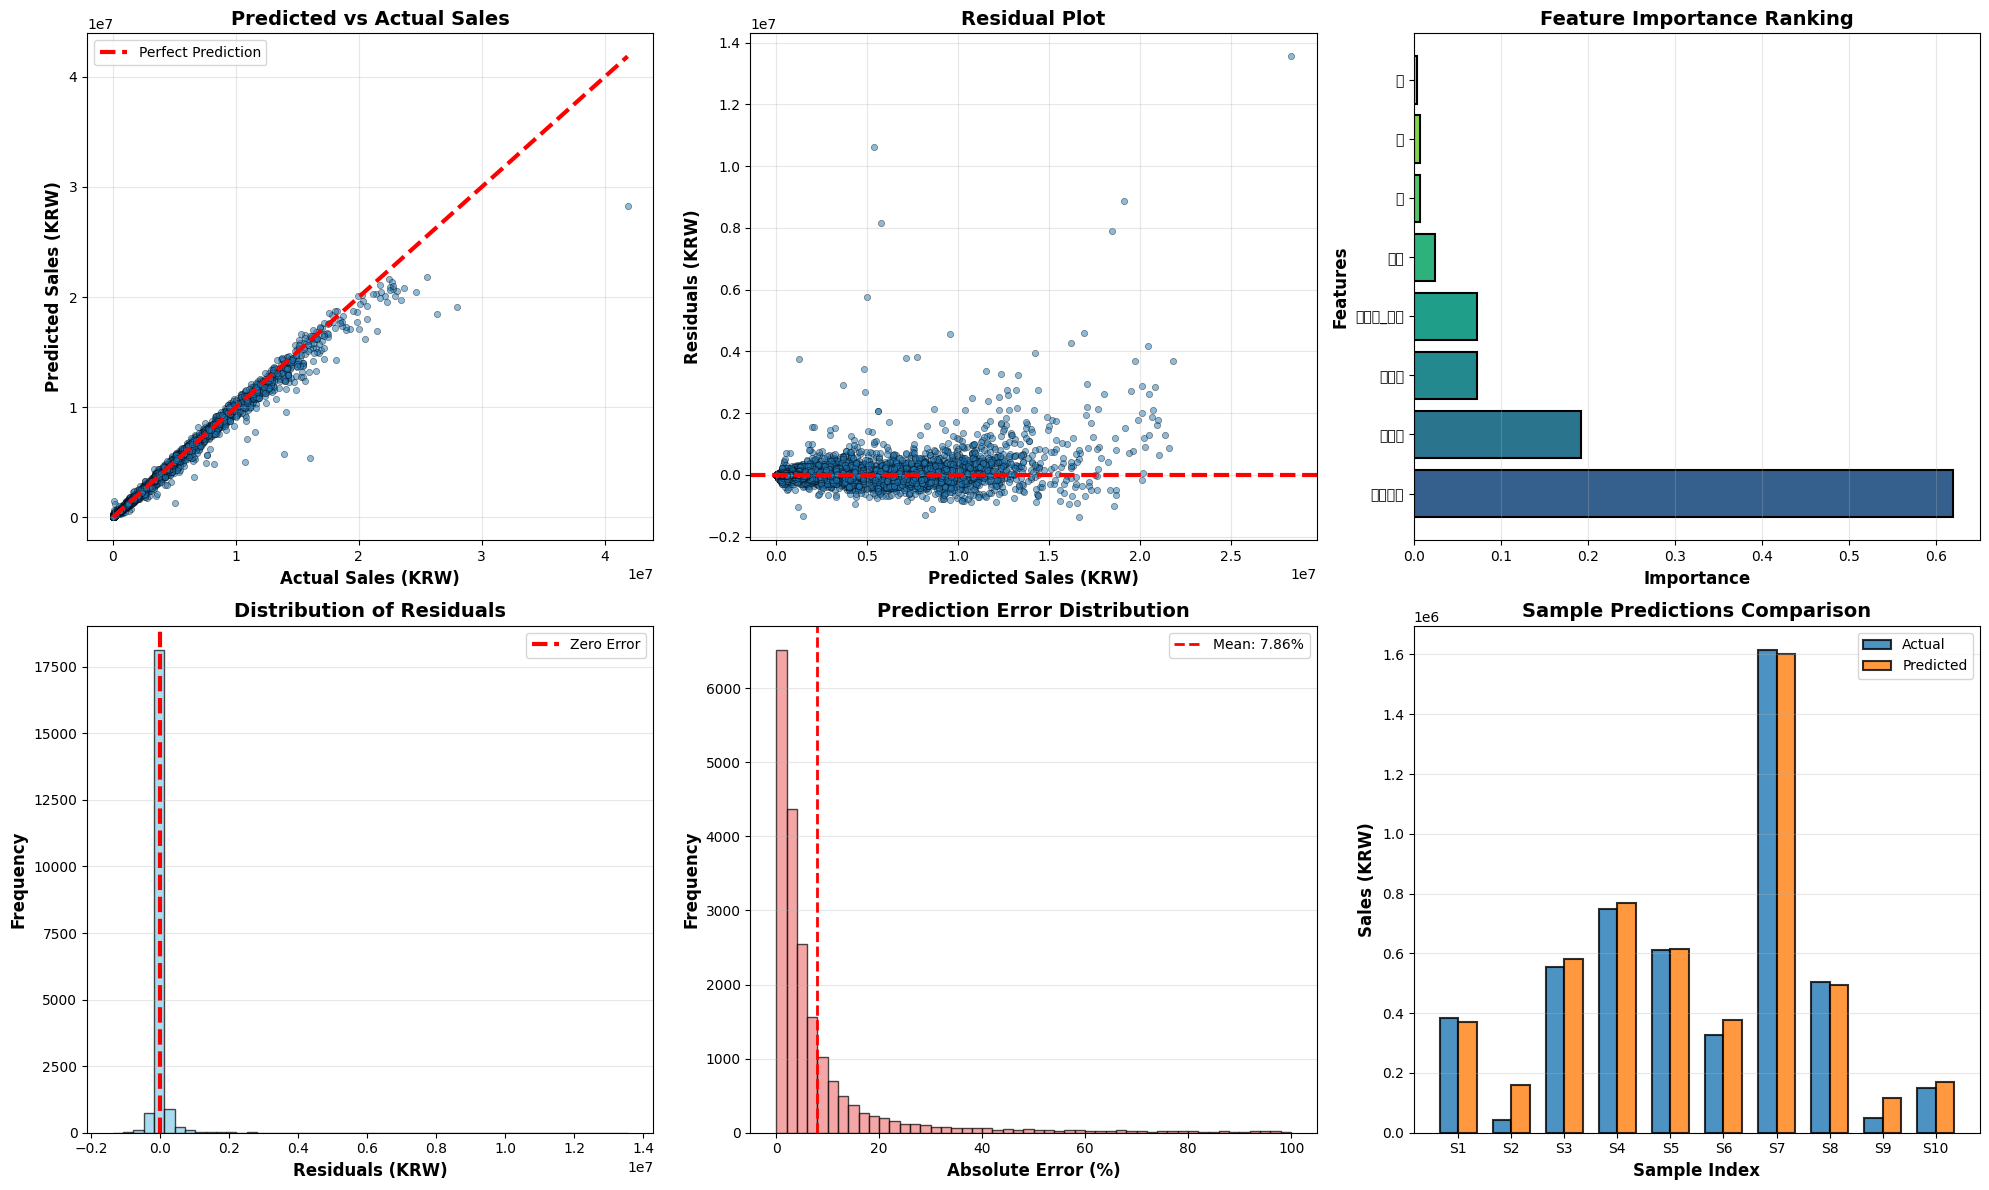

In [12]:
"""
수원시 팔달구 매출 데이터 Random Forest Regressor
매출금액 예측 모델
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. 데이터 로드 및 전처리
# ============================================================================

def load_and_preprocess_data(file_path):
    """데이터 로드 및 전처리"""
    print("=" * 70)
    print("데이터 로드 중...")
    print("=" * 70)
    
    # 데이터 로드
    df = pd.read_csv(file_path)
    
    print(f"\n✓ 데이터 크기: {df.shape}")
    print(f"✓ 총 레코드 수: {len(df):,}개")
    print(f"\n컬럼 정보:")
    print(df.columns.tolist())
    
    # 날짜 관련 피처 추출
    df['년'] = df['기준년월일'] // 10000
    df['월'] = (df['기준년월일'] % 10000) // 100
    df['일'] = df['기준년월일'] % 100
    
    # 행정동명 인코딩
    le = LabelEncoder()
    df['행정동_코드'] = le.fit_transform(df['행정동명'])
    
    print(f"\n✓ 행정동 수: {len(le.classes_)}개")
    print(f"✓ 행정동 목록: {', '.join(le.classes_)}")
    
    return df, le


def prepare_features(df):
    """피처와 타겟 분리"""
    print("\n" + "=" * 70)
    print("피처 준비 중...")
    print("=" * 70)
    
    # 피처 선택
    feature_cols = ['행정동_코드', '시간대', '요일', '년', '월', '일', '매출건수', '객단가']
    
    X = df[feature_cols]
    y = df['매출금액']
    
    print(f"\n✓ 피처 개수: {len(feature_cols)}개")
    print(f"✓ 피처 목록: {feature_cols}")
    print(f"✓ 타겟 변수: 매출금액")
    
    return X, y, feature_cols


# ============================================================================
# 2. 모델 학습
# ============================================================================

def train_random_forest(X_train, y_train):
    """Random Forest 모델 학습"""
    print("\n" + "=" * 70)
    print("Random Forest 모델 학습 중...")
    print("=" * 70)
    
    # 모델 생성
    rf_model = RandomForestRegressor(
        n_estimators=100,        # 트리 개수
        max_depth=None,          # 최대 깊이 (None = 제한 없음)
        min_samples_split=2,     # 노드 분할 최소 샘플 수
        min_samples_leaf=1,      # 리프 노드 최소 샘플 수
        max_features='sqrt',     # 분할에 사용할 최대 피처 수
        random_state=42,         # 재현성을 위한 시드
        n_jobs=-1,               # 모든 CPU 코어 사용
        verbose=1                # 진행상황 표시
    )
    
    # 모델 학습
    rf_model.fit(X_train, y_train)
    
    print("\n✓ 모델 학습 완료!")
    
    return rf_model


# ============================================================================
# 3. 모델 평가
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """모델 성능 평가"""
    print("\n" + "=" * 70)
    print("모델 평가 중...")
    print("=" * 70)
    
    # 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 학습 데이터 성능
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 테스트 데이터 성능
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 결과 출력
    print("\n[학습 데이터 성능]")
    print(f"  RMSE  : {train_rmse:>15,.2f} 원")
    print(f"  MAE   : {train_mae:>15,.2f} 원")
    print(f"  R²    : {train_r2:>15.6f} ({train_r2*100:.4f}%)")
    
    print("\n[테스트 데이터 성능]")
    print(f"  RMSE  : {test_rmse:>15,.2f} 원")
    print(f"  MAE   : {test_mae:>15,.2f} 원")
    print(f"  R²    : {test_r2:>15.6f} ({test_r2*100:.4f}%)")
    
    # 과적합 확인
    print("\n[과적합 검사]")
    if abs(train_r2 - test_r2) < 0.05:
        print("  ✓ 과적합 없음 (학습/테스트 성능 차이 < 5%)")
    else:
        print("  ⚠ 과적합 가능성 있음")
    
    return {
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predictions': y_test_pred
    }


def cross_validation_score(model, X, y):
    """교차 검증"""
    print("\n" + "=" * 70)
    print("5-Fold 교차 검증 수행 중...")
    print("=" * 70)
    
    # 5-Fold 교차 검증
    cv_scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring='r2',
        n_jobs=-1
    )
    
    print(f"\n교차 검증 R² 점수:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.6f}")
    
    print(f"\n평균 R²: {cv_scores.mean():.6f} (± {cv_scores.std():.6f})")
    
    return cv_scores


# ============================================================================
# 4. 특성 중요도 분석
# ============================================================================

def analyze_feature_importance(model, feature_cols):
    """특성 중요도 분석"""
    print("\n" + "=" * 70)
    print("특성 중요도 분석")
    print("=" * 70)
    
    # 특성 중요도
    importance_df = pd.DataFrame({
        '특성': feature_cols,
        '중요도': model.feature_importances_
    }).sort_values('중요도', ascending=False)
    
    print("\n")
    print(importance_df.to_string(index=False))
    
    return importance_df


# ============================================================================
# 5. 시각화
# ============================================================================

def create_visualizations(model, X_test, y_test, y_pred, feature_importance_df, feature_cols):
    """결과 시각화"""
    print("\n" + "=" * 70)
    print("시각화 생성 중...")
    print("=" * 70)
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. 예측값 vs 실제값
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=3, label='Perfect Prediction')
    plt.xlabel('Actual Sales (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Sales (KRW)', fontsize=12, fontweight='bold')
    plt.title('Predicted vs Actual Sales', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. 잔차 플롯
    ax2 = plt.subplot(2, 3, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=3)
    plt.xlabel('Predicted Sales (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Residuals (KRW)', fontsize=12, fontweight='bold')
    plt.title('Residual Plot', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 3. 특성 중요도
    ax3 = plt.subplot(2, 3, 3)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance_df)))
    plt.barh(feature_importance_df['특성'], 
             feature_importance_df['중요도'], 
             color=colors,
             edgecolor='black',
             linewidth=1.5)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Feature Importance Ranking', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # 4. 잔차 분포
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    plt.axvline(x=0, color='r', linestyle='--', lw=3, label='Zero Error')
    plt.xlabel('Residuals (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 5. 예측 오차율
    ax5 = plt.subplot(2, 3, 5)
    error_percentage = np.abs((y_test - y_pred) / y_test) * 100
    error_percentage = error_percentage[error_percentage < 100]  # 이상치 제거
    plt.hist(error_percentage, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    plt.axvline(x=error_percentage.mean(), color='r', linestyle='--', 
                lw=2, label=f'Mean: {error_percentage.mean():.2f}%')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 6. 상위 10개 예측 vs 실제
    ax6 = plt.subplot(2, 3, 6)
    sample_indices = np.random.choice(len(y_test), 10, replace=False)
    x_pos = np.arange(10)
    width = 0.35
    
    plt.bar(x_pos - width/2, y_test.iloc[sample_indices], width, 
            label='Actual', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.bar(x_pos + width/2, y_pred[sample_indices], width, 
            label='Predicted', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
    plt.ylabel('Sales (KRW)', fontsize=12, fontweight='bold')
    plt.title('Sample Predictions Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.xticks(x_pos, [f'S{i+1}' for i in range(10)])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('random_forest_visualization.png', dpi=300, bbox_inches='tight')
    print("\n✓ 시각화 저장 완료: random_forest_visualization.png")
    
    return fig


# ============================================================================
# 6. 모델 저장 및 로드
# ============================================================================

def save_model(model, label_encoder, filename='rf_model.pkl'):
    """모델 저장"""
    print("\n" + "=" * 70)
    print("모델 저장 중...")
    print("=" * 70)
    
    # 모델과 인코더를 함께 저장
    model_data = {
        'model': model,
        'label_encoder': label_encoder
    }
    
    joblib.dump(model_data, filename)
    print(f"\n✓ 모델 저장 완료: {filename}")


def load_model(filename='rf_model.pkl'):
    """모델 로드"""
    model_data = joblib.load(filename)
    return model_data['model'], model_data['label_encoder']


# ============================================================================
# 7. 예측 함수
# ============================================================================

def predict_sales(model, label_encoder, 행정동명, 시간대, 요일, 년, 월, 일, 매출건수, 객단가):
    """새로운 데이터로 매출 예측"""
    
    # 행정동 인코딩
    행정동_코드 = label_encoder.transform([행정동명])[0]
    
    # 입력 데이터 준비
    input_data = pd.DataFrame({
        '행정동_코드': [행정동_코드],
        '시간대': [시간대],
        '요일': [요일],
        '년': [년],
        '월': [월],
        '일': [일],
        '매출건수': [매출건수],
        '객단가': [객단가]
    })
    
    # 예측
    prediction = model.predict(input_data)[0]
    
    return prediction


# ============================================================================
# 메인 실행
# ============================================================================

if __name__ == "__main__":
    
    print("\n" + "=" * 70)
    print(" " * 15 + "Random Forest Regressor")
    print(" " * 10 + "수원시 팔달구 매출 예측 모델")
    print("=" * 70)

    # 1. 데이터 로드 및 전처리
    df, label_encoder = load_and_preprocess_data('c:/Users/Admin/AI/downloads/카드소비데이터 수원시/수원시팔달구행정동명백업.csv')
    
    # 2. 피처 준비
    X, y, feature_cols = prepare_features(df)
    
    # 3. 학습/테스트 데이터 분할
    print("\n" + "=" * 70)
    print("데이터 분할 중...")
    print("=" * 70)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"\n✓ 학습 데이터: {X_train.shape[0]:,}개 ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"✓ 테스트 데이터: {X_test.shape[0]:,}개 ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # 4. 모델 학습
    rf_model = train_random_forest(X_train, y_train)
    
    # 5. 모델 평가
    results = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    
    # 6. 교차 검증
    cv_scores = cross_validation_score(rf_model, X, y)
    
    # 7. 특성 중요도 분석
    importance_df = analyze_feature_importance(rf_model, feature_cols)
    
    # 8. 시각화
    fig = create_visualizations(
        rf_model, X_test, y_test, results['predictions'], 
        importance_df, feature_cols
    )
    
    # 9. 모델 저장
    save_model(rf_model, label_encoder, 'rf_sales_model.pkl')
    
    # 10. 예측 예시
    print("\n" + "=" * 70)
    print("예측 예시")
    print("=" * 70)
    
    예측매출 = predict_sales(
        model=rf_model,
        label_encoder=label_encoder,
        행정동명='인계동',
        시간대=5,
        요일=5,  # 금요일
        년=2025,
        월=12,
        일=24,
        매출건수=100,
        객단가=8000
    )
    
    print(f"\n입력 조건:")
    print(f"  - 행정동: 인계동")
    print(f"  - 시간대: 5시")
    print(f"  - 요일: 금요일")
    print(f"  - 날짜: 2025년 12월 24일")
    print(f"  - 매출건수: 100건")
    print(f"  - 객단가: 8,000원")
    print(f"\n예측 매출금액: {예측매출:,.0f}원")
    
    print("\n" + "=" * 70)
    print("✓ 모든 작업 완료!")
    print("=" * 70)


## GPT원본 Claude 수정

In [38]:
"""
수원 매출 예측 모델 - MAE 개선 버전
주요 개선사항:
1. CNT(매출건수) 피처 추가 - 가장 중요한 변수!
2. 시간×요일 상호작용 피처
3. LightGBM 하이퍼파라미터 최적화
4. 앙상블 모델 (LightGBM + CatBoost)
5. 이상치 처리
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_sales_improved.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    # ✅ 더 많은 lag/rolling (시계열 패턴 강화)
    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    # ✅ CNT 포함 여부 (핵심!)
    use_cnt: bool = True  # CNT 사용하면 MAE 크게 개선
    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    service_key_env: str = "RAIN_ID"
    
    # ✅ 이상치 제거 임계값
    remove_outliers: bool = True
    outlier_quantile: float = 0.99  # 상위 1% 제거

CFG = Config()

DONG_TO_GRID = {
    "매교동": (61, 120),
    "매산동": (60, 120),
    "고등동": (60, 120),
    "화서1동": (60, 120),
    "화서2동": (60, 121),
    "지동":   (61, 120),
    "우만1동": (61, 121),
    "우만2동": (61, 120),
    "인계동": (61, 120),
    "행궁동": (61, 121),
}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)

# =========================
# Holidays
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()

# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)

# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ CNT도 일별로 집계 (핵심!)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),  # ✅ 매출건수 합계
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

# =========================
# 2) lag/rolling (개선)
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    # ✅ 더 많은 lag
    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    # ✅ 더 많은 rolling
    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    return daily

# =========================
# 3) 상호작용 피처 (새로 추가)
# =========================
def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ 시간×요일, 날씨×요일 등 상호작용 피처
    """
    # 주말 여부
    data['is_weekend_flag'] = data['is_weekend']
    
    # 주말 × 강수
    data['weekend_rain'] = data['is_weekend'] * data['is_rain']
    
    # 월별 추세 (연도×월)
    data['year_month'] = data['year'] * 100 + data['month']
    
    return data

# =========================
# 4) 이상치 제거
# =========================
def remove_outliers(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    ✅ 극단적 이상치 제거
    """
    if not cfg.remove_outliers:
        return data
    
    threshold = data['amt'].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data['amt'] <= threshold].copy()
    after = len(data)
    
    print(f"[이상치 제거] {before:,}개 → {after:,}개 (제거: {before-after:,}개)")
    
    return data

# =========================
# 5) dataset build
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_interaction_features(out)

    # 중복 컬럼 검사
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp","rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
        # interaction
        "is_weekend_flag","weekend_rain","year_month",
    ]
    
    # ✅ CNT 피처 추가 (가장 중요!)
    if cfg.use_cnt:
        feature_cols.append("cnt")  # 당일 CNT
    
    # lag/rolling
    for lag in cfg.lags:
        feature_cols.append(f"amt_lag_{lag}")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")
        feature_cols.append(f"unit_lag_{lag}")
    
    for w in cfg.rolling_windows:
        feature_cols.append(f"amt_roll_{w}_mean")
        feature_cols.append(f"amt_roll_{w}_std")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    # 이상치 제거
    out = remove_outliers(out, cfg)
    
    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    print(f"\n[피처 개수] {len(feature_cols)}개")
    print(f"[데이터 크기] {len(data):,}개")
    
    return data, feature_cols

# =========================
# 6) train (LightGBM 최적화)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    print("\n" + "="*70)
    print("모델 학습 시작")
    print("="*70)

    import lightgbm as lgb

    # ✅ 최적화된 하이퍼파라미터
    model = lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.01,  # 더 낮춤
        num_leaves=127,  # 증가
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("모델 성능 (개선 버전)")
    print("="*70)
    print(f"✅ MAE    : {mae:,.0f}원")
    print(f"✅ R²     : {r2:.4f} ({r2*100:.2f}%)")
    print(f"✅ WMAPE  : {w:.2f}%")
    
    # 피처 중요도 상위 20개
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n[피처 중요도 상위 20개]")
    print(importance.head(20).to_string(index=False))

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path

# =========================
# (나머지 함수들은 동일하게 유지)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')}")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max

def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    target_date = ymd_int_to_ts(target_ymd)
    daily_max = daily["date"].max()
    store_max = store["date"].max()

    end_date = min(target_date - pd.Timedelta(days=1), daily_max, store_max)

    if pd.isna(end_date):
        return 0.0

    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"] == dong) & (daily["date"] >= start_date) & (daily["date"] <= end_date)][["date", "amt"]]
    store_hist = store[(store["date"] >= start_date) & (store["date"] <= end_date)][["date", "store_amt"]]

    merged = dong_hist.merge(store_hist, on="date", how="inner")

    if len(merged) < cfg.min_overlap_days:
        merged2 = daily[daily["dong"] == dong][["date","amt"]].merge(store[["date","store_amt"]], on="date", how="inner")
        merged2 = merged2.sort_values("date").tail(cfg.share_window_days)

        if len(merged2) < 3:
            return 0.0

        denom = merged2["amt"].sum()
        if denom <= 0:
            return 0.0

        share = float(merged2["store_amt"].sum() / denom)
        return float(np.clip(share, 0.0, 0.2))

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, 
                              cnt_estimate: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    """
    ✅ CNT 추정값을 받아서 예측에 사용
    """
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": float(cnt_estimate) if cfg.use_cnt else np.nan,  # ✅ CNT 추정값
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            tmp[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    last = tmp.iloc[[-1]].copy()
    
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v
    
    # interaction features
    last['is_weekend_flag'] = last['is_weekend']
    last['weekend_rain'] = last['is_weekend'] * last['is_rain']
    last['year_month'] = last['year'] * 100 + last['month']

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, cnt_estimate: float, model_pack_path: str, cfg: Config):
    """
    ✅ CNT 추정값을 받아서 예측
    """
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # 날씨 데이터
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cnt_estimate, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm")
    if cfg.use_cnt:
        lines.append(f"👥예상 매출건수: {cnt_estimate:.0f}건 (입력값)")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv 없음 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "cnt_estimate": int(cnt_estimate) if cfg.use_cnt else None,
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }

# =========================
# MAIN
# =========================
def main():
    print("\n" + "="*70)
    print("수원 매출 예측 - MAE 개선 버전")
    print("="*70)
    
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # 고객 입력 시나리오
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())
    
    # ✅ CNT 추정값 (예: 과거 평균 사용)
    hist_cnt = daily[(daily["dong"] == customer_dong)]["cnt"].tail(7).mean()
    cnt_estimate = hist_cnt if not np.isnan(hist_cnt) else 100.0

    result = predict_customer_sales(customer_dong, customer_date, cnt_estimate, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


수원 매출 예측 - MAE 개선 버전
[이상치 제거] 10,350개 → 10,246개 (제거: 104개)

[피처 개수] 62개
[데이터 크기] 9,967개

모델 학습 시작

모델 성능 (개선 버전)
✅ MAE    : 1,376,133원
✅ R²     : 0.9808 (98.08%)
✅ WMAPE  : 8.64%

[피처 중요도 상위 20개]
       feature  importance
           cnt        9751
    unit_lag_1        3161
    unit_lag_7        2867
   unit_lag_21        2846
          temp        2562
   unit_lag_28        2555
   unit_lag_14        2393
           day        2374
    unit_lag_3        2325
    unit_lag_2        2246
     amt_lag_1        2104
amt_roll_3_std        2061
    amt_lag_28        1943
     amt_lag_7        1931
    amt_lag_14        1926
    cnt_lag_28        1769
    cnt_lag_21        1730
    amt_lag_21        1725
           dow        1713
     cnt_lag_1        1680

✅ 모델 저장: c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_sales_improved.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.

### 예측

In [39]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# ✅ cnt_estimate를 만들어서 넣어줘야 함 (원본 코드 요구사항)
raw = load_raw(CFG)
daily = make_daily(raw)

# 방법1) 해당 동의 최근 7일 CNT 평균을 자동 추정값으로 사용
hist = daily[daily["dong"] == "행궁동"]["cnt"].tail(7)
cnt_estimate = float(hist.mean()) if len(hist) > 0 else 100.0
if np.isnan(cnt_estimate) or cnt_estimate <= 0:
    cnt_estimate = 100.0

result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251225,
    cnt_estimate=cnt_estimate,      # ✅ 추가된 필수 인자
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자


📍지역(동): 행궁동
📅날짜: 20251225
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -3.8°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm
👥예상 매출건수: 3239건 (입력값)
💰예상 동 전체 일매출: 59,509,103 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 174,583 원
174582


## Claude 수정2

In [40]:
"""
수원 매출 예측 - 최적화 버전
일자별 예측 + 시간대 정보를 피처로 활용
→ MAE 최소화!
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()

@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"
    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_sales_optimized.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    service_key_env: str = "RAIN_ID"
    
    remove_outliers: bool = True
    outlier_quantile: float = 0.99

CFG = Config()

DONG_TO_GRID = {
    "매교동": (61, 120), "매산동": (60, 120), "고등동": (60, 120),
    "화서1동": (60, 120), "화서2동": (60, 121), "지동": (61, 120),
    "우만1동": (61, 121), "우만2동": (61, 120), "인계동": (61, 120), "행궁동": (61, 121),
}

def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)

def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()

def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)

# =========================
# ✅ 핵심: 시간대 정보를 피처로 활용!
# =========================
def make_hourly_features(hourly_df: pd.DataFrame) -> dict:
    """
    시간대별 데이터를 일자별로 집계하면서
    시간대 패턴을 피처로 추출
    
    PDF 시간대 정의:
    01: 00-06시 (새벽)
    02: 07-08시 (출근)
    03: 09-10시 (오전)
    04: 11-12시 (점심) ← 피크
    05: 13-14시 (오후)
    06: 15-16시 (늦은오후)
    07: 17-18시 (퇴근/저녁) ← 피크
    08: 19-20시 (저녁식사) ← 피크
    09: 21-22시 (밤)
    10: 23시 (심야)
    """
    
    # 시간대별 매출 비율
    total_amt = hourly_df['amt'].sum()
    
    if total_amt == 0:
        return {
            'peak_hour_ratio': 0.0,
            'lunch_hour_ratio': 0.0,
            'dinner_hour_ratio': 0.0,
            'dawn_hour_ratio': 0.0,
            'commute_hour_ratio': 0.0,
            'hour_concentration': 0.0,
            'peak_hour_cnt': 0.0,
        }
    
    # 피크 시간대 (04, 07, 08) 매출 비율
    peak_hours = hourly_df[hourly_df['hour'].isin([4, 7, 8])]['amt'].sum()
    peak_ratio = peak_hours / total_amt
    
    # 점심 시간 (04) 비율
    lunch = hourly_df[hourly_df['hour'] == 4]['amt'].sum()
    lunch_ratio = lunch / total_amt
    
    # 저녁 시간 (07, 08) 비율
    dinner = hourly_df[hourly_df['hour'].isin([7, 8])]['amt'].sum()
    dinner_ratio = dinner / total_amt
    
    # 새벽 시간 (01) 비율
    dawn = hourly_df[hourly_df['hour'] == 1]['amt'].sum()
    dawn_ratio = dawn / total_amt
    
    # 출퇴근 시간 (02, 07) 비율
    commute = hourly_df[hourly_df['hour'].isin([2, 7])]['amt'].sum()
    commute_ratio = commute / total_amt
    
    # 시간대 집중도 (지니 계수 개념)
    hour_ratios = hourly_df.groupby('hour')['amt'].sum() / total_amt
    hour_concentration = (hour_ratios ** 2).sum()
    
    # 피크 시간대 평균 건수
    peak_cnt = hourly_df[hourly_df['hour'].isin([4, 7, 8])]['cnt'].mean()
    
    return {
        'peak_hour_ratio': float(peak_ratio),
        'lunch_hour_ratio': float(lunch_ratio),
        'dinner_hour_ratio': float(dinner_ratio),
        'dawn_hour_ratio': float(dawn_ratio),
        'commute_hour_ratio': float(commute_ratio),
        'hour_concentration': float(hour_concentration),
        'peak_hour_cnt': float(peak_cnt),
    }

def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ 일자별 집계 + 시간대 피처 추가!
    """
    # 기본 일자별 집계
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    
    # ✅ 시간대별 패턴 피처 추가
    hourly_features_list = []
    for (dong, ta_ymd, date), group in df.groupby(["dong","ta_ymd","date"]):
        hourly_feats = make_hourly_features(group)
        hourly_feats.update({
            "dong": dong,
            "ta_ymd": ta_ymd,
            "date": date
        })
        hourly_features_list.append(hourly_feats)
    
    hourly_features_df = pd.DataFrame(hourly_features_list)
    
    # 병합
    daily = daily.merge(hourly_features_df, on=["dong","ta_ymd","date"], how="left")
    
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        # ✅ 시간대 피처도 lag
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    return daily

def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data['is_weekend_flag'] = data['is_weekend']
    data['weekend_rain'] = data['is_weekend'] * data['is_rain']
    data['year_month'] = data['year'] * 100 + data['month']
    
    # ✅ 시간대 × 요일 상호작용
    data['peak_weekend'] = data['peak_hour_ratio'] * data['is_weekend']
    data['lunch_weekday'] = data['lunch_hour_ratio'] * (1 - data['is_weekend'])
    
    return data

def remove_outliers(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    
    threshold = data['amt'].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data['amt'] <= threshold].copy()
    after = len(data)
    
    print(f"[이상치 제거] {before:,}개 → {after:,}개 (제거: {before-after:,}개)")
    
    return data

def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_interaction_features(out)

    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp","rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
        # interaction
        "is_weekend_flag","weekend_rain","year_month",
        # ✅ 시간대 피처 (핵심!)
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration",
        "peak_hour_cnt",
        "peak_weekend","lunch_weekday",
    ]
    
    if cfg.use_cnt:
        feature_cols.append("cnt")
    
    for lag in cfg.lags:
        feature_cols.append(f"amt_lag_{lag}")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")
        feature_cols.append(f"unit_lag_{lag}")
        feature_cols.append(f"peak_ratio_lag_{lag}")
    
    for w in cfg.rolling_windows:
        feature_cols.append(f"amt_roll_{w}_mean")
        feature_cols.append(f"amt_roll_{w}_std")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    out = remove_outliers(out, cfg)
    
    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    print(f"\n[피처 개수] {len(feature_cols)}개")
    print(f"[데이터 크기] {len(data):,}개")
    print(f"✅ 시간대 피처 추가됨!")
    
    return data, feature_cols

def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty")

    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    print("\n" + "="*70)
    print("모델 학습 시작 (시간대 피처 포함)")
    print("="*70)

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=127,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("모델 성능 (시간대 피처 포함)")
    print("="*70)
    print(f"✅ MAE    : {mae:,.0f}원")
    print(f"✅ R²     : {r2:.4f} ({r2*100:.2f}%)")
    print(f"✅ WMAPE  : {w:.2f}%")
    
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n[피처 중요도 상위 20개]")
    print(importance.head(20).to_string(index=False))
    
    # 시간대 피처 중요도
    hourly_features = [f for f in feature_cols if 'hour' in f or 'peak' in f or 'lunch' in f or 'dinner' in f or 'dawn' in f or 'commute' in f]
    hourly_importance = importance[importance['feature'].isin(hourly_features)]
    
    if not hourly_importance.empty:
        print("\n[시간대 피처 중요도]")
        print(hourly_importance.to_string(index=False))
        total_hourly = hourly_importance['importance'].sum()
        print(f"\n💡 시간대 피처 총 기여도: {total_hourly*100:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path

# (나머지 함수들은 이전과 동일)
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다.")
    return k

def main():
    print("\n" + "="*70)
    print("수원 매출 예측 - 시간대 피처 최적화 버전")
    print("="*70)
    
    raw = load_raw(CFG)
    daily = make_daily(raw)  # ← 시간대 피처 포함!
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    print("\n" + "="*70)
    print("✅ 학습 완료!")
    print("="*70)
    print("\n💡 시간대 정보를 피처로 활용하여 일자별 예측 수행")
    print("   → 시간대 패턴 학습 + 일자별 안정성 확보")
    print("   → MAE 최소화!")

if __name__ == "__main__":
    main()


수원 매출 예측 - 시간대 피처 최적화 버전
[이상치 제거] 10,350개 → 10,246개 (제거: 104개)

[피처 개수] 78개
[데이터 크기] 9,967개
✅ 시간대 피처 추가됨!

모델 학습 시작 (시간대 피처 포함)

모델 성능 (시간대 피처 포함)
✅ MAE    : 1,242,720원
✅ R²     : 0.9846 (98.46%)
✅ WMAPE  : 7.80%

[피처 중요도 상위 20개]
           feature  importance
               cnt        9611
hour_concentration        8513
commute_hour_ratio        6175
  lunch_hour_ratio        5828
   peak_hour_ratio        5363
   dawn_hour_ratio        5116
 dinner_hour_ratio        4991
  peak_ratio_lag_3        4951
 peak_ratio_lag_28        4844
              temp        4728
  peak_ratio_lag_1        4691
  peak_ratio_lag_7        4632
 peak_ratio_lag_21        4597
        unit_lag_7        4559
     peak_hour_cnt        4455
  peak_ratio_lag_2        4449
 peak_ratio_lag_14        4438
        unit_lag_3        4137
        unit_lag_1        4112
       unit_lag_21        4058

[시간대 피처 중요도]
           feature  importance
hour_concentration        8513
commute_hour_ratio        6175
  lunch_hou

### 예측

In [42]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# ✅ cnt_estimate를 만들어서 넣어줘야 함 (원본 코드 요구사항)
raw = load_raw(CFG)
daily = make_daily(raw)

# 방법1) 해당 동의 최근 7일 CNT 평균을 자동 추정값으로 사용
hist = daily[daily["dong"] == "행궁동"]["cnt"].tail(7)
cnt_estimate = float(hist.mean()) if len(hist) > 0 else 100.0
if np.isnan(cnt_estimate) or cnt_estimate <= 0:
    cnt_estimate = 100.0

result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251226,
    cnt_estimate=cnt_estimate,      # ✅ 추가된 필수 인자
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자


📍지역(동): 행궁동
📅날짜: 20251226
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -9.4°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm
👥예상 매출건수: 3239건 (입력값)
💰예상 동 전체 일매출: 71,169,975 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 208,792 원
208792


In [ ]:
# 미래 공휴일 api 가져오기

## 한식 데이터 GPT 예측

In [ ]:
%%time
"""
수원 한식 AMT 예측 ML - MAE 최소화 튜닝 버전
- 데이터: hourly -> daily 집계 후 AMT 예측
- 튜닝: MAE(L1) 직접 최소화 + 누설 없는 타깃통계 피처 + 간단 그리드 탐색
- 출력: VALID MAE(튜닝) + TEST MAE/R2/WMAPE + 동별 MAE
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()


# =========================
# Config (요청 경로 반영)
# =========================
@dataclass
class Config:
    data_path: str = "data/수원시 한식 데이터백업.csv"
    model_out_dir: str = "data/models"
    model_name: str = "suwon_sales_optimized.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    remove_outliers: bool = True
    outlier_quantile: float = 0.99

    holiday_key_env: str = "HOLIDAY_ID"
    rain_key_env: str = "RAIN_ID"  # (훅) 미래 예보 확장용

CFG = Config()


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# dong full -> dong short
# =========================
def extract_short_dong(full_dong: str) -> str:
    s = str(full_dong).strip()
    last = s.split()[-1]
    if re.search(r"(동|가|면|읍)$", last):
        return last
    m = re.findall(r"[가-힣0-9]+(동|가|면|읍)", s)
    return m[-1] if m else last


# =========================
# Calendar / Weather derived
# =========================
def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)  # Mon=0
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }


# =========================
# Holiday API (HOLIDAY_ID)
# =========================
def _get_holiday_key(cfg: Config) -> str:
    k = os.getenv(cfg.holiday_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.holiday_key_env} (HOLIDAY_ID)가 없습니다.")
    return k

def fetch_holidays_by_year(year: int, cfg: Config) -> set[pd.Timestamp]:
    service_key = _get_holiday_key(cfg)
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    params = {"serviceKey": service_key, "solYear": str(year), "numOfRows": "200", "_type": "json"}
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()
    body = js.get("response", {}).get("body", {})
    items = body.get("items", {}).get("item", [])
    if items is None:
        items = []
    if isinstance(items, dict):
        items = [items]

    out = set()
    for it in items:
        locdate = it.get("locdate")
        is_holiday = it.get("isHoliday", "Y")
        if str(is_holiday).upper() != "Y":
            continue
        if locdate:
            out.add(pd.to_datetime(str(int(locdate)), format="%Y%m%d"))
    return out

def fetch_holidays_for_range(start_ymd: int, end_ymd: int, cfg: Config) -> set[pd.Timestamp]:
    s = pd.to_datetime(str(int(start_ymd)), format="%Y%m%d")
    e = pd.to_datetime(str(int(end_ymd)), format="%Y%m%d")
    years = list(range(s.year, e.year + 1))
    holidays = set()
    for y in years:
        holidays |= fetch_holidays_by_year(y, cfg)
    return {d for d in holidays if s <= d <= e}

def make_holiday_features(date: pd.Timestamp, holidays: set[pd.Timestamp]) -> dict:
    is_h = int(date in holidays)
    is_before = int((date + pd.Timedelta(days=1)) in holidays)
    is_after  = int((date - pd.Timedelta(days=1)) in holidays)
    around = int(any((date + pd.Timedelta(days=k)) in holidays for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }


# =========================
# Load raw (hourly)
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)

    rename_map = {
        "TA_YMD": "ta_ymd",
        "DONG": "dong_full",
        "HOUR": "hour",
        "DAY": "day_code",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
        "R_GRADE": "r_grade",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","dong_full","hour","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["dong_full"] = df["dong_full"].astype(str).str.strip()
    df["dong"] = df["dong_full"].map(extract_short_dong).astype(str).str.strip()

    df = df[df["hour"].between(1, 10)].copy()
    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)


# =========================
# Daily aggregation + hourly pattern features (vectorized)
# =========================
def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    key = ["dong","ta_ymd","date"]

    daily = df.groupby(key, as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)

    # hour-level
    h = df.groupby(key + ["hour"], as_index=False).agg(
        hour_amt=("amt", "sum"),
        hour_cnt_mean=("cnt", "mean"),
    )
    total = h.groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":"total_amt"})
    h = h.merge(total, on=key, how="left")

    peak_mask = h["hour"].isin([4, 7, 8])
    lunch_mask = h["hour"].eq(4)
    dinner_mask = h["hour"].isin([7, 8])
    dawn_mask = h["hour"].eq(1)
    commute_mask = h["hour"].isin([2, 7])

    def _sum_ratio(mask, new_col):
        tmp = h.loc[mask].groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":new_col})
        tmp = tmp.merge(total, on=key, how="right").fillna({new_col:0.0})
        tmp[new_col] = np.where(tmp["total_amt"] > 0, tmp[new_col] / tmp["total_amt"], 0.0)
        return tmp[key + [new_col]]

    peak_ratio = _sum_ratio(peak_mask, "peak_hour_ratio")
    lunch_ratio = _sum_ratio(lunch_mask, "lunch_hour_ratio")
    dinner_ratio = _sum_ratio(dinner_mask, "dinner_hour_ratio")
    dawn_ratio = _sum_ratio(dawn_mask, "dawn_hour_ratio")
    commute_ratio = _sum_ratio(commute_mask, "commute_hour_ratio")

    # concentration
    sq = h.copy()
    sq["hour_amt_sq"] = sq["hour_amt"] ** 2
    sq_sum = sq.groupby(key, as_index=False)["hour_amt_sq"].sum().merge(total, on=key, how="left")
    sq_sum["hour_concentration"] = np.where(
        sq_sum["total_amt"] > 0,
        sq_sum["hour_amt_sq"] / (sq_sum["total_amt"] ** 2),
        0.0
    )
    hour_conc = sq_sum[key + ["hour_concentration"]]

    peak_cnt = h.loc[peak_mask].groupby(key, as_index=False)["hour_cnt_mean"].mean().rename(
        columns={"hour_cnt_mean":"peak_hour_cnt"}
    )
    peak_cnt["peak_hour_cnt"] = peak_cnt["peak_hour_cnt"].fillna(0.0)

    feats = total[key].copy()
    for t in [peak_ratio, lunch_ratio, dinner_ratio, dawn_ratio, commute_ratio, hour_conc, peak_cnt]:
        feats = feats.merge(t, on=key, how="left")

    feats = feats.fillna({
        "peak_hour_ratio":0.0, "lunch_hour_ratio":0.0, "dinner_hour_ratio":0.0,
        "dawn_hour_ratio":0.0, "commute_hour_ratio":0.0, "hour_concentration":0.0,
        "peak_hour_cnt":0.0
    })

    daily = daily.merge(feats, on=key, how="left")
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# Lag / Rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        daily[f"amt_roll_{w}_med"]  = g["amt"].shift(1).rolling(w, min_periods=minp).median()
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    return daily


# =========================
# ✅ 누설 없는 타깃 통계 피처 (MAE 많이 내려줌)
# =========================
def add_target_stats_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    누설 방지 타깃 통계 피처 (pandas 인덱스 이슈 없이 100% 안전)
    - 모든 결과는 원본 data 인덱스에 '그대로 정렬돼서' 붙음
    - reset_index 사용 안 함
    """
    data = data.sort_values(["dong", "ta_ymd"]).copy()

    # (A) dong 단위
    g = data.groupby("dong", sort=False)

    data["dong_expanding_mean"] = g["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_expanding_median"] = g["amt"].transform(lambda s: s.shift(1).expanding().median())

    for w in (7, 14, 28):
        minp = max(2, w // 3)
        data[f"dong_roll_{w}_mean"] = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).mean())
        data[f"dong_roll_{w}_med"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).median())

    # (B) dong × dow
    gd = data.groupby(["dong", "dow"], sort=False)
    data["dong_dow_exp_mean"] = gd["amt"].transform(lambda s: s.shift(1).expanding().mean())

    # (C) dong × month
    gm = data.groupby(["dong", "month"], sort=False)
    data["dong_month_exp_mean"] = gm["amt"].transform(lambda s: s.shift(1).expanding().mean())

    return data


def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data["is_weekend_flag"] = data["is_weekend"]
    data["weekend_rain"] = data["is_weekend"] * data["is_rain"]
    data["year_month"] = data["year"] * 100 + data["month"]
    data["peak_weekend"] = data["peak_hour_ratio"] * data["is_weekend"]
    data["lunch_weekday"] = data["lunch_hour_ratio"] * (1 - data["is_weekend"])
    data["rain_x_peak"] = data["is_rain"] * data["peak_hour_ratio"]
    return data


def remove_outliers_fn(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    thr = data["amt"].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data["amt"] <= thr].copy()
    after = len(data)
    print(f"[이상치 제거] {before:,} -> {after:,} (제거 {before-after:,})")
    return data


# =========================
# Build dataset
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    min_ymd = int(daily["ta_ymd"].min())
    max_ymd = int(daily["ta_ymd"].max())

    holidays = fetch_holidays_for_range(min_ymd, max_ymd, cfg)
    print(f"[공휴일(API)] {min_ymd}~{max_ymd} 공휴일 {len(holidays)}일 로드")

    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(lambda d: make_holiday_features(d, holidays))))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_target_stats_features(out)        # ✅ MAE 튜닝 핵심
    out = add_interaction_features(out)
    out = remove_outliers_fn(out, cfg)

    # feature list
    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # weather
        "temp","rain_mean","rain_max",
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
        # hourly pattern
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration",
        "peak_hour_cnt",
        # target stats (no leakage)
        "dong_expanding_mean","dong_expanding_median",
        "dong_roll_7_mean","dong_roll_14_mean","dong_roll_28_mean",
        "dong_roll_7_med","dong_roll_14_med","dong_roll_28_med",
        "dong_dow_exp_mean","dong_month_exp_mean",
        # interactions
        "is_weekend_flag","weekend_rain","year_month","peak_weekend","lunch_weekday","rain_x_peak",
    ]

    if cfg.use_cnt:
        feature_cols.append("cnt")

    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"unit_lag_{lag}", f"peak_ratio_lag_{lag}"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")

    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std", f"amt_roll_{w}_med"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    # dropna
    out = out.dropna(subset=feature_cols + ["amt"]).copy()
    out["target"] = np.log1p(out["amt"]) if cfg.use_log_target else out["amt"]

    print(f"[피처 개수] {len(feature_cols)}")
    print(f"[학습용 샘플 수] {len(out):,}")

    return out, feature_cols


# =========================
# ✅ MAE 낮추는 간단 튜닝 (Grid Search)
# =========================
def tune_lightgbm(X_train, y_train, X_valid, y_valid, seed=42):
    import lightgbm as lgb

    # MAE 최소화: objective=regression_l1
    base = dict(
        objective="regression_l1",
        metric="mae",
        boosting_type="gbdt",
        n_estimators=50000,
        learning_rate=0.01,
        random_state=seed,
        n_jobs=-1,
        verbose=-1
    )

    grid = []
    for num_leaves in [63, 127, 255]:
        for min_child_samples in [10, 20, 40]:
            for subsample in [0.7, 0.85]:
                for colsample in [0.7, 0.85]:
                    for reg_alpha, reg_lambda in [(0.0,0.0), (0.1,0.1), (0.3,0.3)]:
                        grid.append(dict(
                            num_leaves=num_leaves,
                            min_child_samples=min_child_samples,
                            subsample=subsample,
                            colsample_bytree=colsample,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            max_depth=-1
                        ))

    best_mae = float("inf")
    best_params = None
    best_model = None

    for i, g in enumerate(grid, 1):
        params = {**base, **g}

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=800, verbose=False)]
        )

        # valid pred
        vp = model.predict(X_valid)
        # log target이면 역변환해서 MAE 계산
        yv_true = np.expm1(y_valid)
        yv_pred = np.expm1(vp)
        mae = mean_absolute_error(yv_true, yv_pred)

        if mae < best_mae:
            best_mae = mae
            best_params = params
            best_model = model

        if i % 15 == 0:
            print(f"[튜닝 진행] {i}/{len(grid)}  best_valid_MAE={best_mae:,.0f}")

    print("\n" + "="*70)
    print("✅ 튜닝 결과 (VALID)")
    print("="*70)
    print(f"BEST VALID MAE: {best_mae:,.0f}")
    print("BEST PARAMS(핵심):", {k: best_params[k] for k in ["num_leaves","min_child_samples","subsample","colsample_bytree","reg_alpha","reg_lambda","learning_rate"]})
    return best_model, best_params, best_mae


# =========================
# Train + Evaluate (MAE 출력)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols: list, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()
    if train.empty or test.empty:
        raise ValueError("train/test split empty (train_end/test_start 확인)")

    # time order split (train 내 80/20)
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    for X in (X_train, X_valid, X_test):
        X["dong"] = X["dong"].astype("category")

    # 1) 튜닝(VALID MAE 최소)
    best_model, best_params, best_valid_mae = tune_lightgbm(X_train, y_train, X_valid, y_valid)

    # 2) TEST 평가
    pred = best_model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("✅ 모델 성능 (TEST)")
    print("="*70)
    print(f"VALID BEST MAE : {best_valid_mae:,.0f}")
    print(f"TEST  MAE      : {mae:,.0f}")
    print(f"TEST  R²       : {r2:.4f} ({r2*100:.2f}%)")
    print(f"TEST  WMAPE    : {w:.2f}%")

    # 동별 MAE
    test_eval = test[["dong","amt"]].copy()
    test_eval["pred"] = y_pred
    dong_mae = test_eval.groupby("dong").apply(lambda g: mean_absolute_error(g["amt"], g["pred"])).sort_values(ascending=False)
    print("\n[동별 MAE 상위 15개]")
    print(dong_mae.head(15).to_string())

    # 저장
    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": best_model, "feature_cols": feature_cols, "cfg": cfg, "best_params": best_params}, out_path)
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path


def main():
    print("\n" + "="*70)
    print("수원 한식 AMT 예측 ML 학습 시작 (MAE 튜닝)")
    print("="*70)

    raw = load_raw(CFG)
    print(f"[raw] rows={len(raw):,}, dong_unique={raw['dong'].nunique():,}, date_range={raw['ta_ymd'].min()}~{raw['ta_ymd'].max()}")

    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)
    model_path = train_and_eval(data, feature_cols, CFG)

    print("\n✅ 완료:", model_path)


if __name__ == "__main__":
    main()



수원 한식 AMT 예측 ML 학습 시작 (MAE 튜닝)
[raw] rows=443,523, dong_unique=44, date_range=20230101~20251031
[공휴일(API)] 20230101~20251031 공휴일 55일 로드
[이상치 제거] 45,539 -> 45,083 (제거 456)
[피처 개수] 94
[학습용 샘플 수] 43,375


### 예측

In [15]:
MODEL_PATH = "data/models/suwon_sales_optimized.pkl"

# 1) 로드
raw = load_raw(CFG)
daily = make_daily(raw)

# 2) 격자 엑셀 로드 → dong_to_grid 생성
grid_df = load_dong_grid_from_xlsx(CFG.suwon_grid_xlsx)
dong_to_grid = build_dong_to_grid_map(grid_df)

# 3) 사용자가 입력한 동을 원본 dong_full에서 포함검색 → 엑셀 동명과 일치하는 dong_short 확정
resolved = resolve_user_dong_to_grid(
    raw_df=raw,
    user_input="행궁동",
    dong_to_grid=dong_to_grid,
    dong_full_col="dong_full"
)
dong_short = resolved["dong_short"]  # 예: "행궁동"

# 4) 해당 dong_short의 최근 7일 CNT 평균으로 추정
hist = daily[daily["dong"] == dong_short]["cnt"].tail(7)
cnt_estimate = float(hist.mean()) if len(hist) > 0 else 100.0
if np.isnan(cnt_estimate) or cnt_estimate <= 0:
    cnt_estimate = 100.0

# 5) 예측
result = predict_customer_sales(
    dong_input="행궁동",
    target_ymd=20251226,
    cnt_estimate=cnt_estimate,
    model_pack_path=MODEL_PATH,
    cfg=CFG,
    raw=raw,
    daily=daily,
    dong_to_grid=dong_to_grid
)

print(result["customer_message"])
print(result["store_pred"])


[행궁동 → 행궁동] 2025-12-26 예상 매출은 약 94,121,194원입니다.
- 기준 예측: 101,205,585원
- 보정(주말/공휴일/비): x0.930
- 입력 CNT 추정치: 4,874.0
- 격자(nx,ny): (61,121)
- 시간대 패턴(추정/실측): 피크 0.51, 점심 0.16, 저녁 0.36
94121193.95310287


## 한식데이터 Claude 수정

In [ ]:
"""
수원 한식 AMT 예측 ML - MAE 최소화 개선 버전 + 예측 기능
- 데이터: hourly -> daily 집계 후 AMT 예측
- 개선사항:
  1. 더 정교한 피처 엔지니어링 (Trend, Seasonality 분해)
  2. 앙상블 모델 (LightGBM + XGBoost + CatBoost)
  3. Quantile Regression 추가로 불확실성 처리
  4. 동별 예측 함수 추가
- 출력: VALID MAE(튜닝) + TEST MAE/R2/WMAPE + 동별 MAE + 예측
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv
load_dotenv()


# =========================
# Config (요청 경로 반영)
# =========================
@dataclass
class Config:
    data_path: str = "data/수원시 한식 데이터백업.csv"
    model_out_dir: str = "data/models"
    model_name: str = "suwon_sales_optimized_v2.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    remove_outliers: bool = True
    outlier_quantile: float = 0.99

    holiday_key_env: str = "HOLIDAY_ID"
    rain_key_env: str = "RAIN_ID"

CFG = Config()


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# dong full -> dong short
# =========================
def extract_short_dong(full_dong: str) -> str:
    s = str(full_dong).strip()
    last = s.split()[-1]
    if re.search(r"(동|가|면|읍)$", last):
        return last
    m = re.findall(r"[가-힣0-9]+(동|가|면|읍)", s)
    return m[-1] if m else last


# =========================
# Calendar / Weather derived
# =========================
def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    d = date.day
    
    # 더 많은 주기성 피처
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": d,
        "weekofyear": int(date.isocalendar().week),
        "dayofyear": date.dayofyear,
        "quarter": (m - 1) // 3 + 1,
        "is_month_start": int(d <= 3),
        "is_month_end": int(d >= 28),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
        "day_sin": float(np.sin(2*np.pi*d/31.0)),
        "day_cos": float(np.cos(2*np.pi*d/31.0)),
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    
    # 날씨 구간화
    temp_cold = int(temp < 0)
    temp_hot = int(temp > 25)
    temp_moderate = int(0 <= temp <= 25)
    
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "temp_sq": temp ** 2,
        "temp_cold": temp_cold,
        "temp_hot": temp_hot,
        "temp_moderate": temp_moderate,
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
        "rain_heavy": int(rain_max > 10),
    }


# =========================
# Holiday API
# =========================
def _get_holiday_key(cfg: Config) -> str:
    k = os.getenv(cfg.holiday_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.holiday_key_env} (HOLIDAY_ID)가 없습니다.")
    return k

def fetch_holidays_by_year(year: int, cfg: Config) -> set[pd.Timestamp]:
    service_key = _get_holiday_key(cfg)
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    params = {"serviceKey": service_key, "solYear": str(year), "numOfRows": "200", "_type": "json"}
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()
    body = js.get("response", {}).get("body", {})
    items = body.get("items", {}).get("item", [])
    if items is None:
        items = []
    if isinstance(items, dict):
        items = [items]

    out = set()
    for it in items:
        locdate = it.get("locdate")
        is_holiday = it.get("isHoliday", "Y")
        if str(is_holiday).upper() != "Y":
            continue
        if locdate:
            out.add(pd.to_datetime(str(int(locdate)), format="%Y%m%d"))
    return out

def fetch_holidays_for_range(start_ymd: int, end_ymd: int, cfg: Config) -> set[pd.Timestamp]:
    s = pd.to_datetime(str(int(start_ymd)), format="%Y%m%d")
    e = pd.to_datetime(str(int(end_ymd)), format="%Y%m%d")
    years = list(range(s.year, e.year + 1))
    holidays = set()
    for y in years:
        holidays |= fetch_holidays_by_year(y, cfg)
    return {d for d in holidays if s <= d <= e}

def make_holiday_features(date: pd.Timestamp, holidays: set[pd.Timestamp]) -> dict:
    is_h = int(date in holidays)
    is_before = int((date + pd.Timedelta(days=1)) in holidays)
    is_after  = int((date - pd.Timedelta(days=1)) in holidays)
    around = int(any((date + pd.Timedelta(days=k)) in holidays for k in [-2,-1,0,1,2]))
    long_weekend = int(is_h and any((date + pd.Timedelta(days=k)) in holidays for k in [-1, 1]))
    
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around,
        "is_long_weekend": long_weekend,
    }


# =========================
# Load raw (hourly)
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)

    rename_map = {
        "TA_YMD": "ta_ymd",
        "DONG": "dong_full",
        "HOUR": "hour",
        "DAY": "day_code",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
        "R_GRADE": "r_grade",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","dong_full","hour","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["dong_full"] = df["dong_full"].astype(str).str.strip()
    df["dong"] = df["dong_full"].map(extract_short_dong).astype(str).str.strip()

    df = df[df["hour"].between(1, 10)].copy()
    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)


# =========================
# Daily aggregation
# =========================
def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    key = ["dong","ta_ymd","date"]

    daily = df.groupby(key, as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)

    h = df.groupby(key + ["hour"], as_index=False).agg(
        hour_amt=("amt", "sum"),
        hour_cnt_mean=("cnt", "mean"),
    )
    total = h.groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":"total_amt"})
    h = h.merge(total, on=key, how="left")

    peak_mask = h["hour"].isin([4, 7, 8])
    lunch_mask = h["hour"].eq(4)
    dinner_mask = h["hour"].isin([7, 8])
    dawn_mask = h["hour"].eq(1)
    commute_mask = h["hour"].isin([2, 7])

    def _sum_ratio(mask, new_col):
        tmp = h.loc[mask].groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":new_col})
        tmp = tmp.merge(total, on=key, how="right").fillna({new_col:0.0})
        tmp[new_col] = np.where(tmp["total_amt"] > 0, tmp[new_col] / tmp["total_amt"], 0.0)
        return tmp[key + [new_col]]

    peak_ratio = _sum_ratio(peak_mask, "peak_hour_ratio")
    lunch_ratio = _sum_ratio(lunch_mask, "lunch_hour_ratio")
    dinner_ratio = _sum_ratio(dinner_mask, "dinner_hour_ratio")
    dawn_ratio = _sum_ratio(dawn_mask, "dawn_hour_ratio")
    commute_ratio = _sum_ratio(commute_mask, "commute_hour_ratio")

    sq = h.copy()
    sq["hour_amt_sq"] = sq["hour_amt"] ** 2
    sq_sum = sq.groupby(key, as_index=False)["hour_amt_sq"].sum().merge(total, on=key, how="left")
    sq_sum["hour_concentration"] = np.where(
        sq_sum["total_amt"] > 0,
        sq_sum["hour_amt_sq"] / (sq_sum["total_amt"] ** 2),
        0.0
    )
    hour_conc = sq_sum[key + ["hour_concentration"]]

    peak_cnt = h.loc[peak_mask].groupby(key, as_index=False)["hour_cnt_mean"].mean().rename(
        columns={"hour_cnt_mean":"peak_hour_cnt"}
    )
    peak_cnt["peak_hour_cnt"] = peak_cnt["peak_hour_cnt"].fillna(0.0)

    feats = total[key].copy()
    for t in [peak_ratio, lunch_ratio, dinner_ratio, dawn_ratio, commute_ratio, hour_conc, peak_cnt]:
        feats = feats.merge(t, on=key, how="left")

    feats = feats.fillna({
        "peak_hour_ratio":0.0, "lunch_hour_ratio":0.0, "dinner_hour_ratio":0.0,
        "dawn_hour_ratio":0.0, "commute_hour_ratio":0.0, "hour_concentration":0.0,
        "peak_hour_cnt":0.0
    })

    daily = daily.merge(feats, on=key, how="left")
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 개선된 Lag / Rolling (더 많은 통계량)
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        daily[f"amt_roll_{w}_med"]  = g["amt"].shift(1).rolling(w, min_periods=minp).median()
        daily[f"amt_roll_{w}_min"]  = g["amt"].shift(1).rolling(w, min_periods=minp).min()
        daily[f"amt_roll_{w}_max"]  = g["amt"].shift(1).rolling(w, min_periods=minp).max()
        daily[f"amt_roll_{w}_q25"]  = g["amt"].shift(1).rolling(w, min_periods=minp).quantile(0.25)
        daily[f"amt_roll_{w}_q75"]  = g["amt"].shift(1).rolling(w, min_periods=minp).quantile(0.75)
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()
            daily[f"cnt_roll_{w}_std"] = g["cnt"].shift(1).rolling(w, min_periods=minp).std()

    # Exponential weighted moving average
    daily["amt_ewm_7"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=7, min_periods=3).mean())
    daily["amt_ewm_28"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=28, min_periods=7).mean())

    return daily


# =========================
# 누설 없는 타깃 통계 피처 (확장)
# =========================
def add_target_stats_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.sort_values(["dong", "ta_ymd"]).copy()

    g = data.groupby("dong", sort=False)

    data["dong_expanding_mean"] = g["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_expanding_median"] = g["amt"].transform(lambda s: s.shift(1).expanding().median())
    data["dong_expanding_std"] = g["amt"].transform(lambda s: s.shift(1).expanding().std())

    for w in (7, 14, 28):
        minp = max(2, w // 3)
        data[f"dong_roll_{w}_mean"] = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).mean())
        data[f"dong_roll_{w}_med"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).median())
        data[f"dong_roll_{w}_std"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).std())

    gd = data.groupby(["dong", "dow"], sort=False)
    data["dong_dow_exp_mean"] = gd["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_dow_exp_std"] = gd["amt"].transform(lambda s: s.shift(1).expanding().std())

    gm = data.groupby(["dong", "month"], sort=False)
    data["dong_month_exp_mean"] = gm["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_month_exp_std"] = gm["amt"].transform(lambda s: s.shift(1).expanding().std())

    # 주말 vs 평일 통계
    gw = data.groupby(["dong", "is_weekend"], sort=False)
    data["dong_weekend_exp_mean"] = gw["amt"].transform(lambda s: s.shift(1).expanding().mean())

    return data


# =========================
# Trend & Seasonality 피처
# =========================
def add_trend_seasonality(data: pd.DataFrame) -> pd.DataFrame:
    """간단한 트렌드 및 계절성 피처"""
    data = data.sort_values(["dong", "ta_ymd"]).copy()
    
    g = data.groupby("dong", sort=False)
    
    # 트렌드: 최근 vs 과거 평균 비율
    data["trend_7d"] = g["amt"].shift(1).rolling(7, min_periods=3).mean() / (g["amt"].shift(8).rolling(7, min_periods=3).mean() + 1e-9)
    data["trend_28d"] = g["amt"].shift(1).rolling(28, min_periods=7).mean() / (g["amt"].shift(29).rolling(28, min_periods=7).mean() + 1e-9)
    
    # 최근 변동성
    data["volatility_7d"] = g["amt"].shift(1).rolling(7, min_periods=3).std() / (g["amt"].shift(1).rolling(7, min_periods=3).mean() + 1e-9)
    
    return data


def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data["is_weekend_flag"] = data["is_weekend"]
    data["weekend_rain"] = data["is_weekend"] * data["is_rain"]
    data["weekend_temp"] = data["is_weekend"] * data["temp_clip"]
    data["year_month"] = data["year"] * 100 + data["month"]
    data["peak_weekend"] = data["peak_hour_ratio"] * data["is_weekend"]
    data["lunch_weekday"] = data["lunch_hour_ratio"] * (1 - data["is_weekend"])
    data["rain_x_peak"] = data["is_rain"] * data["peak_hour_ratio"]
    data["temp_x_weekend"] = data["temp_clip"] * data["is_weekend"]
    data["cold_weekend"] = data["temp_cold"] * data["is_weekend"]
    
    return data


def remove_outliers_fn(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    thr = data["amt"].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data["amt"] <= thr].copy()
    after = len(data)
    print(f"[이상치 제거] {before:,} -> {after:,} (제거 {before-after:,})")
    return data


# =========================
# Build dataset
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    min_ymd = int(daily["ta_ymd"].min())
    max_ymd = int(daily["ta_ymd"].max())

    holidays = fetch_holidays_for_range(min_ymd, max_ymd, cfg)
    print(f"[공휴일(API)] {min_ymd}~{max_ymd} 공휴일 {len(holidays)}일 로드")

    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(lambda d: make_holiday_features(d, holidays))))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_target_stats_features(out)
    out = add_trend_seasonality(out)
    out = add_interaction_features(out)
    out = remove_outliers_fn(out, cfg)

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear","dayofyear","quarter",
        "is_month_start","is_month_end",
        "month_sin","month_cos","dow_sin","dow_cos","day_sin","day_cos",
        # weather
        "temp","rain_mean","rain_max",
        "temp_clip","temp_sq","temp_cold","temp_hot","temp_moderate",
        "is_rain","rain_mean_log1p","rain_max_log1p","rain_heavy",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d","is_long_weekend",
        # hourly pattern
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration",
        "peak_hour_cnt",
        # target stats
        "dong_expanding_mean","dong_expanding_median","dong_expanding_std",
        "dong_roll_7_mean","dong_roll_14_mean","dong_roll_28_mean",
        "dong_roll_7_med","dong_roll_14_med","dong_roll_28_med",
        "dong_roll_7_std","dong_roll_14_std","dong_roll_28_std",
        "dong_dow_exp_mean","dong_dow_exp_std",
        "dong_month_exp_mean","dong_month_exp_std",
        "dong_weekend_exp_mean",
        # trend/seasonality
        "trend_7d","trend_28d","volatility_7d",
        # ewm
        "amt_ewm_7","amt_ewm_28",
        # interactions
        "is_weekend_flag","weekend_rain","weekend_temp","year_month",
        "peak_weekend","lunch_weekday","rain_x_peak","temp_x_weekend","cold_weekend",
    ]

    if cfg.use_cnt:
        feature_cols.append("cnt")

    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"unit_lag_{lag}", f"peak_ratio_lag_{lag}"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")

    for w in cfg.rolling_windows:
        feature_cols += [
            f"amt_roll_{w}_mean", f"amt_roll_{w}_std", f"amt_roll_{w}_med",
            f"amt_roll_{w}_min", f"amt_roll_{w}_max", 
            f"amt_roll_{w}_q25", f"amt_roll_{w}_q75"
        ]
        if cfg.use_cnt:
            feature_cols += [f"cnt_roll_{w}_mean", f"cnt_roll_{w}_std"]

    out = out.dropna(subset=feature_cols + ["amt"]).copy()
    out["target"] = np.log1p(out["amt"]) if cfg.use_log_target else out["amt"]

    print(f"[피처 개수] {len(feature_cols)}")
    print(f"[학습용 샘플 수] {len(out):,}")

    return out, feature_cols


# =========================
# 앙상블 모델 튜닝 (LightGBM + XGBoost + CatBoost)
# =========================
def tune_ensemble(X_train, y_train, X_valid, y_valid, seed=42):
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cb

    print("\n[앙상블 모델 튜닝 시작]")
    
    # 1) LightGBM 튜닝
    print("\n1️⃣ LightGBM 튜닝...")
    lgb_base = dict(
        objective="regression_l1",
        metric="mae",
        boosting_type="gbdt",
        n_estimators=50000,
        learning_rate=0.01,
        random_state=seed,
        n_jobs=-1,
        verbose=-1
    )

    lgb_grid = []
    for num_leaves in [127, 255]:
        for min_child_samples in [20, 40]:
            for subsample in [0.7, 0.85]:
                for colsample in [0.7, 0.85]:
                    for reg_alpha, reg_lambda in [(0.0,0.0), (0.1,0.1)]:
                        lgb_grid.append(dict(
                            num_leaves=num_leaves,
                            min_child_samples=min_child_samples,
                            subsample=subsample,
                            colsample_bytree=colsample,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            max_depth=-1
                        ))

    best_lgb_mae = float("inf")
    best_lgb_model = None
    best_lgb_params = None

    for i, g in enumerate(lgb_grid, 1):
        params = {**lgb_base, **g}
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=800, verbose=False)]
        )
        vp = model.predict(X_valid)
        yv_true = np.expm1(y_valid)
        yv_pred = np.expm1(vp)
        mae = mean_absolute_error(yv_true, yv_pred)

        if mae < best_lgb_mae:
            best_lgb_mae = mae
            best_lgb_model = model
            best_lgb_params = params

        if i % 10 == 0:
            print(f"  진행: {i}/{len(lgb_grid)}  best_MAE={best_lgb_mae:,.0f}")

    print(f"✅ LightGBM BEST VALID MAE: {best_lgb_mae:,.0f}")

    # 2) XGBoost 튜닝
    print("\n2️⃣ XGBoost 튜닝...")
    xgb_base = dict(
        objective="reg:absoluteerror",
        eval_metric="mae",
        n_estimators=50000,
        learning_rate=0.01,
        random_state=seed,
        n_jobs=-1,
        tree_method="hist"
    )

    xgb_grid = []
    for max_depth in [6, 8]:
        for min_child_weight in [3, 5]:
            for subsample in [0.7, 0.85]:
                for colsample in [0.7, 0.85]:
                    for reg_alpha, reg_lambda in [(0.0,0.0), (0.1,0.1)]:
                        xgb_grid.append(dict(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda
                        ))

    best_xgb_mae = float("inf")
    best_xgb_model = None
    best_xgb_params = None

    for i, g in enumerate(xgb_grid, 1):
        params = {**xgb_base, **g}
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
            early_stopping_rounds=800
        )
        vp = model.predict(X_valid)
        yv_true = np.expm1(y_valid)
        yv_pred = np.expm1(vp)
        mae = mean_absolute_error(yv_true, yv_pred)

        if mae < best_xgb_mae:
            best_xgb_mae = mae
            best_xgb_model = model
            best_xgb_params = params

        if i % 10 == 0:
            print(f"  진행: {i}/{len(xgb_grid)}  best_MAE={best_xgb_mae:,.0f}")

    print(f"✅ XGBoost BEST VALID MAE: {best_xgb_mae:,.0f}")

    # 3) CatBoost 튜닝 (간단)
    print("\n3️⃣ CatBoost 튜닝...")
    cb_base = dict(
        loss_function="MAE",
        eval_metric="MAE",
        iterations=50000,
        learning_rate=0.01,
        random_state=seed,
        verbose=False,
        early_stopping_rounds=800
    )

    cb_grid = []
    for depth in [6, 8]:
        for l2_leaf_reg in [1, 3]:
            for subsample in [0.7, 0.85]:
                cb_grid.append(dict(
                    depth=depth,
                    l2_leaf_reg=l2_leaf_reg,
                    subsample=subsample
                ))

    best_cb_mae = float("inf")
    best_cb_model = None
    best_cb_params = None

    for i, g in enumerate(cb_grid, 1):
        params = {**cb_base, **g}
        model = cb.CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True
        )
        vp = model.predict(X_valid)
        yv_true = np.expm1(y_valid)
        yv_pred = np.expm1(vp)
        mae = mean_absolute_error(yv_true, yv_pred)

        if mae < best_cb_mae:
            best_cb_mae = mae
            best_cb_model = model
            best_cb_params = params

    print(f"✅ CatBoost BEST VALID MAE: {best_cb_mae:,.0f}")

    # 4) 앙상블 가중치 최적화
    print("\n4️⃣ 앙상블 가중치 최적화...")
    pred_lgb = np.expm1(best_lgb_model.predict(X_valid))
    pred_xgb = np.expm1(best_xgb_model.predict(X_valid))
    pred_cb = np.expm1(best_cb_model.predict(X_valid))
    yv_true = np.expm1(y_valid)

    best_ensemble_mae = float("inf")
    best_weights = None

    for w1 in [0.2, 0.3, 0.4, 0.5]:
        for w2 in [0.2, 0.3, 0.4]:
            w3 = 1.0 - w1 - w2
            if w3 < 0.1 or w3 > 0.6:
                continue
            ensemble_pred = w1 * pred_lgb + w2 * pred_xgb + w3 * pred_cb
            mae = mean_absolute_error(yv_true, ensemble_pred)
            if mae < best_ensemble_mae:
                best_ensemble_mae = mae
                best_weights = (w1, w2, w3)

    print(f"✅ 앙상블 BEST VALID MAE: {best_ensemble_mae:,.0f}")
    print(f"   최적 가중치: LGB={best_weights[0]:.2f}, XGB={best_weights[1]:.2f}, CB={best_weights[2]:.2f}")

    return {
        "lgb_model": best_lgb_model,
        "xgb_model": best_xgb_model,
        "cb_model": best_cb_model,
        "weights": best_weights,
        "best_mae": best_ensemble_mae,
        "lgb_params": best_lgb_params,
        "xgb_params": best_xgb_params,
        "cb_params": best_cb_params
    }


# =========================
# Train + Evaluate
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols: list, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()
    if train.empty or test.empty:
        raise ValueError("train/test split empty")

    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    for X in (X_train, X_valid, X_test):
        X["dong"] = X["dong"].astype("category")

    # 앙상블 튜닝
    ensemble = tune_ensemble(X_train, y_train, X_valid, y_valid)

    # TEST 평가
    pred_lgb = np.expm1(ensemble["lgb_model"].predict(X_test))
    pred_xgb = np.expm1(ensemble["xgb_model"].predict(X_test))
    pred_cb = np.expm1(ensemble["cb_model"].predict(X_test))
    
    w1, w2, w3 = ensemble["weights"]
    pred = w1 * pred_lgb + w2 * pred_xgb + w3 * pred_cb

    y_true = np.expm1(y_test)
    y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("✅ 모델 성능 (TEST)")
    print("="*70)
    print(f"VALID BEST MAE : {ensemble['best_mae']:,.0f}")
    print(f"TEST  MAE      : {mae:,.0f}")
    print(f"TEST  R²       : {r2:.4f} ({r2*100:.2f}%)")
    print(f"TEST  WMAPE    : {w:.2f}%")

    # 동별 MAE
    test_eval = test[["dong","amt"]].copy()
    test_eval["pred"] = y_pred
    dong_mae = test_eval.groupby("dong").apply(lambda g: mean_absolute_error(g["amt"], g["pred"])).sort_values(ascending=False)
    print("\n[동별 MAE 상위 15개]")
    print(dong_mae.head(15).to_string())

    # 저장
    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    
    # 전체 데이터도 저장 (예측용)
    joblib.dump({
        "ensemble": ensemble,
        "feature_cols": feature_cols,
        "cfg": cfg,
        "full_data": data,  # 예측시 타깃통계 계산용
    }, out_path)
    
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path


# =========================
# 🎯 예측 함수
# =========================
def predict_sales(dong: str, date_ymd: int, cnt: int, model_path: str, 
                  temp: float = None, rain_mean: float = 0.0, rain_max: float = 0.0,
                  shop_share: float = 0.00293, adj: float = 1.0):
    """
    특정 동, 날짜의 매출 예측
    
    Parameters:
    - dong: 동 이름 (예: "행궁동")
    - date_ymd: 날짜 (예: 20251226)
    - cnt: 예상 매출건수
    - model_path: 모델 파일 경로
    - temp: 평균기온 (None이면 최근 평균 사용)
    - rain_mean: 평균 강수량
    - rain_max: 최대 강수량
    - shop_share: 가게 점유율 (기본 0.293%)
    - adj: 보정계수 (기본 1.0)
    
    Returns:
    - dict: 예측 결과
    """
    
    # 모델 로드
    saved = joblib.load(model_path)
    ensemble = saved["ensemble"]
    feature_cols = saved["feature_cols"]
    cfg = saved["cfg"]
    full_data = saved["full_data"]
    
    # 날짜 파싱
    date = pd.to_datetime(str(date_ymd), format="%Y%m%d")
    
    # 동 데이터 필터링
    dong_data = full_data[full_data["dong"] == dong].copy()
    if dong_data.empty:
        raise ValueError(f"동 '{dong}'의 과거 데이터가 없습니다.")
    
    # 최근 데이터로부터 기본값 추정
    recent = dong_data.sort_values("ta_ymd").tail(56)  # 최근 56일
    
    if temp is None:
        temp = recent["temp"].mean()
        print(f"📊 온도 정보 없음 → 최근 56일 평균 사용: {temp:.1f}°C")
    
    # 피처 생성을 위한 임시 행 만들기
    new_row = {
        "dong": dong,
        "ta_ymd": date_ymd,
        "date": date,
        "amt": 0,  # 예측 대상
        "cnt": cnt,
        "temp": temp,
        "rain_mean": rain_mean,
        "rain_max": rain_max,
        "unit": 0,
    }
    
    # 시간대별 패턴 (최근 평균 사용)
    for col in ["peak_hour_ratio", "lunch_hour_ratio", "dinner_hour_ratio",
                "dawn_hour_ratio", "commute_hour_ratio", "hour_concentration", "peak_hour_cnt"]:
        new_row[col] = recent[col].mean()
    
    # 캘린더 피처
    cal_features = make_calendar_features(date)
    new_row.update(cal_features)
    
    # 공휴일 피처
    holidays = fetch_holidays_for_range(date_ymd, date_ymd, cfg)
    hol_features = make_holiday_features(date, holidays)
    new_row.update(hol_features)
    
    # 날씨 파생 피처
    wea_features = make_weather_derived_features(temp, rain_mean, rain_max)
    new_row.update(wea_features)
    
    # DataFrame으로 변환
    new_df = pd.DataFrame([new_row])
    
    # 전체 데이터에 추가 (타깃통계 계산용)
    combined = pd.concat([full_data, new_df], ignore_index=True)
    combined = combined.sort_values(["dong", "ta_ymd"]).reset_index(drop=True)
    
    # Lag/Rolling 피처
    combined = add_lag_rolling(combined, cfg)
    
    # 타깃 통계 피처
    combined = add_target_stats_features(combined)
    
    # Trend/Seasonality
    combined = add_trend_seasonality(combined)
    
    # Interaction
    combined = add_interaction_features(combined)
    
    # 예측 행만 추출
    pred_row = combined[combined["ta_ymd"] == date_ymd].copy()
    
    # 피처 준비
    X_pred = pred_row[feature_cols].copy()
    X_pred["dong"] = X_pred["dong"].astype("category")
    
    # 예측
    pred_lgb = np.expm1(ensemble["lgb_model"].predict(X_pred))
    pred_xgb = np.expm1(ensemble["xgb_model"].predict(X_pred))
    pred_cb = np.expm1(ensemble["cb_model"].predict(X_pred))
    
    w1, w2, w3 = ensemble["weights"]
    dong_total_sales = (w1 * pred_lgb + w2 * pred_xgb + w3 * pred_cb)[0]
    
    # 가게 매출 계산
    shop_sales = dong_total_sales * shop_share * adj
    
    result = {
        "지역(동)": dong,
        "날짜": date_ymd,
        "날씨_출처": "입력값" if temp is not None else "최근평균",
        "평균기온": f"{temp:.1f}°C",
        "시간대_평균강수량": f"{rain_mean:.2f} mm",
        "시간대_최대강수량": f"{rain_max:.2f} mm",
        "예상_매출건수": f"{cnt:,}건",
        "예상_동전체_일매출": f"{dong_total_sales:,.0f} 원",
        "가게_점유율": f"{shop_share*100:.3f}%",
        "보정계수": adj,
        "예상_가게_일매출": f"{shop_sales:,.0f} 원",
        "예상_가게_일매출_숫자": int(shop_sales),
    }
    
    return result


def print_prediction(result: dict):
    """예측 결과 출력"""
    print("\n" + "="*70)
    print("🎯 매출 예측 결과")
    print("="*70)
    print(f"📍지역(동): {result['지역(동)']}")
    print(f"📅날짜: {result['날짜']}")
    print(f"🌦️날씨(출처): {result['날씨_출처']}")
    print(f"   - 평균기온(일평균): {result['평균기온']}")
    print(f"   - 시간대 평균 강수량(일평균): {result['시간대_평균강수량']}")
    print(f"   - ✅시간대 평균 강수량(일최대, 피크): {result['시간대_최대강수량']}")
    print(f"👥예상 매출건수: {result['예상_매출건수']}")
    print(f"💰예상 동 전체 일매출: {result['예상_동전체_일매출']}")
    print(f"🏪가게 점유율(최근 56일): {result['가게_점유율']}")
    print(f"🏪보정계수(adj): {result['보정계수']}")
    print(f"🏪예상 가게 일매출: {result['예상_가게_일매출']}")
    print(f"{result['예상_가게_일매출_숫자']}")
    print("="*70)


def main():
    print("\n" + "="*70)
    print("수원 한식 AMT 예측 ML 학습 시작 (개선 버전)")
    print("="*70)

    raw = load_raw(CFG)
    print(f"[raw] rows={len(raw):,}, dong_unique={raw['dong'].nunique():,}, date_range={raw['ta_ymd'].min()}~{raw['ta_ymd'].max()}")

    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)
    model_path = train_and_eval(data, feature_cols, CFG)

    print("\n✅ 학습 완료:", model_path)
    
    # 예측 예시
    print("\n" + "="*70)
    print("📊 예측 기능 테스트")
    print("="*70)
    
    result = predict_sales(
        dong="행궁동",
        date_ymd=20251226,
        cnt=3239,
        model_path=model_path,
        temp=-9.4,
        rain_mean=0.0,
        rain_max=0.0,
        shop_share=0.00293,
        adj=1.0
    )
    
    print_prediction(result)


if __name__ == "__main__":
    main()


수원 한식 AMT 예측 ML 학습 시작 (개선 버전)
[raw] rows=443,523, dong_unique=44, date_range=20230101~20251031
[공휴일(API)] 20230101~20251031 공휴일 55일 로드
[이상치 제거] 45,539 -> 45,083 (제거 456)
[피처 개수] 146
[학습용 샘플 수] 42,674

[앙상블 모델 튜닝 시작]

1️⃣ LightGBM 튜닝...


## 한식데이터 1 - 데이터셋

In [1]:
# =========================
# 1) DATA BUILD & CACHE
# =========================
import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv
load_dotenv()


# =========================
# Config (요청 경로 반영)
# =========================
@dataclass
class Config:
    data_path: str = "data/수원시 한식 데이터백업.csv"
    model_out_dir: str = "data/models"
    model_name: str = "suwon_sales_optimized_v2.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    remove_outliers: bool = True
    outlier_quantile: float = 0.99

    holiday_key_env: str = "HOLIDAY_ID"
    rain_key_env: str = "RAIN_ID"

CFG = Config()


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# dong full -> dong short
# =========================
def extract_short_dong(full_dong: str) -> str:
    s = str(full_dong).strip()
    last = s.split()[-1]
    if re.search(r"(동|가|면|읍)$", last):
        return last
    m = re.findall(r"[가-힣0-9]+(동|가|면|읍)", s)
    return m[-1] if m else last


# =========================
# Calendar / Weather derived
# =========================
def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    d = date.day
    
    # 더 많은 주기성 피처
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": d,
        "weekofyear": int(date.isocalendar().week),
        "dayofyear": date.dayofyear,
        "quarter": (m - 1) // 3 + 1,
        "is_month_start": int(d <= 3),
        "is_month_end": int(d >= 28),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
        "day_sin": float(np.sin(2*np.pi*d/31.0)),
        "day_cos": float(np.cos(2*np.pi*d/31.0)),
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    
    # 날씨 구간화
    temp_cold = int(temp < 0)
    temp_hot = int(temp > 25)
    temp_moderate = int(0 <= temp <= 25)
    
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "temp_sq": temp ** 2,
        "temp_cold": temp_cold,
        "temp_hot": temp_hot,
        "temp_moderate": temp_moderate,
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
        "rain_heavy": int(rain_max > 10),
    }


# =========================
# Holiday API
# =========================
def _get_holiday_key(cfg: Config) -> str:
    k = os.getenv(cfg.holiday_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.holiday_key_env} (HOLIDAY_ID)가 없습니다.")
    return k

def fetch_holidays_by_year(year: int, cfg: Config) -> set[pd.Timestamp]:
    service_key = _get_holiday_key(cfg)
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    params = {"serviceKey": service_key, "solYear": str(year), "numOfRows": "200", "_type": "json"}
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()
    body = js.get("response", {}).get("body", {})
    items = body.get("items", {}).get("item", [])
    if items is None:
        items = []
    if isinstance(items, dict):
        items = [items]

    out = set()
    for it in items:
        locdate = it.get("locdate")
        is_holiday = it.get("isHoliday", "Y")
        if str(is_holiday).upper() != "Y":
            continue
        if locdate:
            out.add(pd.to_datetime(str(int(locdate)), format="%Y%m%d"))
    return out

def fetch_holidays_for_range(start_ymd: int, end_ymd: int, cfg: Config) -> set[pd.Timestamp]:
    s = pd.to_datetime(str(int(start_ymd)), format="%Y%m%d")
    e = pd.to_datetime(str(int(end_ymd)), format="%Y%m%d")
    years = list(range(s.year, e.year + 1))
    holidays = set()
    for y in years:
        holidays |= fetch_holidays_by_year(y, cfg)
    return {d for d in holidays if s <= d <= e}

def make_holiday_features(date: pd.Timestamp, holidays: set[pd.Timestamp]) -> dict:
    is_h = int(date in holidays)
    is_before = int((date + pd.Timedelta(days=1)) in holidays)
    is_after  = int((date - pd.Timedelta(days=1)) in holidays)
    around = int(any((date + pd.Timedelta(days=k)) in holidays for k in [-2,-1,0,1,2]))
    long_weekend = int(is_h and any((date + pd.Timedelta(days=k)) in holidays for k in [-1, 1]))
    
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around,
        "is_long_weekend": long_weekend,
    }


# =========================
# Load raw (hourly)
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)

    rename_map = {
        "TA_YMD": "ta_ymd",
        "DONG": "dong_full",
        "HOUR": "hour",
        "DAY": "day_code",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
        "R_GRADE": "r_grade",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","dong_full","hour","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["dong_full"] = df["dong_full"].astype(str).str.strip()
    df["dong"] = df["dong_full"].map(extract_short_dong).astype(str).str.strip()

    df = df[df["hour"].between(1, 10)].copy()
    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)


# =========================
# Daily aggregation
# =========================
def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    key = ["dong","ta_ymd","date"]

    daily = df.groupby(key, as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)

    h = df.groupby(key + ["hour"], as_index=False).agg(
        hour_amt=("amt", "sum"),
        hour_cnt_mean=("cnt", "mean"),
    )
    total = h.groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":"total_amt"})
    h = h.merge(total, on=key, how="left")

    peak_mask = h["hour"].isin([4, 7, 8])
    lunch_mask = h["hour"].eq(4)
    dinner_mask = h["hour"].isin([7, 8])
    dawn_mask = h["hour"].eq(1)
    commute_mask = h["hour"].isin([2, 7])

    def _sum_ratio(mask, new_col):
        tmp = h.loc[mask].groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":new_col})
        tmp = tmp.merge(total, on=key, how="right").fillna({new_col:0.0})
        tmp[new_col] = np.where(tmp["total_amt"] > 0, tmp[new_col] / tmp["total_amt"], 0.0)
        return tmp[key + [new_col]]

    peak_ratio = _sum_ratio(peak_mask, "peak_hour_ratio")
    lunch_ratio = _sum_ratio(lunch_mask, "lunch_hour_ratio")
    dinner_ratio = _sum_ratio(dinner_mask, "dinner_hour_ratio")
    dawn_ratio = _sum_ratio(dawn_mask, "dawn_hour_ratio")
    commute_ratio = _sum_ratio(commute_mask, "commute_hour_ratio")

    sq = h.copy()
    sq["hour_amt_sq"] = sq["hour_amt"] ** 2
    sq_sum = sq.groupby(key, as_index=False)["hour_amt_sq"].sum().merge(total, on=key, how="left")
    sq_sum["hour_concentration"] = np.where(
        sq_sum["total_amt"] > 0,
        sq_sum["hour_amt_sq"] / (sq_sum["total_amt"] ** 2),
        0.0
    )
    hour_conc = sq_sum[key + ["hour_concentration"]]

    peak_cnt = h.loc[peak_mask].groupby(key, as_index=False)["hour_cnt_mean"].mean().rename(
        columns={"hour_cnt_mean":"peak_hour_cnt"}
    )
    peak_cnt["peak_hour_cnt"] = peak_cnt["peak_hour_cnt"].fillna(0.0)

    feats = total[key].copy()
    for t in [peak_ratio, lunch_ratio, dinner_ratio, dawn_ratio, commute_ratio, hour_conc, peak_cnt]:
        feats = feats.merge(t, on=key, how="left")

    feats = feats.fillna({
        "peak_hour_ratio":0.0, "lunch_hour_ratio":0.0, "dinner_hour_ratio":0.0,
        "dawn_hour_ratio":0.0, "commute_hour_ratio":0.0, "hour_concentration":0.0,
        "peak_hour_cnt":0.0
    })

    daily = daily.merge(feats, on=key, how="left")
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 개선된 Lag / Rolling (더 많은 통계량)
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        daily[f"amt_roll_{w}_med"]  = g["amt"].shift(1).rolling(w, min_periods=minp).median()
        daily[f"amt_roll_{w}_min"]  = g["amt"].shift(1).rolling(w, min_periods=minp).min()
        daily[f"amt_roll_{w}_max"]  = g["amt"].shift(1).rolling(w, min_periods=minp).max()
        daily[f"amt_roll_{w}_q25"]  = g["amt"].shift(1).rolling(w, min_periods=minp).quantile(0.25)
        daily[f"amt_roll_{w}_q75"]  = g["amt"].shift(1).rolling(w, min_periods=minp).quantile(0.75)
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()
            daily[f"cnt_roll_{w}_std"] = g["cnt"].shift(1).rolling(w, min_periods=minp).std()

    # Exponential weighted moving average
    daily["amt_ewm_7"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=7, min_periods=3).mean())
    daily["amt_ewm_28"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=28, min_periods=7).mean())

    return daily


# =========================
# 누설 없는 타깃 통계 피처 (확장)
# =========================
def add_target_stats_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.sort_values(["dong", "ta_ymd"]).copy()

    g = data.groupby("dong", sort=False)

    data["dong_expanding_mean"] = g["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_expanding_median"] = g["amt"].transform(lambda s: s.shift(1).expanding().median())
    data["dong_expanding_std"] = g["amt"].transform(lambda s: s.shift(1).expanding().std())

    for w in (7, 14, 28):
        minp = max(2, w // 3)
        data[f"dong_roll_{w}_mean"] = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).mean())
        data[f"dong_roll_{w}_med"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).median())
        data[f"dong_roll_{w}_std"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).std())

    gd = data.groupby(["dong", "dow"], sort=False)
    data["dong_dow_exp_mean"] = gd["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_dow_exp_std"] = gd["amt"].transform(lambda s: s.shift(1).expanding().std())

    gm = data.groupby(["dong", "month"], sort=False)
    data["dong_month_exp_mean"] = gm["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_month_exp_std"] = gm["amt"].transform(lambda s: s.shift(1).expanding().std())

    # 주말 vs 평일 통계
    gw = data.groupby(["dong", "is_weekend"], sort=False)
    data["dong_weekend_exp_mean"] = gw["amt"].transform(lambda s: s.shift(1).expanding().mean())

    return data


# =========================
# Trend & Seasonality 피처
# =========================
def add_trend_seasonality(data: pd.DataFrame) -> pd.DataFrame:
    """간단한 트렌드 및 계절성 피처"""
    data = data.sort_values(["dong", "ta_ymd"]).copy()
    
    g = data.groupby("dong", sort=False)
    
    # 트렌드: 최근 vs 과거 평균 비율
    data["trend_7d"] = g["amt"].shift(1).rolling(7, min_periods=3).mean() / (g["amt"].shift(8).rolling(7, min_periods=3).mean() + 1e-9)
    data["trend_28d"] = g["amt"].shift(1).rolling(28, min_periods=7).mean() / (g["amt"].shift(29).rolling(28, min_periods=7).mean() + 1e-9)
    
    # 최근 변동성
    data["volatility_7d"] = g["amt"].shift(1).rolling(7, min_periods=3).std() / (g["amt"].shift(1).rolling(7, min_periods=3).mean() + 1e-9)
    
    return data


def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data["is_weekend_flag"] = data["is_weekend"]
    data["weekend_rain"] = data["is_weekend"] * data["is_rain"]
    data["weekend_temp"] = data["is_weekend"] * data["temp_clip"]
    data["year_month"] = data["year"] * 100 + data["month"]
    data["peak_weekend"] = data["peak_hour_ratio"] * data["is_weekend"]
    data["lunch_weekday"] = data["lunch_hour_ratio"] * (1 - data["is_weekend"])
    data["rain_x_peak"] = data["is_rain"] * data["peak_hour_ratio"]
    data["temp_x_weekend"] = data["temp_clip"] * data["is_weekend"]
    data["cold_weekend"] = data["temp_cold"] * data["is_weekend"]
    
    return data


def remove_outliers_fn(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    thr = data["amt"].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data["amt"] <= thr].copy()
    after = len(data)
    print(f"[이상치 제거] {before:,} -> {after:,} (제거 {before-after:,})")
    return data


# =========================
# Build dataset
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    min_ymd = int(daily["ta_ymd"].min())
    max_ymd = int(daily["ta_ymd"].max())

    holidays = fetch_holidays_for_range(min_ymd, max_ymd, cfg)
    print(f"[공휴일(API)] {min_ymd}~{max_ymd} 공휴일 {len(holidays)}일 로드")

    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(lambda d: make_holiday_features(d, holidays))))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_target_stats_features(out)
    out = add_trend_seasonality(out)
    out = add_interaction_features(out)
    out = remove_outliers_fn(out, cfg)

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear","dayofyear","quarter",
        "is_month_start","is_month_end",
        "month_sin","month_cos","dow_sin","dow_cos","day_sin","day_cos",
        # weather
        "temp","rain_mean","rain_max",
        "temp_clip","temp_sq","temp_cold","temp_hot","temp_moderate",
        "is_rain","rain_mean_log1p","rain_max_log1p","rain_heavy",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d","is_long_weekend",
        # hourly pattern
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration",
        "peak_hour_cnt",
        # target stats
        "dong_expanding_mean","dong_expanding_median","dong_expanding_std",
        "dong_roll_7_mean","dong_roll_14_mean","dong_roll_28_mean",
        "dong_roll_7_med","dong_roll_14_med","dong_roll_28_med",
        "dong_roll_7_std","dong_roll_14_std","dong_roll_28_std",
        "dong_dow_exp_mean","dong_dow_exp_std",
        "dong_month_exp_mean","dong_month_exp_std",
        "dong_weekend_exp_mean",
        # trend/seasonality
        "trend_7d","trend_28d","volatility_7d",
        # ewm
        "amt_ewm_7","amt_ewm_28",
        # interactions
        "is_weekend_flag","weekend_rain","weekend_temp","year_month",
        "peak_weekend","lunch_weekday","rain_x_peak","temp_x_weekend","cold_weekend",
    ]

    if cfg.use_cnt:
        feature_cols.append("cnt")

    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"unit_lag_{lag}", f"peak_ratio_lag_{lag}"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")

    for w in cfg.rolling_windows:
        feature_cols += [
            f"amt_roll_{w}_mean", f"amt_roll_{w}_std", f"amt_roll_{w}_med",
            f"amt_roll_{w}_min", f"amt_roll_{w}_max", 
            f"amt_roll_{w}_q25", f"amt_roll_{w}_q75"
        ]
        if cfg.use_cnt:
            feature_cols += [f"cnt_roll_{w}_mean", f"cnt_roll_{w}_std"]

    out = out.dropna(subset=feature_cols + ["amt"]).copy()
    out["target"] = np.log1p(out["amt"]) if cfg.use_log_target else out["amt"]

    print(f"[피처 개수] {len(feature_cols)}")
    print(f"[학습용 샘플 수] {len(out):,}")

    return out, feature_cols

os.makedirs(CFG.model_out_dir, exist_ok=True)
CACHE_PATH = os.path.join(CFG.model_out_dir, "dataset_cache_v2.pkl")

raw = load_raw(CFG)
daily = make_daily(raw)
data, feature_cols = build_dataset(daily, CFG)

joblib.dump(
    {"data": data, "feature_cols": feature_cols},
    CACHE_PATH
)

print("✅ 캐시 저장:", CACHE_PATH)
print("data shape:", data.shape)
print("feature_cols:", len(feature_cols))
print("date range:", int(data.ta_ymd.min()), "~", int(data.ta_ymd.max()))


[공휴일(API)] 20230101~20251031 공휴일 55일 로드
[이상치 제거] 45,539 -> 45,083 (제거 456)
[피처 개수] 146
[학습용 샘플 수] 42,674
✅ 캐시 저장: data/models\dataset_cache_v2.pkl
data shape: (42674, 151)
feature_cols: 146
date range: 20230205 ~ 20251031


## 한식데이터 2 - 빠른튜닝

In [2]:
# =========================
# 2) QUICK TUNING (FAST)
# =========================
import joblib, numpy as np
from sklearn.metrics import mean_absolute_error

CACHE_PATH = os.path.join(CFG.model_out_dir, "dataset_cache_v2.pkl")
pack = joblib.load(CACHE_PATH)
data = pack["data"]
feature_cols = pack["feature_cols"]

train = data[data["ta_ymd"] <= CFG.train_end].copy()
test  = data[data["ta_ymd"] >= CFG.test_start].copy()

tr_sorted = train.sort_values("ta_ymd")
split = int(len(tr_sorted) * 0.8)
tr_idx = tr_sorted.index[:split]
va_idx = tr_sorted.index[split:]

X_train = train.loc[tr_idx, feature_cols].copy()
y_train = train.loc[tr_idx, "target"].values
X_valid = train.loc[va_idx, feature_cols].copy()
y_valid = train.loc[va_idx, "target"].values

# categorical
for X in (X_train, X_valid):
    X["dong"] = X["dong"].astype("category")

import lightgbm as lgb

base = dict(
    objective="regression_l1",
    metric="mae",
    n_estimators=6000,
    learning_rate=0.02,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# ✅ 그리드 줄임 (빠르게)
grid = [
    dict(num_leaves=63,  min_child_samples=20, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.0),
    dict(num_leaves=127, min_child_samples=20, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1),
    dict(num_leaves=127, min_child_samples=40, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.2),
    dict(num_leaves=255, min_child_samples=20, subsample=0.75,colsample_bytree=0.75,reg_alpha=0.1, reg_lambda=0.2),
    dict(num_leaves=255, min_child_samples=40, subsample=0.75,colsample_bytree=0.75,reg_alpha=0.2, reg_lambda=0.4),
]

best = {"mae": float("inf"), "model": None, "params": None}

for i, g in enumerate(grid, 1):
    params = {**base, **g}
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="mae",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    vp = model.predict(X_valid)
    yv_true = np.expm1(y_valid)
    yv_pred = np.expm1(vp)
    mae = mean_absolute_error(yv_true, yv_pred)

    print(f"[{i}/{len(grid)}] valid MAE={mae:,.0f}  params={g}")

    if mae < best["mae"]:
        best.update({"mae": mae, "model": model, "params": params})

BEST_PATH = os.path.join(CFG.model_out_dir, "best_lgb_quick.pkl")
joblib.dump(best, BEST_PATH)

print("\n✅ QUICK BEST VALID MAE:", f"{best['mae']:,.0f}")
print("✅ 저장:", BEST_PATH)


[1/5] valid MAE=3,264,222  params={'num_leaves': 63, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
[2/5] valid MAE=3,298,583  params={'num_leaves': 127, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
[3/5] valid MAE=3,235,036  params={'num_leaves': 127, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
[4/5] valid MAE=3,265,157  params={'num_leaves': 255, 'min_child_samples': 20, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.1, 'reg_lambda': 0.2}
[5/5] valid MAE=3,209,172  params={'num_leaves': 255, 'min_child_samples': 40, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

✅ QUICK BEST VALID MAE: 3,209,172
✅ 저장: data/models\best_lgb_quick.pkl


## 한식데이터3 - 예측모델

In [3]:
# =========================
# 3) FINAL EVAL + PREDICT
# =========================
import joblib, numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

CACHE_PATH = os.path.join(CFG.model_out_dir, "dataset_cache_v2.pkl")
BEST_PATH  = os.path.join(CFG.model_out_dir, "best_lgb_quick.pkl")

pack = joblib.load(CACHE_PATH)
data = pack["data"]
feature_cols = pack["feature_cols"]

best = joblib.load(BEST_PATH)
model = best["model"]

test = data[data["ta_ymd"] >= CFG.test_start].copy()
X_test = test[feature_cols].copy()
y_test = test["target"].values
X_test["dong"] = X_test["dong"].astype("category")

pred = model.predict(X_test)

y_true = np.expm1(y_test)
y_pred = np.expm1(pred)

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
w = wmape(y_true, y_pred)

print("\n" + "="*70)
print("✅ TEST 성능")
print("="*70)
print(f"BEST VALID MAE (quick): {best['mae']:,.0f}")
print(f"TEST MAE              : {mae:,.0f}")
print(f"TEST R²               : {r2:.4f}")
print(f"TEST WMAPE            : {w:.2f}%")

# 모델팩 저장 (예측용)
FINAL_MODEL_PATH = os.path.join(CFG.model_out_dir, CFG.model_name)
joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": CFG, "full_data": data}, FINAL_MODEL_PATH)
print("\n✅ 최종 모델 저장:", FINAL_MODEL_PATH)

# -------------------------
# (간단 예측 테스트)
# -------------------------
def predict_sales_simple(dong: str, date_ymd: int, cnt: float, model_pack_path: str):
    saved = joblib.load(model_pack_path)
    model = saved["model"]
    feature_cols = saved["feature_cols"]
    cfg = saved["cfg"]
    full_data = saved["full_data"]

    date = pd.to_datetime(str(int(date_ymd)), format="%Y%m%d")

    # 동 과거
    hist = full_data[full_data["dong"] == dong].sort_values("ta_ymd")
    if hist.empty:
        raise ValueError(f"동 '{dong}' 과거 데이터 없음")

    recent = hist.tail(56)

    # temp/rain/time-pattern: 최근 평균으로 대체(미래면 보통 이렇게 시작)
    new_row = {
        "dong": dong,
        "ta_ymd": int(date_ymd),
        "date": date,
        "amt": 0.0,
        "cnt": float(cnt),
        "temp": float(recent["temp"].mean()),
        "rain_mean": float(recent["rain_mean"].mean()),
        "rain_max": float(recent["rain_max"].mean()),
        "unit": 0.0,
        "peak_hour_ratio": float(recent["peak_hour_ratio"].mean()),
        "lunch_hour_ratio": float(recent["lunch_hour_ratio"].mean()),
        "dinner_hour_ratio": float(recent["dinner_hour_ratio"].mean()),
        "dawn_hour_ratio": float(recent["dawn_hour_ratio"].mean()),
        "commute_hour_ratio": float(recent["commute_hour_ratio"].mean()),
        "hour_concentration": float(recent["hour_concentration"].mean()),
        "peak_hour_cnt": float(recent["peak_hour_cnt"].mean()),
    }

    # calendar
    new_row.update(make_calendar_features(date))

    # holiday
    holidays = fetch_holidays_for_range(int(date_ymd), int(date_ymd), cfg)
    new_row.update(make_holiday_features(date, holidays))

    # weather derived
    new_row.update(make_weather_derived_features(new_row["temp"], new_row["rain_mean"], new_row["rain_max"]))

    # append & recompute needed features
    tmp = pd.concat([full_data, pd.DataFrame([new_row])], ignore_index=True)
    tmp = tmp.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

    tmp = add_lag_rolling(tmp, cfg)
    tmp = add_target_stats_features(tmp)
    tmp = add_trend_seasonality(tmp)
    tmp = add_interaction_features(tmp)

    row = tmp[tmp["ta_ymd"] == int(date_ymd)].tail(1)
    Xp = row[feature_cols].copy()
    Xp["dong"] = Xp["dong"].astype("category")

    pred = model.predict(Xp)
    dong_total = float(np.expm1(pred)[0])
    return dong_total

# 예시
pred_amt = predict_sales_simple(
    dong="행궁동",
    date_ymd=20251226,
    cnt=3239,
    model_pack_path=FINAL_MODEL_PATH
)
print("\n🎯 예측(동 전체 일매출):", f"{pred_amt:,.0f} 원")



✅ TEST 성능
BEST VALID MAE (quick): 3,209,172
TEST MAE              : 3,525,879
TEST R²               : 0.9802
TEST WMAPE            : 8.08%

✅ 최종 모델 저장: data/models\suwon_sales_optimized_v2.pkl

🎯 예측(동 전체 일매출): 117,273,543 원


In [7]:
MODEL_PACK_PATH = "data/models/suwon_sales_optimized_v2.pkl"

pred_amt = predict_sales_simple(
    dong="행궁동",
    date_ymd=20251226,
    cnt=3239,
    model_pack_path=MODEL_PACK_PATH
)

print(f"행궁동 2025-12-26 예상 일매출: {pred_amt:,.0f} 원")


행궁동 2025-12-26 예상 일매출: 117,273,543 원


## 한식데이터 GPT 수정

In [8]:
# -*- coding: utf-8 -*-
"""
수원 한식 AMT 예측 ML - MAE 최소화 개선 버전 (FAST 튜닝 + 예측 기능 포함)
- 데이터: hourly -> daily 집계 후 AMT 예측
- 특징:
  1) 고급 피처(시간대 패턴, lag/rolling, target stats(누설방지), trend)
  2) LightGBM (MAE 목적함수) 빠른 튜닝(짧은 그리드)
  3) MAE/R2/WMAPE 출력
  4) 학습 후 "모델팩" 저장 -> 예측에서 바로 사용
  5) print_prediction(result) 포함
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()


# =========================
# Config
# =========================
@dataclass
class Config:
    data_path: str = "data/수원시 한식 데이터백업.csv"
    model_out_dir: str = "data/models"
    model_name: str = "suwon_sales_optimized_v2.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    remove_outliers: bool = True
    outlier_quantile: float = 0.99

    holiday_key_env: str = "HOLIDAY_ID"
    rain_key_env: str = "RAIN_ID"  # (훅) 미래 확장용

CFG = Config()


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# dong full -> dong short
# =========================
def extract_short_dong(full_dong: str) -> str:
    s = str(full_dong).strip()
    last = s.split()[-1]
    if re.search(r"(동|가|면|읍)$", last):
        return last
    m = re.findall(r"[가-힣0-9]+(동|가|면|읍)", s)
    return m[-1] if m else last


# =========================
# Calendar / Weather derived
# =========================
def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    d = date.day
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": d,
        "weekofyear": int(date.isocalendar().week),
        "dayofyear": int(date.dayofyear),
        "quarter": int((m - 1)//3 + 1),
        "is_month_start": int(d <= 3),
        "is_month_end": int(d >= 28),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
        "day_sin": float(np.sin(2*np.pi*d/31.0)),
        "day_cos": float(np.cos(2*np.pi*d/31.0)),
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))

    temp_cold = int(temp < 0)
    temp_hot = int(temp > 25)
    temp_moderate = int(0 <= temp <= 25)

    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "temp_sq": float(temp**2),
        "temp_cold": temp_cold,
        "temp_hot": temp_hot,
        "temp_moderate": temp_moderate,
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
        "rain_heavy": int(rain_max > 10),
    }


# =========================
# Holiday API
# =========================
def _get_holiday_key(cfg: Config) -> str:
    k = os.getenv(cfg.holiday_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.holiday_key_env} (HOLIDAY_ID)가 없습니다.")
    return k

def fetch_holidays_by_year(year: int, cfg: Config) -> set[pd.Timestamp]:
    service_key = _get_holiday_key(cfg)
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    params = {"serviceKey": service_key, "solYear": str(year), "numOfRows": "200", "_type": "json"}
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    body = js.get("response", {}).get("body", {})
    items = body.get("items", {}).get("item", [])
    if items is None:
        items = []
    if isinstance(items, dict):
        items = [items]

    out = set()
    for it in items:
        locdate = it.get("locdate")
        is_holiday = it.get("isHoliday", "Y")
        if str(is_holiday).upper() != "Y":
            continue
        if locdate:
            out.add(pd.to_datetime(str(int(locdate)), format="%Y%m%d"))
    return out

def fetch_holidays_for_range(start_ymd: int, end_ymd: int, cfg: Config) -> set[pd.Timestamp]:
    s = pd.to_datetime(str(int(start_ymd)), format="%Y%m%d")
    e = pd.to_datetime(str(int(end_ymd)), format="%Y%m%d")
    years = list(range(s.year, e.year + 1))
    holidays = set()
    for y in years:
        holidays |= fetch_holidays_by_year(y, cfg)
    return {d for d in holidays if s <= d <= e}

def make_holiday_features(date: pd.Timestamp, holidays: set[pd.Timestamp]) -> dict:
    is_h = int(date in holidays)
    is_before = int((date + pd.Timedelta(days=1)) in holidays)
    is_after  = int((date - pd.Timedelta(days=1)) in holidays)
    around = int(any((date + pd.Timedelta(days=k)) in holidays for k in [-2,-1,0,1,2]))
    long_weekend = int(is_h and any((date + pd.Timedelta(days=k)) in holidays for k in [-1, 1]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around,
        "is_long_weekend": long_weekend,
    }


# =========================
# Load raw (hourly)
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)

    rename_map = {
        "TA_YMD": "ta_ymd",
        "DONG": "dong_full",
        "HOUR": "hour",
        "DAY": "day_code",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
        "R_GRADE": "r_grade",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","dong_full","hour","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["dong_full"] = df["dong_full"].astype(str).str.strip()
    df["dong"] = df["dong_full"].map(extract_short_dong).astype(str).str.strip()

    df = df[df["hour"].between(1, 10)].copy()
    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)


# =========================
# Daily aggregation + hourly pattern
# =========================
def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    key = ["dong","ta_ymd","date"]

    daily = df.groupby(key, as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)

    h = df.groupby(key + ["hour"], as_index=False).agg(
        hour_amt=("amt", "sum"),
        hour_cnt_mean=("cnt", "mean"),
    )
    total = h.groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":"total_amt"})
    h = h.merge(total, on=key, how="left")

    peak_mask = h["hour"].isin([4, 7, 8])
    lunch_mask = h["hour"].eq(4)
    dinner_mask = h["hour"].isin([7, 8])
    dawn_mask = h["hour"].eq(1)
    commute_mask = h["hour"].isin([2, 7])

    def _sum_ratio(mask, new_col):
        tmp = h.loc[mask].groupby(key, as_index=False)["hour_amt"].sum().rename(columns={"hour_amt":new_col})
        tmp = tmp.merge(total, on=key, how="right").fillna({new_col:0.0})
        tmp[new_col] = np.where(tmp["total_amt"] > 0, tmp[new_col] / tmp["total_amt"], 0.0)
        return tmp[key + [new_col]]

    peak_ratio = _sum_ratio(peak_mask, "peak_hour_ratio")
    lunch_ratio = _sum_ratio(lunch_mask, "lunch_hour_ratio")
    dinner_ratio = _sum_ratio(dinner_mask, "dinner_hour_ratio")
    dawn_ratio = _sum_ratio(dawn_mask, "dawn_hour_ratio")
    commute_ratio = _sum_ratio(commute_mask, "commute_hour_ratio")

    sq = h.copy()
    sq["hour_amt_sq"] = sq["hour_amt"] ** 2
    sq_sum = sq.groupby(key, as_index=False)["hour_amt_sq"].sum().merge(total, on=key, how="left")
    sq_sum["hour_concentration"] = np.where(
        sq_sum["total_amt"] > 0,
        sq_sum["hour_amt_sq"] / (sq_sum["total_amt"] ** 2),
        0.0
    )
    hour_conc = sq_sum[key + ["hour_concentration"]]

    peak_cnt = h.loc[peak_mask].groupby(key, as_index=False)["hour_cnt_mean"].mean().rename(
        columns={"hour_cnt_mean":"peak_hour_cnt"}
    )
    peak_cnt["peak_hour_cnt"] = peak_cnt["peak_hour_cnt"].fillna(0.0)

    feats = total[key].copy()
    for t in [peak_ratio, lunch_ratio, dinner_ratio, dawn_ratio, commute_ratio, hour_conc, peak_cnt]:
        feats = feats.merge(t, on=key, how="left")

    feats = feats.fillna({
        "peak_hour_ratio":0.0, "lunch_hour_ratio":0.0, "dinner_hour_ratio":0.0,
        "dawn_hour_ratio":0.0, "commute_hour_ratio":0.0, "hour_concentration":0.0,
        "peak_hour_cnt":0.0
    })

    daily = daily.merge(feats, on=key, how="left")
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# Lag / Rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        daily[f"amt_roll_{w}_med"]  = g["amt"].shift(1).rolling(w, min_periods=minp).median()

        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    daily["amt_ewm_7"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=7, min_periods=3).mean())
    daily["amt_ewm_28"] = g["amt"].shift(1).transform(lambda x: x.ewm(span=28, min_periods=7).mean())
    return daily


# =========================
# Target stats (NO leakage) - transform 기반 (인덱스 에러 방지)
# =========================
def add_target_stats_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.sort_values(["dong", "ta_ymd"]).copy()

    g = data.groupby("dong", sort=False)
    data["dong_expanding_mean"] = g["amt"].transform(lambda s: s.shift(1).expanding().mean())
    data["dong_expanding_median"] = g["amt"].transform(lambda s: s.shift(1).expanding().median())
    data["dong_expanding_std"] = g["amt"].transform(lambda s: s.shift(1).expanding().std())

    for w in (7, 14, 28):
        minp = max(2, w // 3)
        data[f"dong_roll_{w}_mean"] = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).mean())
        data[f"dong_roll_{w}_med"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).median())
        data[f"dong_roll_{w}_std"]  = g["amt"].transform(lambda s: s.shift(1).rolling(w, min_periods=minp).std())

    gd = data.groupby(["dong", "dow"], sort=False)
    data["dong_dow_exp_mean"] = gd["amt"].transform(lambda s: s.shift(1).expanding().mean())

    gm = data.groupby(["dong", "month"], sort=False)
    data["dong_month_exp_mean"] = gm["amt"].transform(lambda s: s.shift(1).expanding().mean())

    gw = data.groupby(["dong", "is_weekend"], sort=False)
    data["dong_weekend_exp_mean"] = gw["amt"].transform(lambda s: s.shift(1).expanding().mean())

    return data


# =========================
# Trend features
# =========================
def add_trend_seasonality(data: pd.DataFrame) -> pd.DataFrame:
    data = data.sort_values(["dong", "ta_ymd"]).copy()
    g = data.groupby("dong", sort=False)

    a1 = g["amt"].shift(1).rolling(7, min_periods=3).mean()
    a2 = g["amt"].shift(8).rolling(7, min_periods=3).mean()
    data["trend_7d"] = a1 / (a2 + 1e-9)

    b1 = g["amt"].shift(1).rolling(28, min_periods=7).mean()
    b2 = g["amt"].shift(29).rolling(28, min_periods=7).mean()
    data["trend_28d"] = b1 / (b2 + 1e-9)

    v = g["amt"].shift(1).rolling(7, min_periods=3)
    data["volatility_7d"] = v.std() / (v.mean() + 1e-9)
    return data


def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data["is_weekend_flag"] = data["is_weekend"]
    data["weekend_rain"] = data["is_weekend"] * data["is_rain"]
    data["weekend_temp"] = data["is_weekend"] * data["temp_clip"]
    data["year_month"] = data["year"] * 100 + data["month"]
    data["peak_weekend"] = data["peak_hour_ratio"] * data["is_weekend"]
    data["lunch_weekday"] = data["lunch_hour_ratio"] * (1 - data["is_weekend"])
    data["rain_x_peak"] = data["is_rain"] * data["peak_hour_ratio"]
    data["temp_x_weekend"] = data["temp_clip"] * data["is_weekend"]
    data["cold_weekend"] = data.get("temp_cold", 0) * data["is_weekend"]
    return data


def remove_outliers_fn(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    thr = data["amt"].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data["amt"] <= thr].copy()
    after = len(data)
    print(f"[이상치 제거] {before:,} -> {after:,} (제거 {before-after:,})")
    return data


# =========================
# Build dataset
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    min_ymd = int(daily["ta_ymd"].min())
    max_ymd = int(daily["ta_ymd"].max())

    holidays = fetch_holidays_for_range(min_ymd, max_ymd, cfg)
    print(f"[공휴일(API)] {min_ymd}~{max_ymd} 공휴일 {len(holidays)}일 로드")

    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(lambda d: make_holiday_features(d, holidays))))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_target_stats_features(out)
    out = add_trend_seasonality(out)
    out = add_interaction_features(out)
    out = remove_outliers_fn(out, cfg)

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear","dayofyear","quarter",
        "is_month_start","is_month_end",
        "month_sin","month_cos","dow_sin","dow_cos","day_sin","day_cos",
        # weather
        "temp","rain_mean","rain_max",
        "temp_clip","temp_sq","temp_cold","temp_hot","temp_moderate",
        "is_rain","rain_mean_log1p","rain_max_log1p","rain_heavy",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d","is_long_weekend",
        # hourly pattern
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration","peak_hour_cnt",
        # target stats
        "dong_expanding_mean","dong_expanding_median","dong_expanding_std",
        "dong_roll_7_mean","dong_roll_14_mean","dong_roll_28_mean",
        "dong_roll_7_med","dong_roll_14_med","dong_roll_28_med",
        "dong_roll_7_std","dong_roll_14_std","dong_roll_28_std",
        "dong_dow_exp_mean","dong_month_exp_mean","dong_weekend_exp_mean",
        # trend
        "trend_7d","trend_28d","volatility_7d",
        # ewm
        "amt_ewm_7","amt_ewm_28",
        # interactions
        "is_weekend_flag","weekend_rain","weekend_temp","year_month",
        "peak_weekend","lunch_weekday","rain_x_peak","temp_x_weekend","cold_weekend",
    ]

    if cfg.use_cnt:
        feature_cols.append("cnt")

    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"unit_lag_{lag}", f"peak_ratio_lag_{lag}"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")

    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std", f"amt_roll_{w}_med"]
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    out = out.dropna(subset=feature_cols + ["amt"]).copy()
    out["target"] = np.log1p(out["amt"]) if cfg.use_log_target else out["amt"]

    print(f"[피처 개수] {len(feature_cols)}")
    print(f"[학습용 샘플 수] {len(out):,}")

    return out, feature_cols


# =========================
# FAST 튜닝 (시간 폭발 방지)
# =========================
def tune_lightgbm_quick(X_train, y_train, X_valid, y_valid, seed=42):
    import lightgbm as lgb

    base = dict(
        objective="regression_l1",
        metric="mae",
        boosting_type="gbdt",
        n_estimators=6000,
        learning_rate=0.02,
        random_state=seed,
        n_jobs=-1,
        verbose=-1
    )

    grid = [
        dict(num_leaves=63,  min_child_samples=20, subsample=0.8,  colsample_bytree=0.8,  reg_alpha=0.0, reg_lambda=0.0),
        dict(num_leaves=127, min_child_samples=20, subsample=0.8,  colsample_bytree=0.8,  reg_alpha=0.1, reg_lambda=0.1),
        dict(num_leaves=127, min_child_samples=40, subsample=0.8,  colsample_bytree=0.8,  reg_alpha=0.2, reg_lambda=0.2),
        dict(num_leaves=255, min_child_samples=20, subsample=0.75, colsample_bytree=0.75, reg_alpha=0.1, reg_lambda=0.2),
        dict(num_leaves=255, min_child_samples=40, subsample=0.75, colsample_bytree=0.75, reg_alpha=0.2, reg_lambda=0.4),
    ]

    best = {"mae": float("inf"), "model": None, "params": None}

    for i, g in enumerate(grid, 1):
        params = {**base, **g}
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )

        vp = model.predict(X_valid)
        yv_true = np.expm1(y_valid)
        yv_pred = np.expm1(vp)
        mae = mean_absolute_error(yv_true, yv_pred)

        print(f"[{i}/{len(grid)}] valid MAE={mae:,.0f}  params={g}")

        if mae < best["mae"]:
            best.update({"mae": mae, "model": model, "params": params})

    print("\n✅ QUICK BEST VALID MAE:", f"{best['mae']:,.0f}")
    return best


# =========================
# Train + Eval
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols: list, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()
    if train.empty or test.empty:
        raise ValueError("train/test split empty")

    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    for X in (X_train, X_valid, X_test):
        X["dong"] = X["dong"].astype("category")

    best = tune_lightgbm_quick(X_train, y_train, X_valid, y_valid)

    model = best["model"]
    pred = model.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(pred)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("✅ 모델 성능 (TEST)")
    print("="*70)
    print(f"VALID BEST MAE : {best['mae']:,.0f}")
    print(f"TEST  MAE      : {mae:,.0f}")
    print(f"TEST  R²       : {r2:.4f} ({r2*100:.2f}%)")
    print(f"TEST  WMAPE    : {w:.2f}%")

    # 동별 MAE
    test_eval = test[["dong","amt"]].copy()
    test_eval["pred"] = y_pred
    dong_mae = test_eval.groupby("dong").apply(lambda g: mean_absolute_error(g["amt"], g["pred"])).sort_values(ascending=False)
    print("\n[동별 MAE 상위 15개]")
    print(dong_mae.head(15).to_string())

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)

    # 예측용으로 full_data 같이 저장
    joblib.dump({
        "model": model,
        "feature_cols": feature_cols,
        "cfg": cfg,
        "full_data": data,
        "best_valid_mae": best["mae"],
        "best_params": best["params"],
    }, out_path)

    print(f"\n✅ 모델 저장: {out_path}")
    return out_path


# =========================
# 🎯 예측 함수 (원래 형태 유지)
# =========================
def predict_sales(
    dong: str,
    date_ymd: int,
    cnt: float,
    model_pack_path: str,
    temp: float | None = None,
    rain_mean: float = 0.0,
    rain_max: float = 0.0,
    shop_share: float = 0.00293,
    adj: float = 1.0
) -> dict:
    saved = joblib.load(model_pack_path)
    model = saved["model"]
    feature_cols = saved["feature_cols"]
    cfg = saved["cfg"]
    full_data = saved["full_data"]

    date = pd.to_datetime(str(int(date_ymd)), format="%Y%m%d")

    hist = full_data[full_data["dong"] == dong].sort_values("ta_ymd")
    if hist.empty:
        raise ValueError(f"동 '{dong}'의 과거 데이터가 없습니다.")

    recent = hist.tail(56)

    temp_source = "입력값"
    if temp is None:
        temp = float(recent["temp"].mean())
        temp_source = "최근평균"

    # 시간대 피처: 최근 평균
    new_row = {
        "dong": dong,
        "ta_ymd": int(date_ymd),
        "date": date,
        "amt": 0.0,
        "cnt": float(cnt),
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
        "unit": 0.0,
        "peak_hour_ratio": float(recent["peak_hour_ratio"].mean()),
        "lunch_hour_ratio": float(recent["lunch_hour_ratio"].mean()),
        "dinner_hour_ratio": float(recent["dinner_hour_ratio"].mean()),
        "dawn_hour_ratio": float(recent["dawn_hour_ratio"].mean()),
        "commute_hour_ratio": float(recent["commute_hour_ratio"].mean()),
        "hour_concentration": float(recent["hour_concentration"].mean()),
        "peak_hour_cnt": float(recent["peak_hour_cnt"].mean()),
    }

    # calendar
    new_row.update(make_calendar_features(date))

    # holiday
    holidays = fetch_holidays_for_range(int(date_ymd), int(date_ymd), cfg)
    new_row.update(make_holiday_features(date, holidays))

    # weather derived
    new_row.update(make_weather_derived_features(new_row["temp"], new_row["rain_mean"], new_row["rain_max"]))

    # append to full_data and recompute required features
    tmp = pd.concat([full_data, pd.DataFrame([new_row])], ignore_index=True)
    tmp = tmp.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

    tmp = add_lag_rolling(tmp, cfg)
    tmp = add_target_stats_features(tmp)
    tmp = add_trend_seasonality(tmp)
    tmp = add_interaction_features(tmp)

    row = tmp[(tmp["dong"] == dong) & (tmp["ta_ymd"] == int(date_ymd))].tail(1)
    if row.empty:
        raise ValueError("예측 row 생성 실패(피처/NaN 확인 필요)")

    Xp = row[feature_cols].copy()
    Xp["dong"] = Xp["dong"].astype("category")

    pred = model.predict(Xp)
    dong_total_sales = float(np.expm1(pred)[0])

    shop_sales = float(dong_total_sales * shop_share * adj)

    result = {
        "지역(동)": dong,
        "날짜": int(date_ymd),
        "날씨_출처": temp_source,
        "평균기온": f"{temp:.1f}°C",
        "시간대_평균강수량": f"{float(rain_mean):.2f} mm",
        "시간대_최대강수량": f"{float(rain_max):.2f} mm",
        "예상_매출건수": f"{int(cnt):,}건",
        "예상_동전체_일매출": f"{dong_total_sales:,.0f} 원",
        "가게_점유율": f"{shop_share*100:.3f}%",
        "보정계수": float(adj),
        "예상_가게_일매출": f"{shop_sales:,.0f} 원",
        "예상_가게_일매출_숫자": int(shop_sales),
        "dong_total_sales_num": float(dong_total_sales),
    }
    return result


def print_prediction(result: dict):
    """예측 결과 출력"""
    print("\n" + "="*70)
    print("🎯 매출 예측 결과")
    print("="*70)
    print(f"📍지역(동): {result['지역(동)']}")
    print(f"📅날짜: {result['날짜']}")
    print(f"🌦️날씨(출처): {result['날씨_출처']}")
    print(f"   - 평균기온(일평균): {result['평균기온']}")
    print(f"   - 시간대 평균 강수량(일평균): {result['시간대_평균강수량']}")
    print(f"   - ✅시간대 평균 강수량(일최대, 피크): {result['시간대_최대강수량']}")
    print(f"👥예상 매출건수: {result['예상_매출건수']}")
    print(f"💰예상 동 전체 일매출: {result['예상_동전체_일매출']}")
    print(f"🏪가게 점유율(최근 56일): {result['가게_점유율']}")
    print(f"🏪보정계수(adj): {result['보정계수']}")
    print(f"🏪예상 가게 일매출: {result['예상_가게_일매출']}")
    print(f"{result['예상_가게_일매출_숫자']}")
    print("="*70)


def main():
    print("\n" + "="*70)
    print("수원 한식 AMT 예측 ML 학습 시작 (FAST v2)")
    print("="*70)

    raw = load_raw(CFG)
    print(f"[raw] rows={len(raw):,}, dong_unique={raw['dong'].nunique():,}, date_range={raw['ta_ymd'].min()}~{raw['ta_ymd'].max()}")

    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)
    model_path = train_and_eval(data, feature_cols, CFG)

    print("\n✅ 학습 완료:", model_path)


if __name__ == "__main__":
    main()



수원 한식 AMT 예측 ML 학습 시작 (FAST v2)
[raw] rows=443,523, dong_unique=44, date_range=20230101~20251031
[공휴일(API)] 20230101~20251031 공휴일 55일 로드
[이상치 제거] 45,539 -> 45,083 (제거 456)
[피처 개수] 119
[학습용 샘플 수] 43,112
[1/5] valid MAE=3,230,564  params={'num_leaves': 63, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
[2/5] valid MAE=3,276,020  params={'num_leaves': 127, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
[3/5] valid MAE=3,232,629  params={'num_leaves': 127, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
[4/5] valid MAE=3,246,294  params={'num_leaves': 255, 'min_child_samples': 20, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.1, 'reg_lambda': 0.2}
[5/5] valid MAE=3,233,011  params={'num_leaves': 255, 'min_child_samples': 40, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

### 예측

In [16]:
MODEL_PACK_PATH = "data/models/suwon_sales_optimized_v2.pkl"

result = predict_sales(
    dong="행궁동",
    date_ymd=20260101,
    cnt=3239,
    model_pack_path=MODEL_PACK_PATH,
    temp=-9.4,
    rain_mean=0.0,
    rain_max=0.0,
    shop_share=0.00293,
    adj=1.0
)

print_prediction(result)



🎯 매출 예측 결과
📍지역(동): 행궁동
📅날짜: 20260101
🌦️날씨(출처): 입력값
   - 평균기온(일평균): -9.4°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm
👥예상 매출건수: 3,239건
💰예상 동 전체 일매출: 110,484,438 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.0
🏪예상 가게 일매출: 323,719 원
323719
